# Lineage barcode filtering, processing and clone calling for primary tumours multi_seq_09 S1 (multi_bAllos_4 S1)

In [2]:
library(ggplot2)
library(ggrepel)
library(plyr)
library(dplyr)
library(Seurat)
library(tidyr) 
library(DescTools)
library(pheatmap)
library(tidyr)
library(purrr)
library(msa)
library(Biostrings)
library(DECIPHER)
library(stringr)
library(stringdist)
library(devtools)

# Lineage analysis functions
source("../LINNAEUS_resources/R_scripts/scar_helper_functions.R")
source("./endo_target_filtering.R")
source("./endo_per_target_clone_calling.R")
source("./clone_def_all_targets.R")
source("./transgene_scar_filtering_functions.R")

# Color palettes and helper functions for plotting
source("../../sc_analysis_palettes_and_helpers.r")

In [3]:
# set a prefix for file naming
dat_name <- "multi_seq_09_s1"

# set working directory to desired output dir
setwd(paste0(getwd(),'/output'))

# create plot output directory if missing
if (!dir.exists(paste0(getwd(),"/pics"))) {
    dir.create(paste0(getwd(),"/pics"), recursive = TRUE)
}

## Endogenous target pre-processing and clustering

### Endogenous gene target lineage barcode filtering and comparison

In [4]:
# Run per dataset
# Load processed Seurat object for that dataset
# Cells must have annotation for tumor sample of origin

dat <- readRDS("multi_bAllos_4_clustered.rds") # loads a seurat file into the variable 'dat'

# Transfer cell type annotation from Seurat object into dataframe and make sure cell barcodes do not have character extensions that prohibit matching to cell barcodes in the lineage data.
cell_anno <- dat@meta.data
cell_anno$Barcode <- substr(rownames(cell_anno),9,24)


In [6]:
head(cell_anno)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cons_class,RNA_snn_res.1,seurat_clusters,sample_id,fish_all,tumour_all,⋯,sex_all,prep_all,diss_all,age_all_months,clutch_all,host_condition,transplant_condition,sample_type,celltype,Barcode
,<chr>,<dbl>,<int>,<dbl>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>
tums_s1_AAACCCAAGAAGGTAG-1,multi_bAllos_4_PTs_S1,6628,367,0.49788775,Bar4,20,20,multi_bAllos_4_tum_Bar4,3,3_2,⋯,male,Nora,collagenase,8,M,NA,NA,primary_tumour,Erythrocytes,AAACCCAAGAAGGTAG
tums_s1_AAACCCAAGAGTGTGC-1,multi_bAllos_4_PTs_S1,2297,893,4.96299521,Bar9,15,15,multi_bAllos_4_tum_Bar9,6,6,⋯,female,Julia,collagenase,8,M,NA,NA,primary_tumour,NB,AAACCCAAGAGTGTGC
tums_s1_AAACCCAAGATAGCTA-1,multi_bAllos_4_PTs_S1,7687,1563,1.76922076,Bar6,15,15,multi_bAllos_4_tum_Bar6,4,4_2,⋯,unknown,Nora,collagenase,8,M,NA,NA,primary_tumour,NB,AAACCCAAGATAGCTA
tums_s1_AAACCCAAGCATCAGG-1,multi_bAllos_4_PTs_S1,15655,2464,3.94762057,Bar2,15,15,multi_bAllos_4_tum_Bar2,2,2,⋯,unknown,Nora,collagenase,8,M,NA,NA,primary_tumour,NB,AAACCCAAGCATCAGG
tums_s1_AAACCCAAGTTGCCTA-1,multi_bAllos_4_PTs_S1,7207,491,1.91480505,Bar9,17,17,multi_bAllos_4_tum_Bar9,6,6,⋯,female,Julia,collagenase,8,M,NA,NA,primary_tumour,NB,AAACCCAAGTTGCCTA
tums_s1_AAACCCACAATAGGGC-1,multi_bAllos_4_PTs_S1,3232,606,0.03094059,Bar10,2,2,multi_bAllos_4_tum_Bar10,7,7,⋯,male,Julia,collagenase,8,M,NA,NA,primary_tumour,NB,AAACCCACAATAGGGC


In [9]:
## Name genes used for endogenous target gene filtering.

gene_names <- c("actb1", "actb2","rpl39","cfl1","rpl18a")
genes_list <- c("actb1", "actb2","rpl39","cfl1","rpl18a")


In [10]:
## Set filtering parameters for endogenous target gene filtering.
# Fraction is the fraction of UMIs considered for filtering per cell set for each gene.
fraction <- c(0.8, 0.8, 0.8, 0.8, 0.8)

# Read cut-offs per UMI and cell for it a molecule to be considered.
# Defaults work well, but you can base this on the statistics and read distribution plots produced later, come back here and re-run.
read_cutoffs <- c("actb1" = 8,
                  "rpl39" = 3,
                  "cfl1" = 10,
                  "rpl18a" = 10,
                  "actb2" = 3
)

In [11]:
# Run UMI-filtering for endogenous target genes.
scars <- UMI_filtering_wrap(input_dat_name = "multi_bAllos_4_s1_tum_scars_UMIw_read_counts.txt",
                            input_dat_wd = "./data/lineage/",
                            dat_name = dat_name,
                            fraction = fraction,
                            gene_names = gene_names,
                            seur_dat = dat,
                            scars_from_trans = F,
                            read_cutoffs = read_cutoffs)


[1] "actb1"
actb1 
    8 
[1] "rpl39"
rpl39 
    3 
[1] "cfl1"
cfl1 
  10 
[1] "rpl18a"
rpl18a 
    10 
[1] "actb2"
actb2 
    3 


In [12]:
# Look at statistics across lineage barcode filtering steps
scars$Statistics

Var1,Cells_after_whitelisting,Cells_after_readfiltering,Cells_after_UMIfilter,Cells_after_Ambigene_removal,Cells_after_doublet_removal
<fct>,<int>,<int>,<int>,<int>,<int>
actb1,7875,7667,7667,7637,7626
actb2,8967,7935,7935,7838,7834
cfl1,6357,6005,6005,5999,5984
rpl18a,1015,873,873,873,872
rpl39,9662,9452,9452,8700,8698


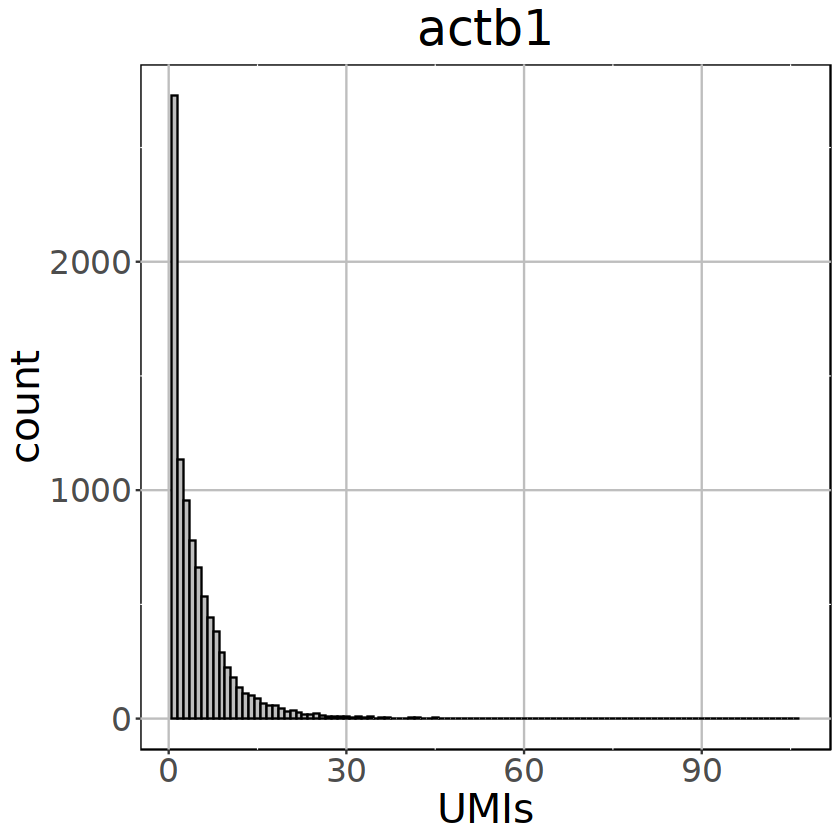

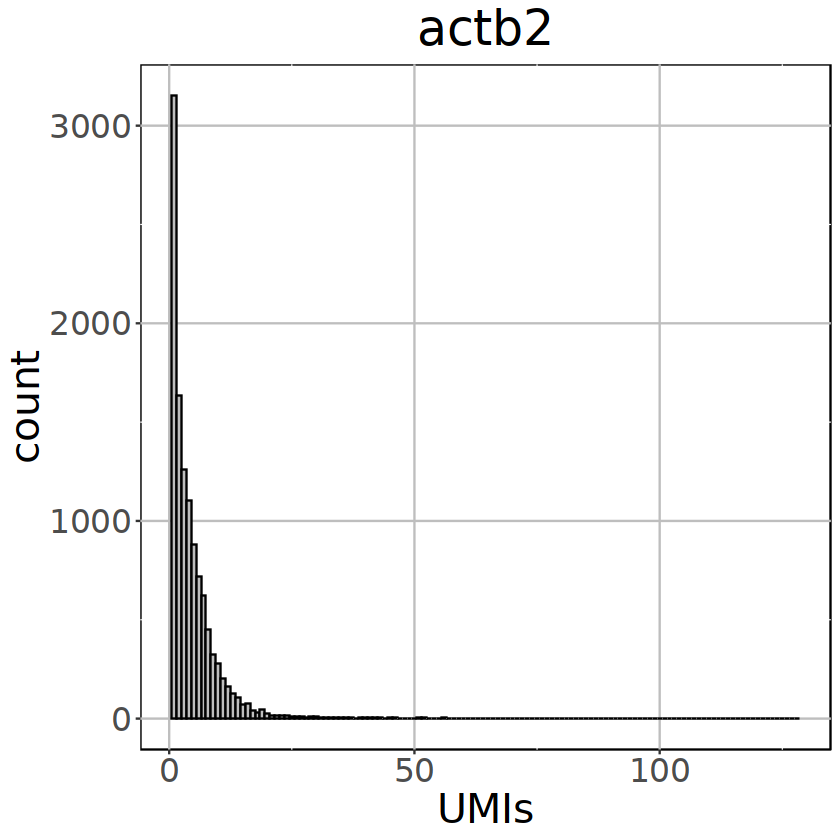

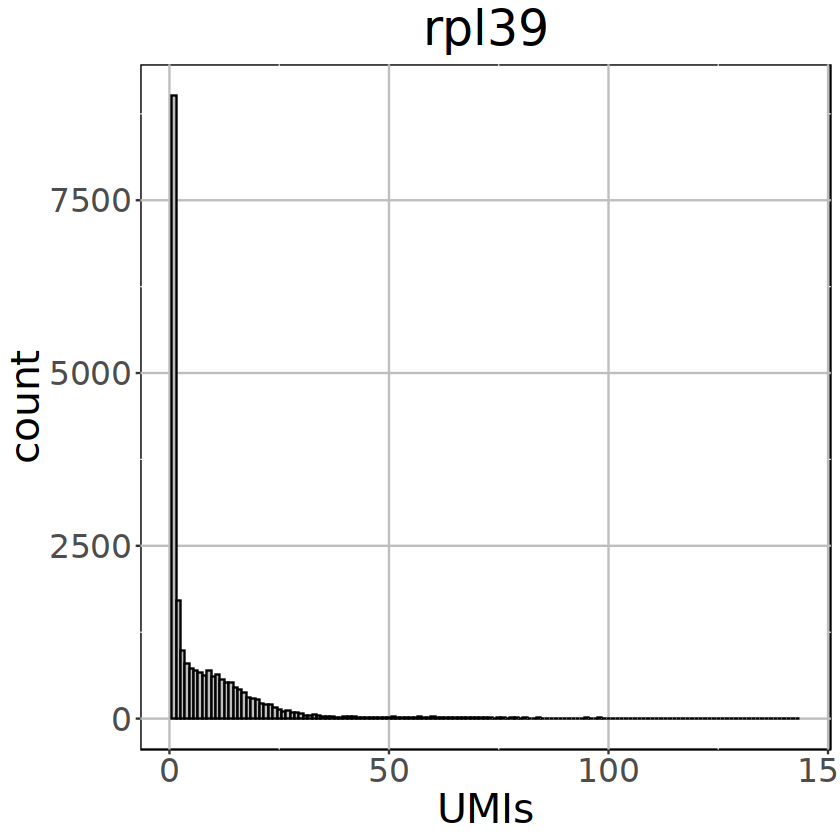

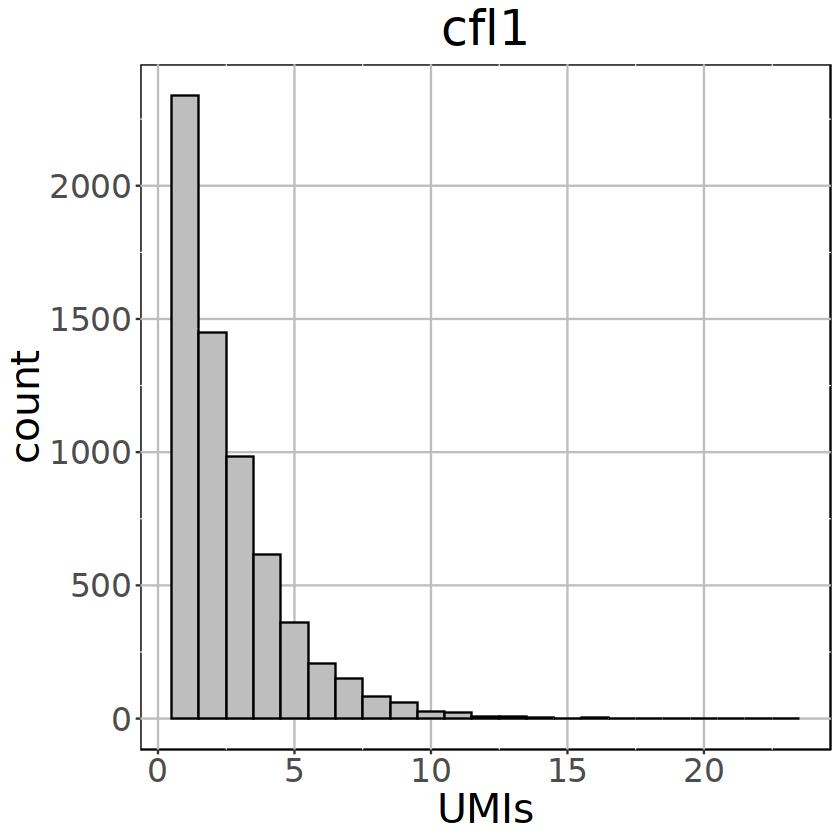

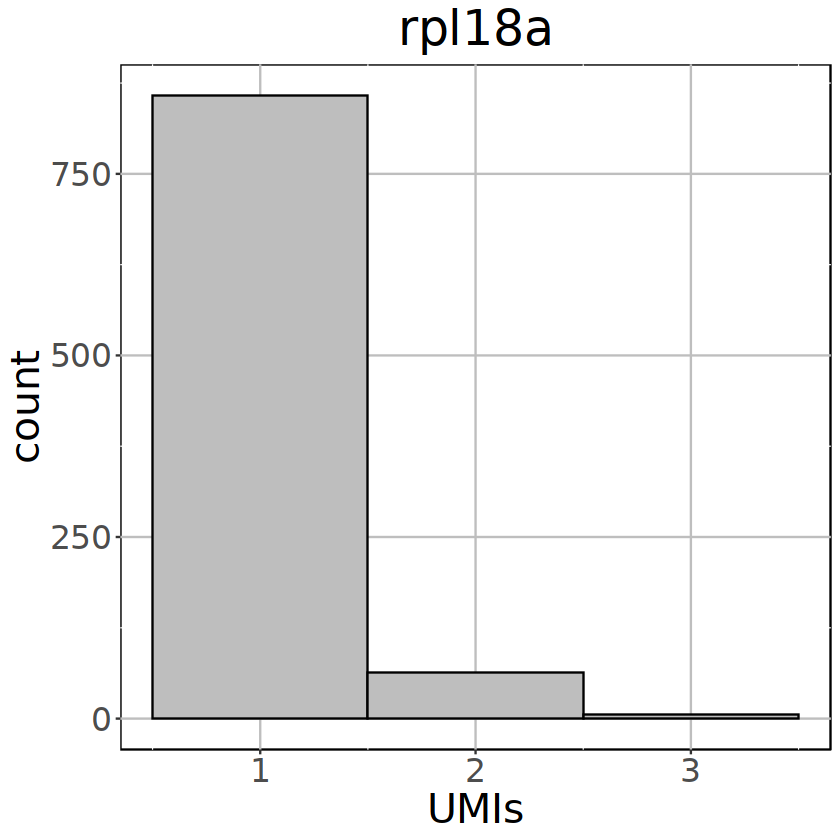

In [13]:
# Save output object
save(scars, file = paste0("Endo_scars_filtering_",dat_name,"_WLinput.Robj"))

# Check distribution of UMI-counts per allele for each gene

for(i in 1:length(gene_names)){
    
    gene_name <- gene_names[i]
    
    print(
          ggplot(scars$UMI_counted[scars$UMI_counted$Gene == gene_name, ]) +
              geom_histogram(aes(x = UMIs), binwidth = 1,color="black", fill="grey") +
              ggtitle(paste0(gene_name))
         )
    
    }

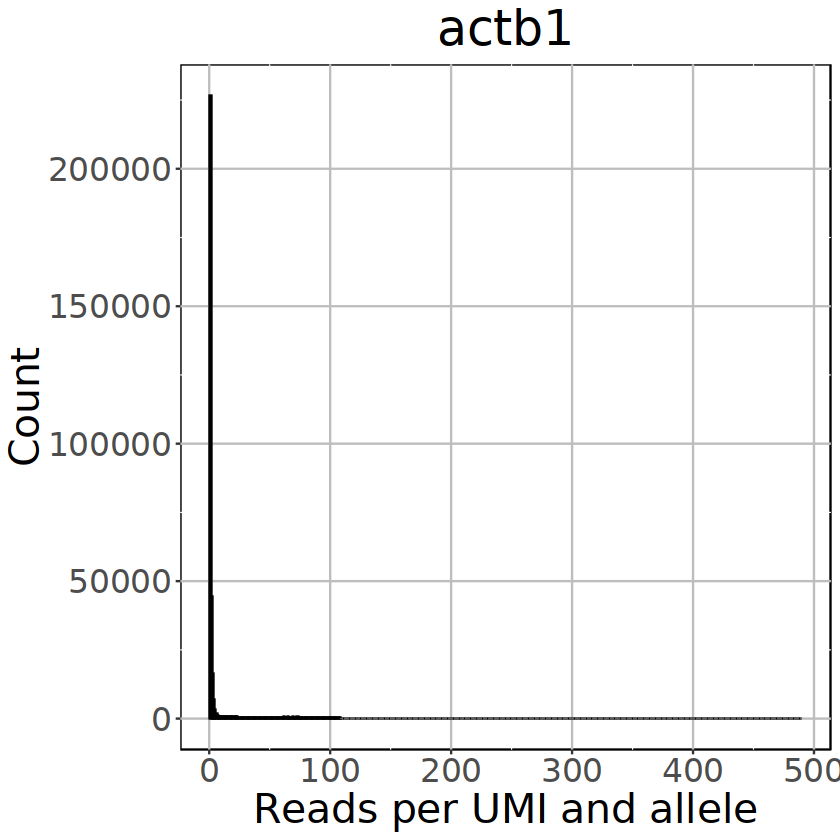

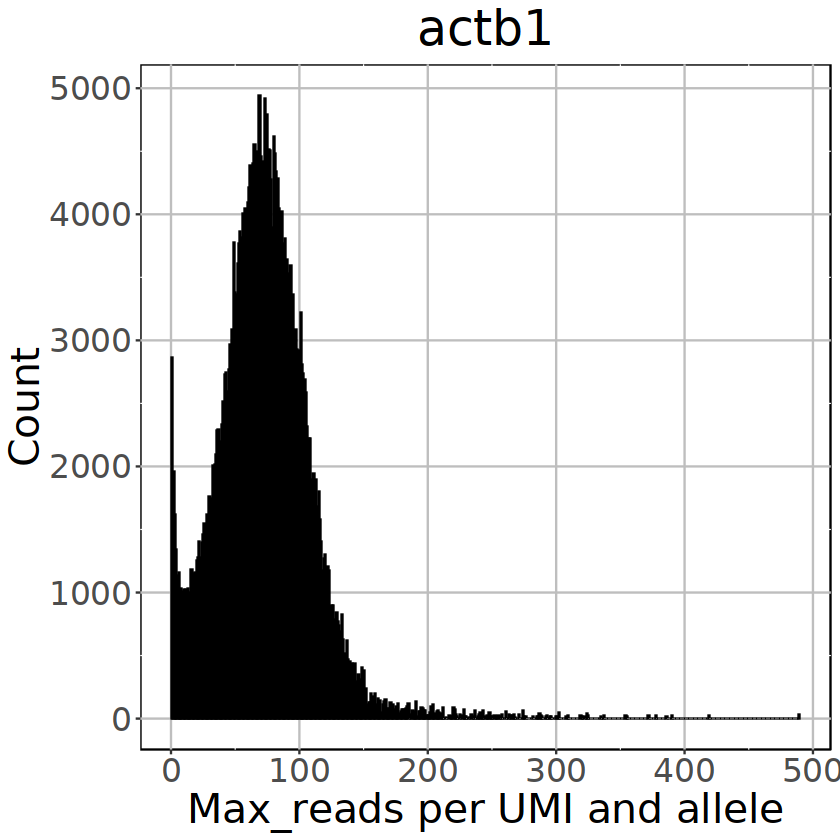

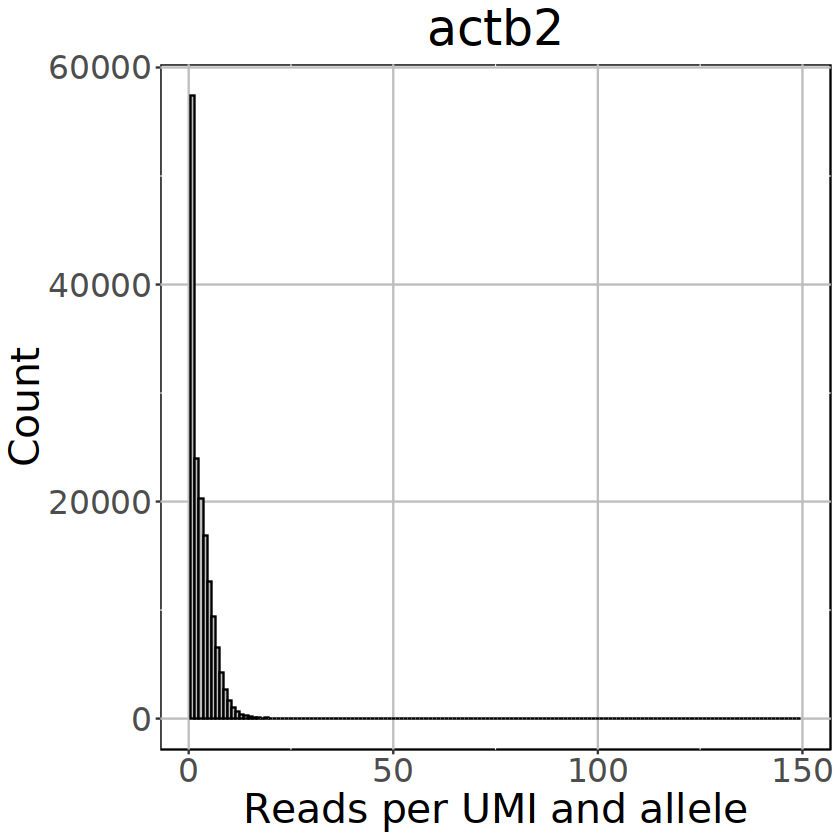

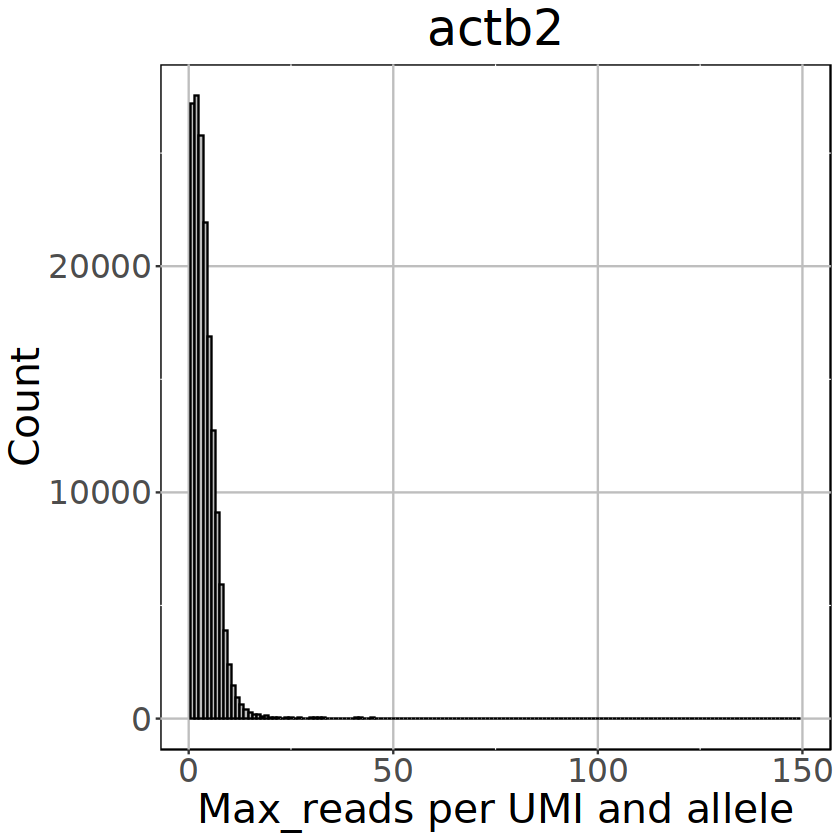

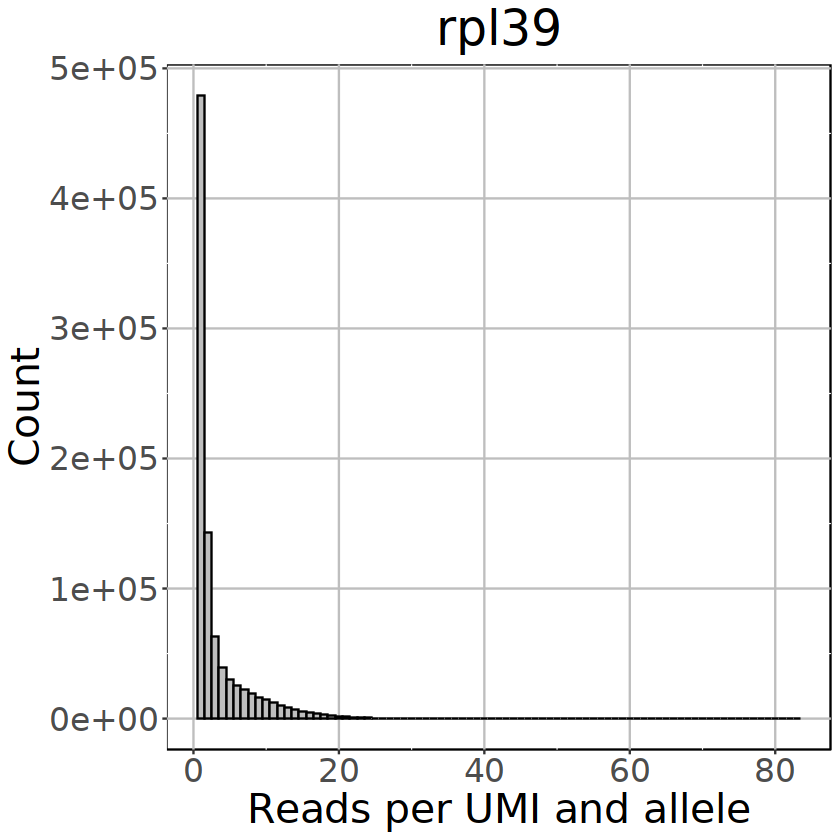

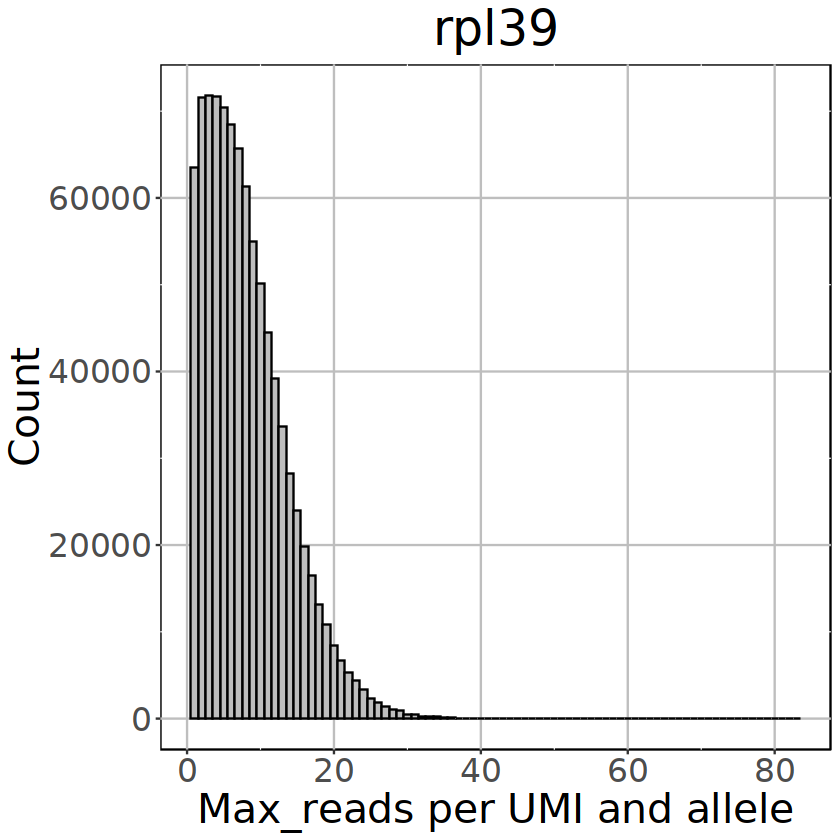

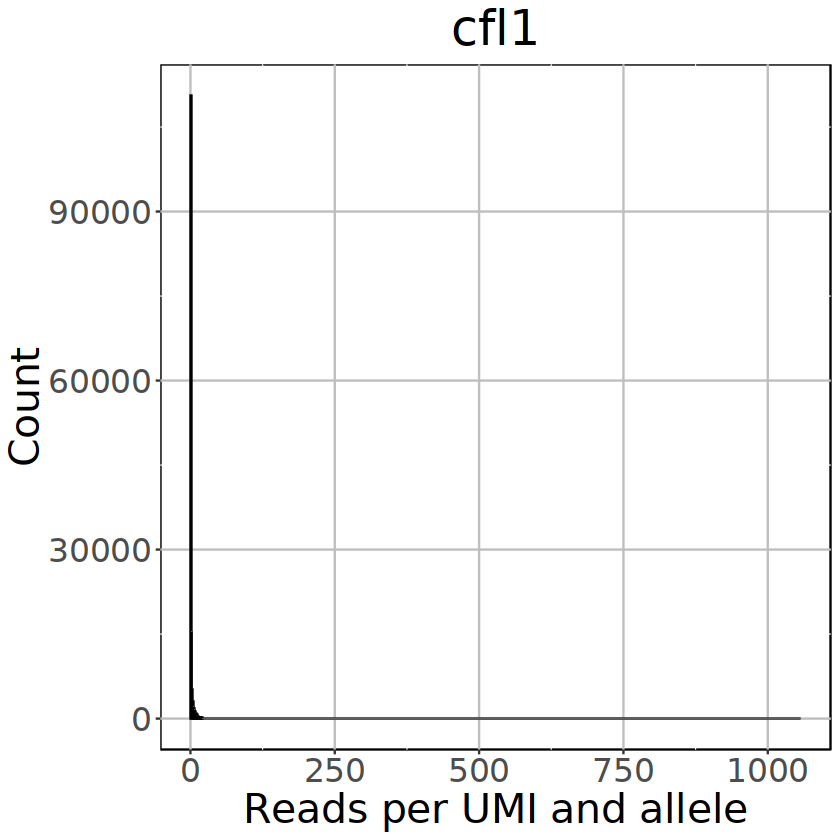

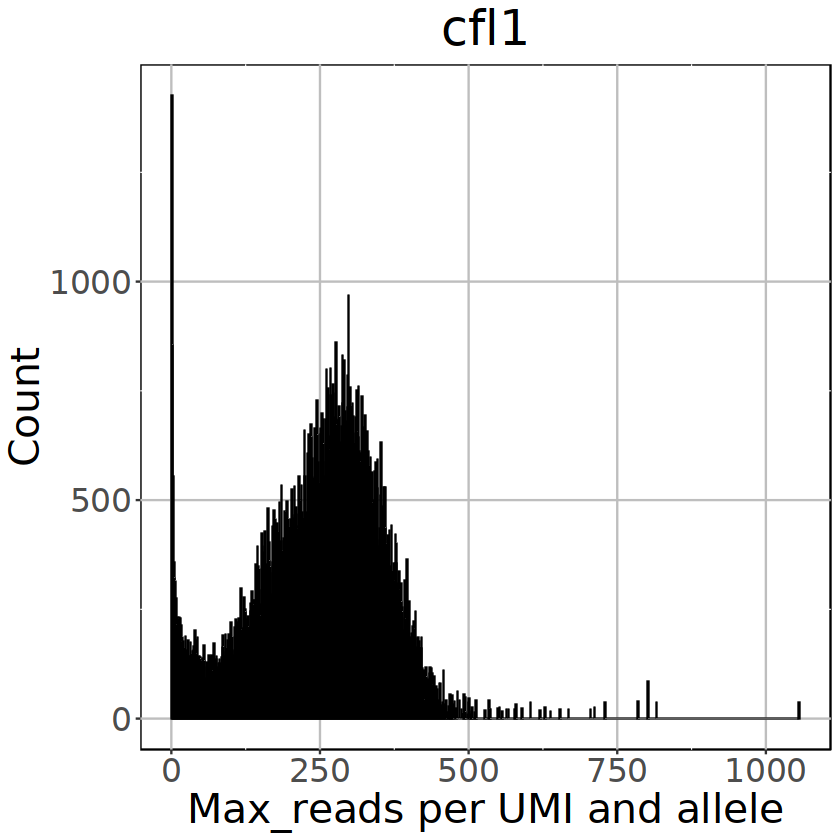

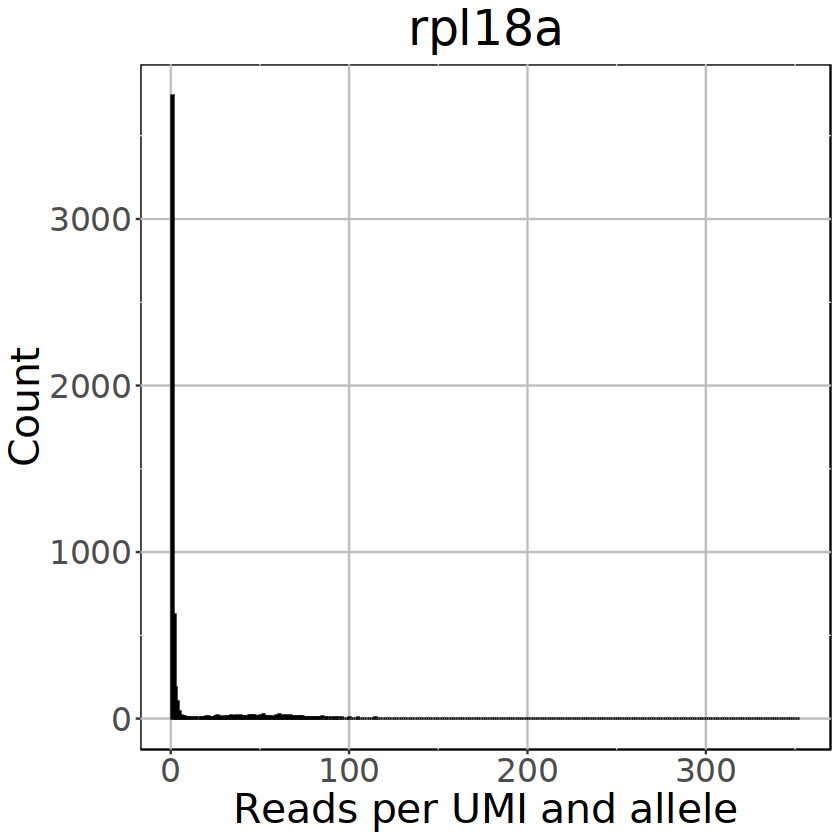

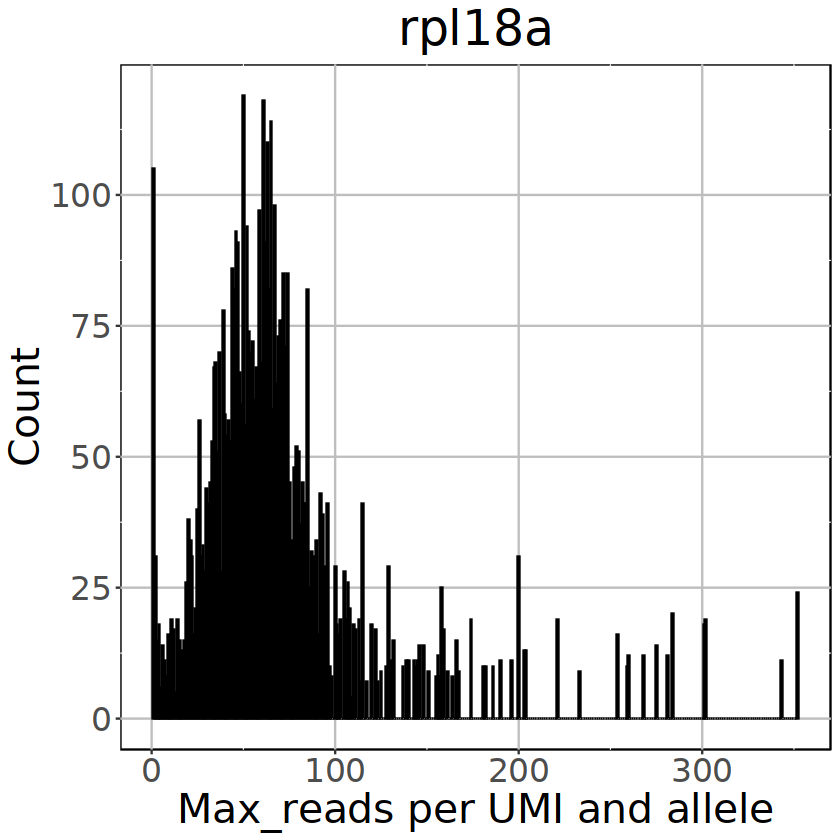

In [14]:
# Plot number of reads per UMI and allele for each gene.
# Use these distributions to set initial read-filtering cut-off below.

for(i in 1:length(genes_list)){

    gene <- genes_list[i]

    scars_input <- scars$Input
    scars_input$Reads <- as.numeric(scars_input$Reads)
    scars_input$Max_reads <- as.numeric(scars_input$Max_reads)

    # Plot number of reads per cell, UMI and allele
    print(ggplot(scars_input[scars_input$Gene == gene,]) +
                geom_histogram(aes(x = Reads), binwidth = 1,color="black", fill="grey") +
                labs(title = paste0(gene), x = 'Reads per UMI and allele', y = 'Count')
    )

    # Plot the maximum number of reads found for a given UMI-allele combination. All other reads from that UMI with another allele are likely sequencing errors.
    print(ggplot(scars_input[scars_input$Gene == gene,]) +
                geom_histogram(aes(x = Max_reads), binwidth = 1,color="black", fill="grey") +
                labs(title = paste0(gene), x = 'Max_reads per UMI and allele', y = 'Count')
    )

    
}

#### Perform lineage barcode comparison to remove frequently created lineage barcodes

In [16]:
# Load filtered lineage barcode data

load("Endo_scars_filtering_multi_seq_09_s1_WLinput.Robj") # loads object 'scars'

f_scars_in_trnscrptm <- scars$Filtering_output[scars$Filtering_output$Barcode %in% cell_anno$Barcode,]
f_scars_in_trnscrptm <- f_scars_in_trnscrptm[f_scars_in_trnscrptm$Barcode %in% unique(scars$Stats_per_cell[scars$Stats_per_cell$Over == F,]$Barcode, scars$Stats_per_cell[scars$Stats_per_cell$Doublet == F,]$Barcode),]


# Adjust names of the cells to match the cell names in the Seurat object

# Extract cell barcode prefix and suffix
prefix <- if (grepl("_", rownames(cell_anno)[1])) sub("^(.*_).*", "\\1", rownames(cell_anno)[1]) else ""
suffix <- if (grepl("-", rownames(cell_anno)[1])) sub(".*(-.*)$", "\\1", rownames(cell_anno)[1]) else ""

# Add to cells in lineage barcode dataframe
f_scars_in_trnscrptm$Barcode <- paste0(prefix,f_scars_in_trnscrptm$Barcode,suffix)
rm(scars)


In [17]:
# Run lineage barcode comparison to lineage barcodes recovered from bulk larval experiments.

# Load cell type annotation
cell_anno <- dat@meta.data
cell_anno$Barcode <- rownames(cell_anno)

scar_probabilities_in <- read.csv("../Gene_scar_probs.csv",
                                       stringsAsFactors = F)

# Run function. The output will be written into the working directory.
# Output tables start with 'Z1_scars_compared'.
compare_scars(input_dat_name = f_scars_in_trnscrptm, # output of the scar filtering
                          dat_name = dat_name, # output dat_name
                          min.presence = 2, # Cells that have to have a scar for it to be considered present in an organism
                          gene_names = c("actb1", "actb2","rpl39","cfl1","rpl18a"), # all genes that you want to screen
                          scar_probabilities_in = scar_probabilities_in, # scar probabilities generated from bulk sequencing of many larvae
                          seur_dat = cell_anno, # a seurat metadata file that contains all valid cell barcodes (16-base-barcode only) in a column named "Barcode"
                          primer_set = "01" # can be either "01" or "02" depending on which primer set was used. Here, only set 01 was used!
                         )


[1] "Starting with 40974 entries in scar file."
[1] "Comparing gene actb1"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


[1] "Comparing gene actb2"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


[1] "Comparing gene rpl39"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


[1] "Comparing gene cfl1"
[1] "Comparing gene rpl18a"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


### Grouping of cells and lineage barcodes based on individual endogenous target genes 

In [18]:
# When working with data from multiple individuals (e.g. fish) at once:
# The sample ID needs to be defined in the column sample_inf in the cell_anno object and a sample ID list needs to be passed to the functions, as done below.

cell_anno <- dat@meta.data
cell_anno$Barcode <- rownames(cell_anno)

# Define sample ID
cell_anno$sample_inf <- cell_anno$fish_all

In [19]:
# set variables for running the following functions
dat_wd  <- paste0(getwd())
dat_name <- "multi_seq_09_s1"
cooc_fraction_cutoff <- 0.8
seur_dat <- cell_anno
tums_list <- c("all", unique(cell_anno$sample_inf))
genes_list <- c("actb1", "actb2","rpl39","cfl1","rpl18a")
scar_file_name <- "Z1_scars_compared_multi_seq_09_s1" # Prefix of scar comparison output files

[1] "Now working on tumour all and gene actb1."
[1] "entries in scar input object for gene actb1: 8507"


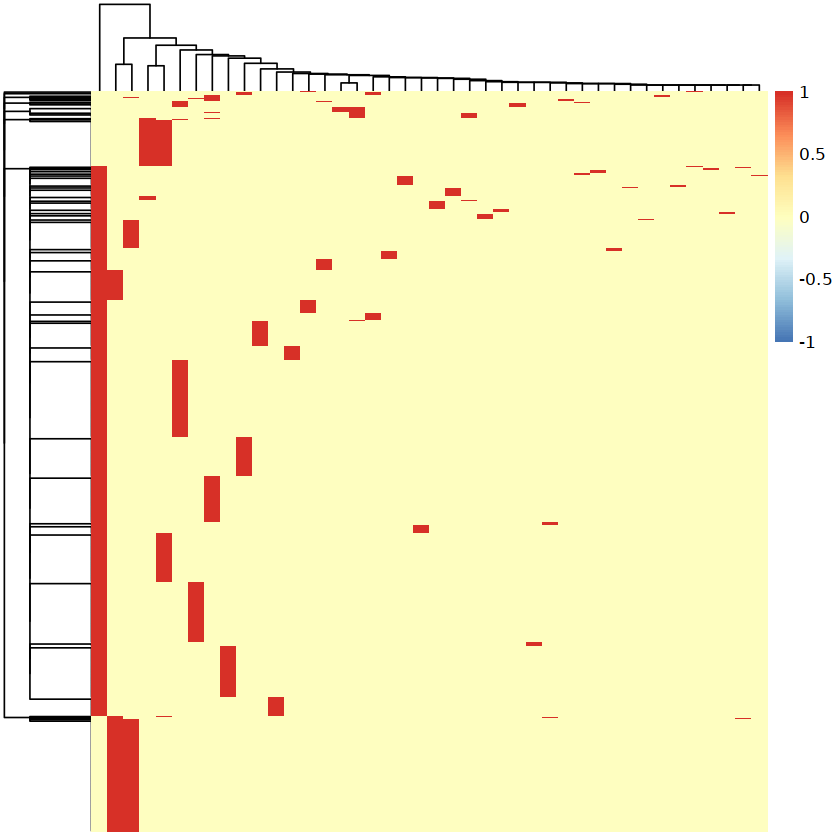

[1] "Adding 289 cells with a single scar to clones."
[1] "Now working on tumour all and gene actb2."
[1] "entries in scar input object for gene actb2: 10548"


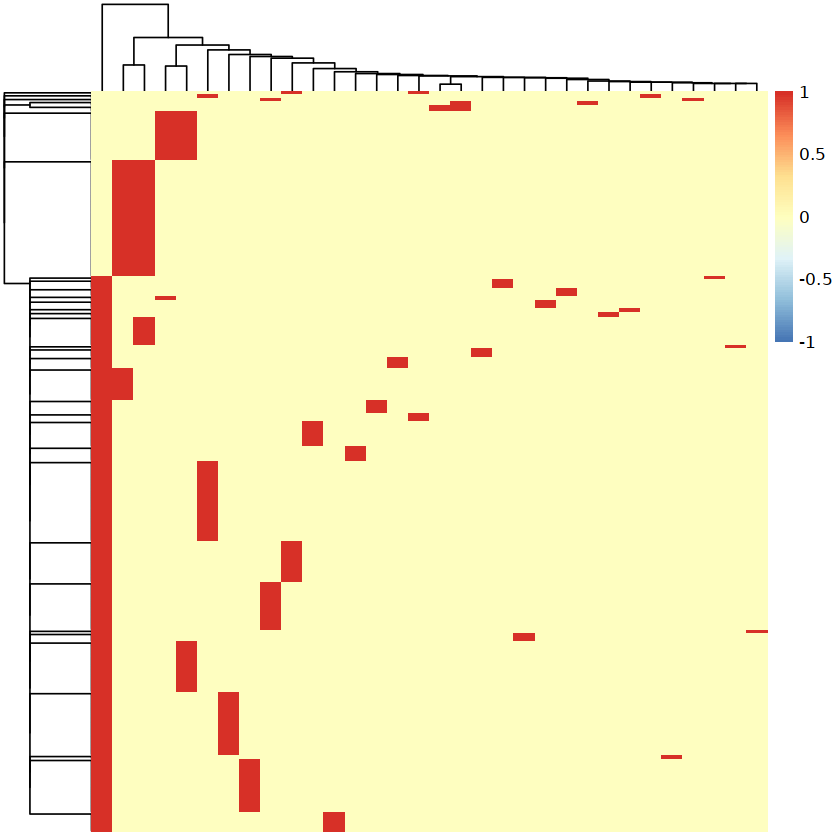

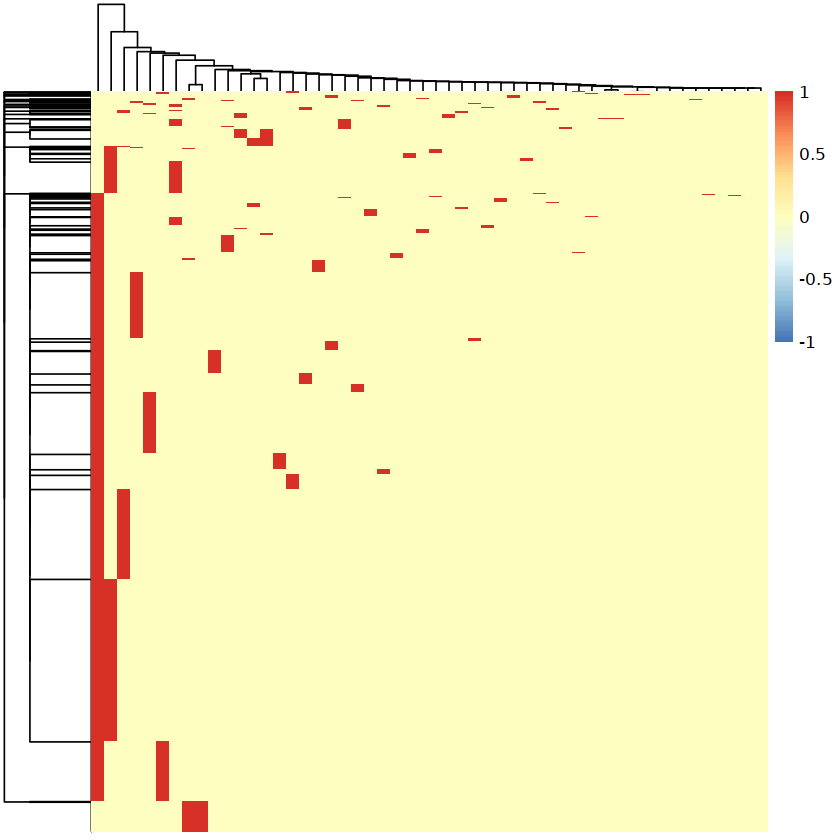

[1] "Adding 164 cells with a single scar to clones."
[1] "Now working on tumour all and gene rpl39."
[1] "entries in scar input object for gene rpl39: 14746"


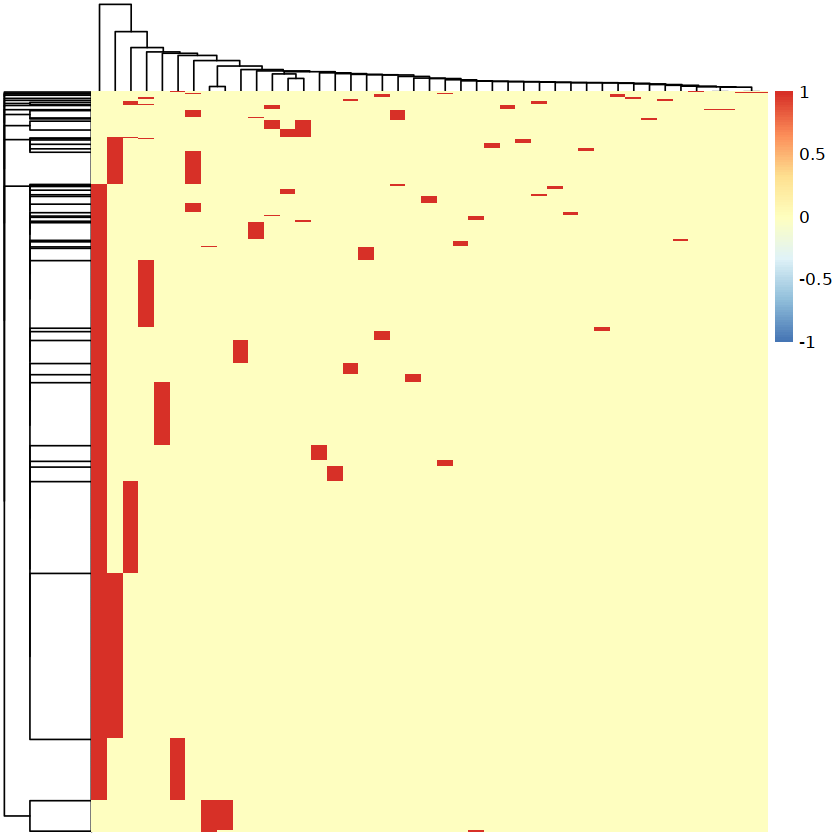

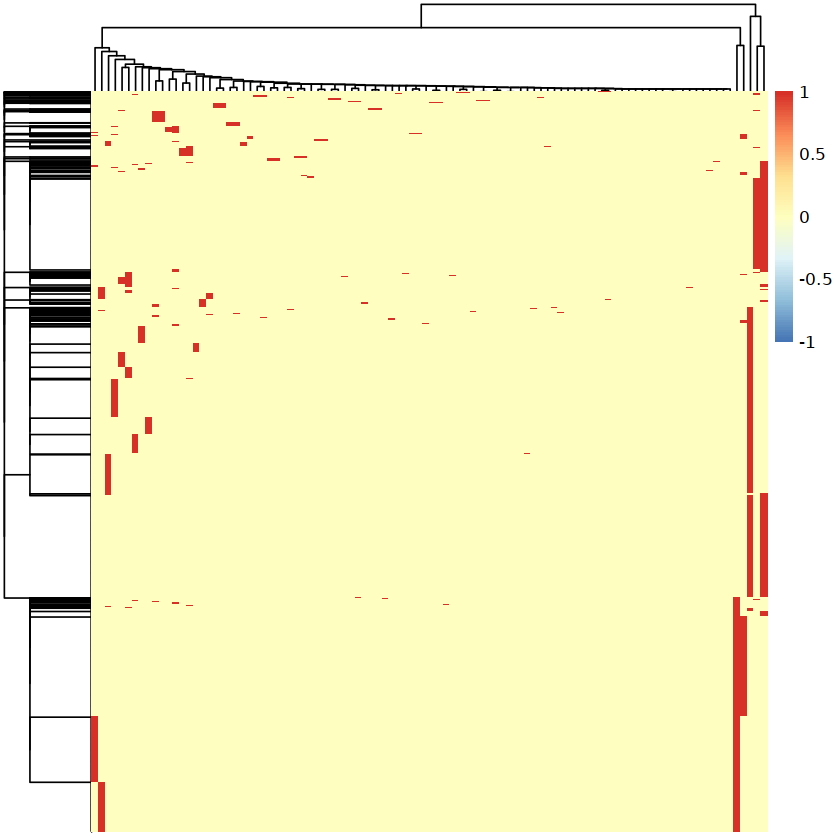

[1] "Adding 98 cells with a single scar to clones."
[1] "Now working on tumour all and gene cfl1."
[1] "entries in scar input object for gene cfl1: 6247"


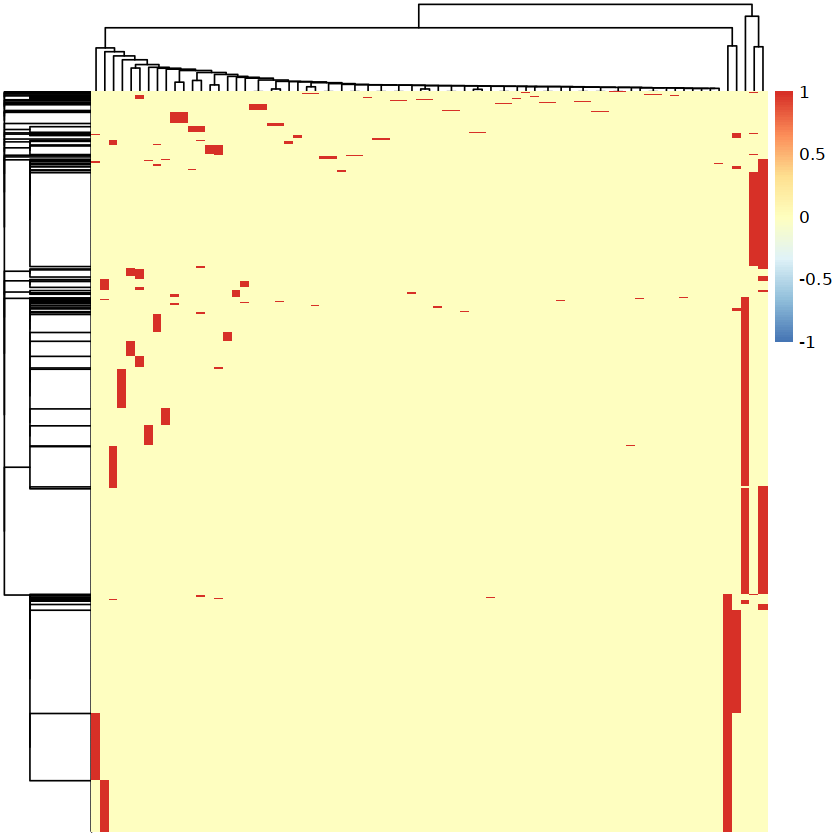

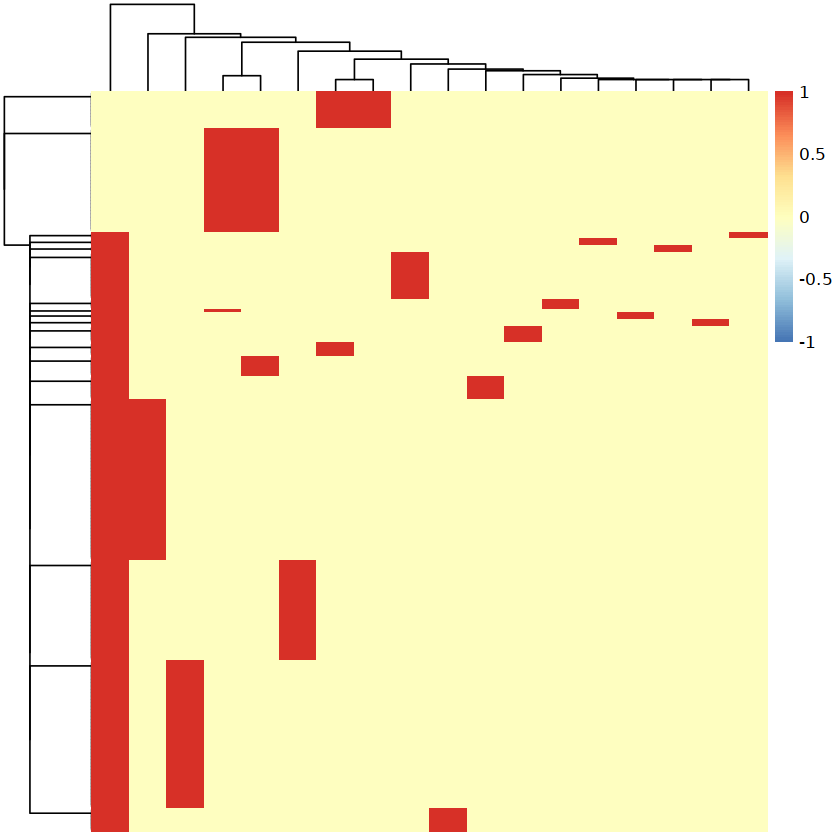

[1] "Adding 31 cells with a single scar to clones."
[1] "Now working on tumour all and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 926"


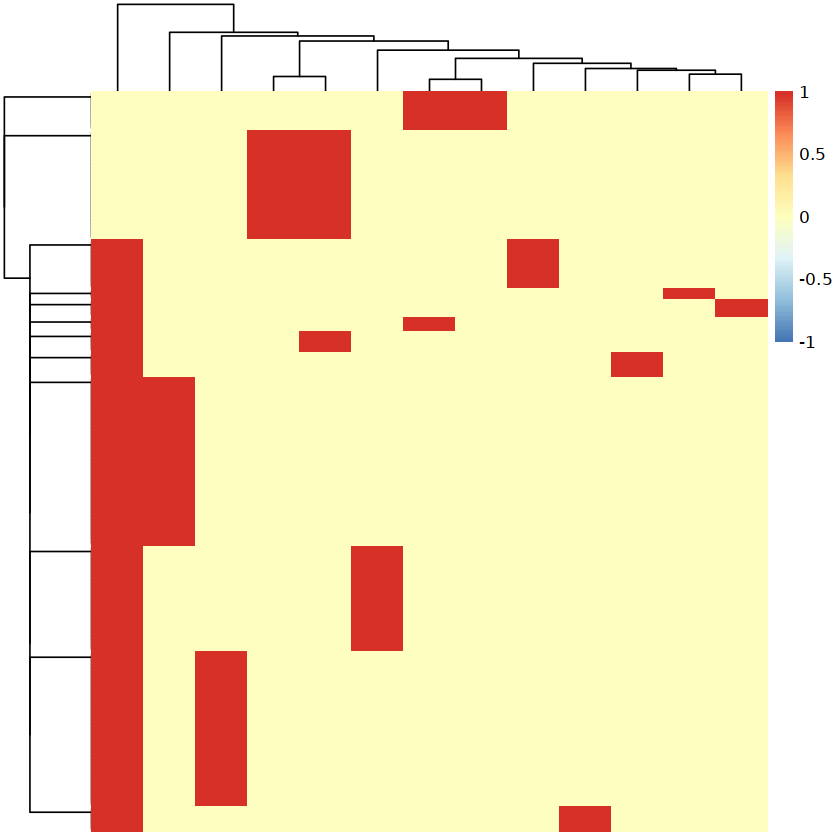

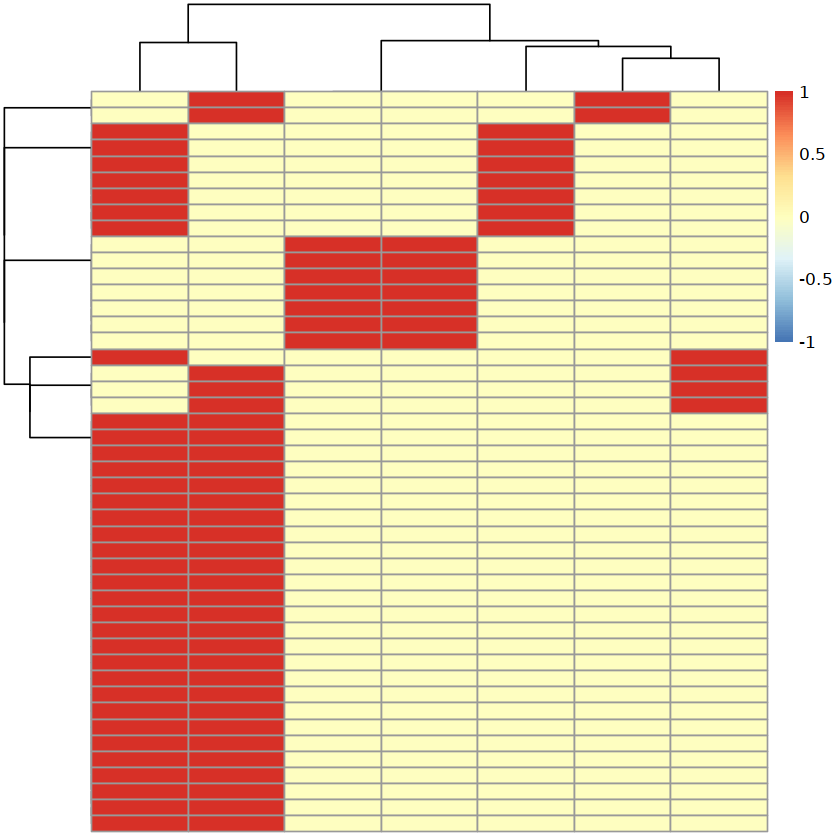

[1] "Adding 10 cells with a single scar to clones."
[1] "Now working on tumour 3 and gene actb1."
[1] "entries in scar input object for gene actb1: 2163"


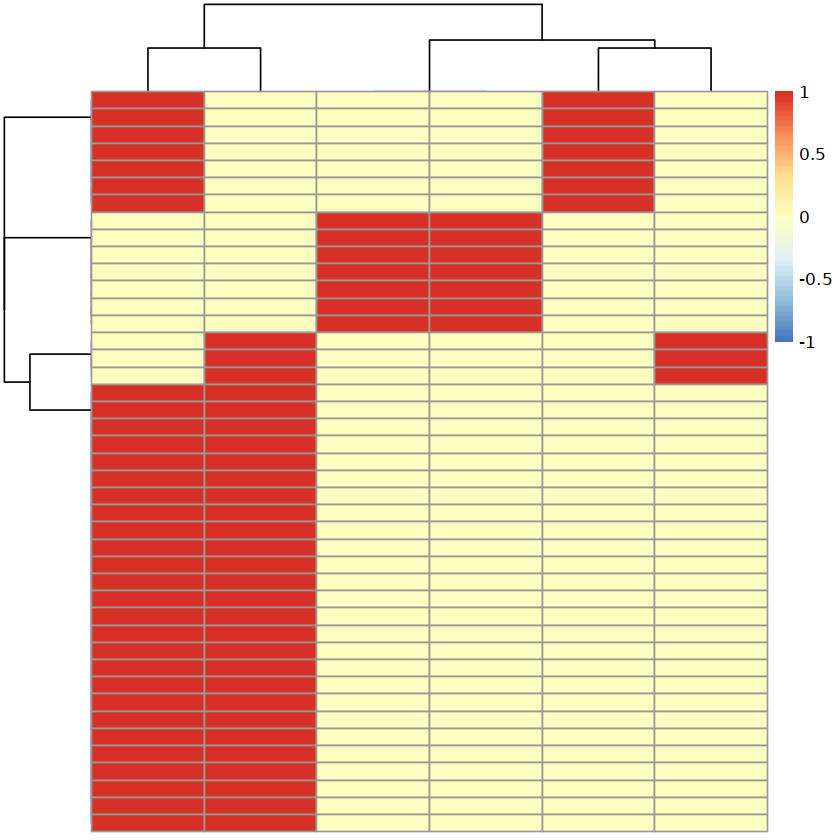

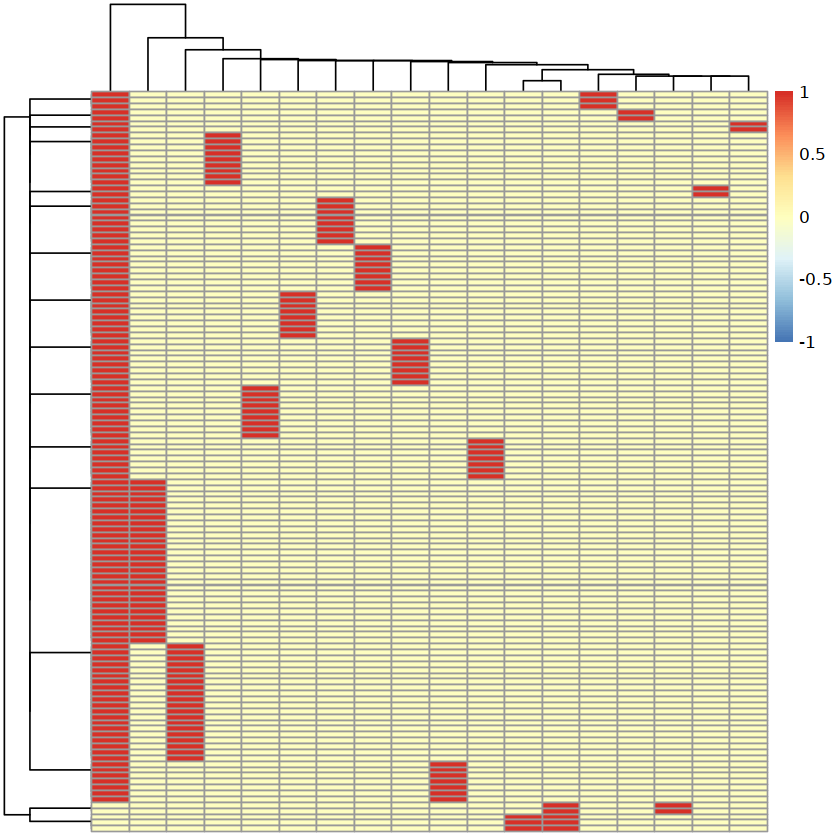

[1] "Adding 5 cells with a single scar to clones."
[1] "Now working on tumour 3 and gene actb2."
[1] "entries in scar input object for gene actb2: 2642"


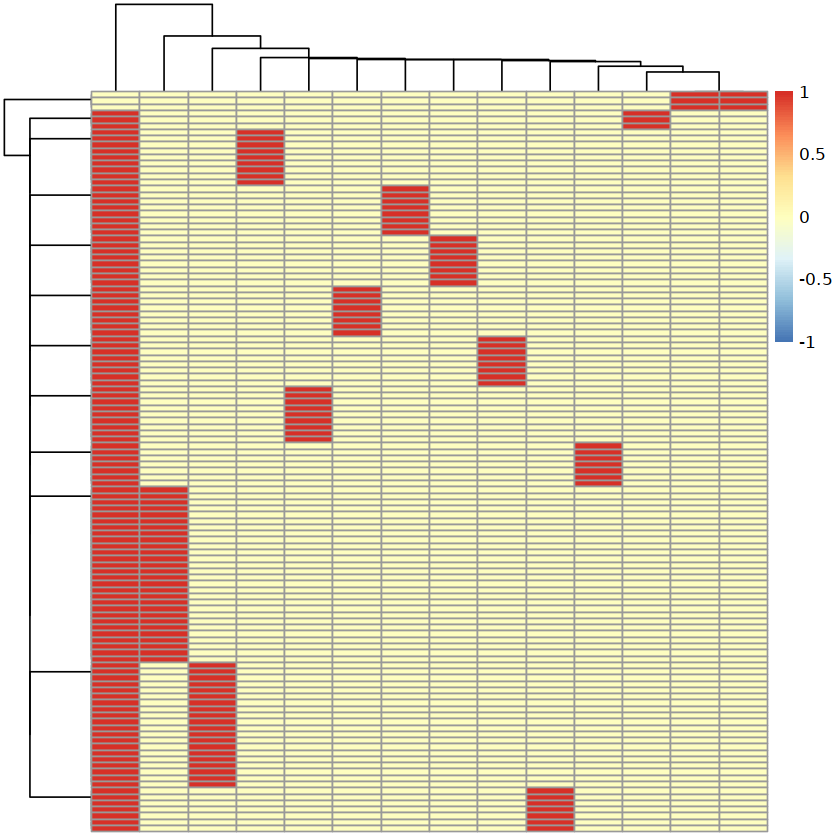

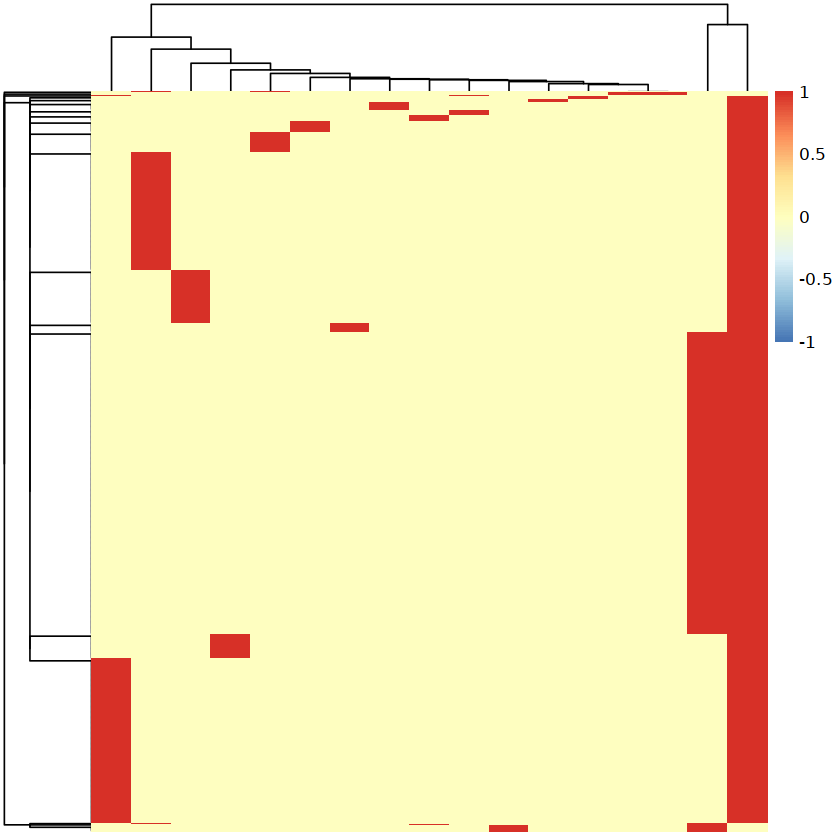

[1] "Adding 42 cells with a single scar to clones."
[1] "Now working on tumour 3 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 4013"


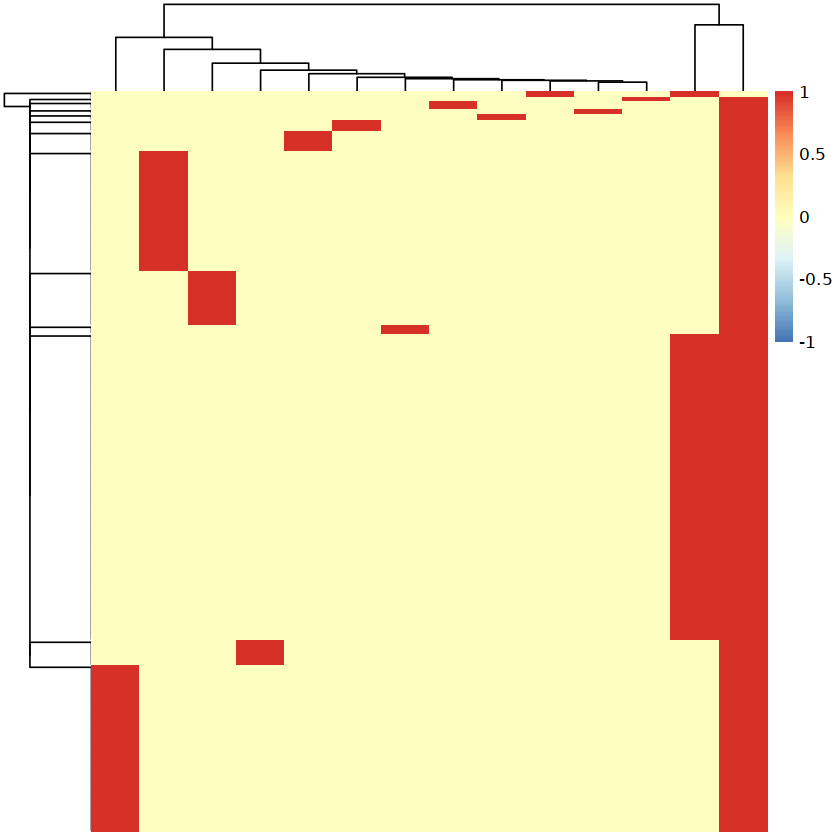

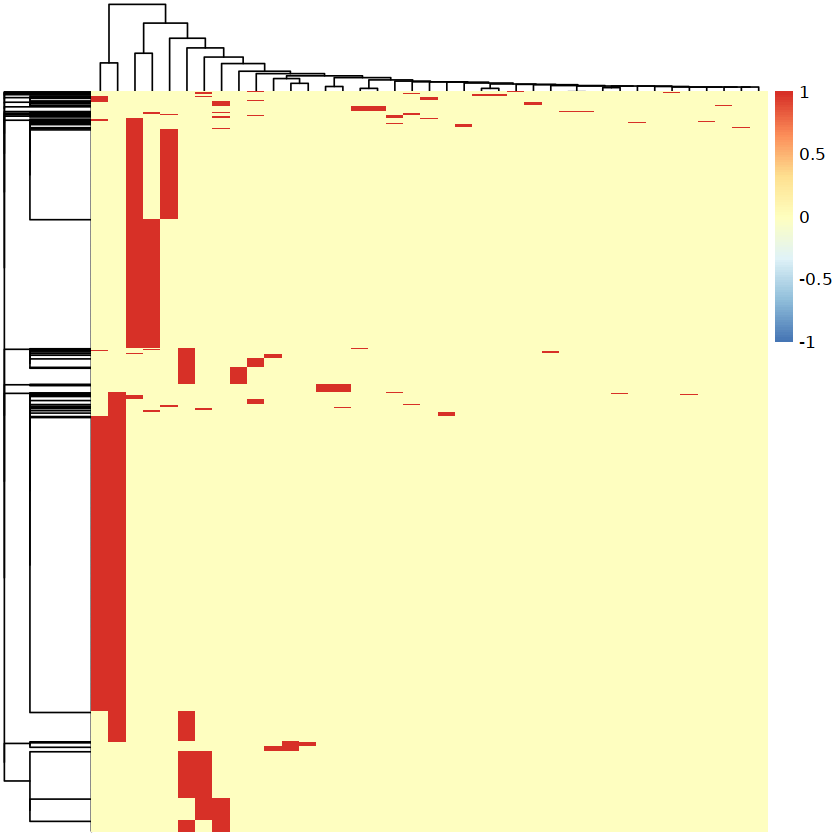

[1] "Adding 27 cells with a single scar to clones."
[1] "Now working on tumour 3 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 1656"


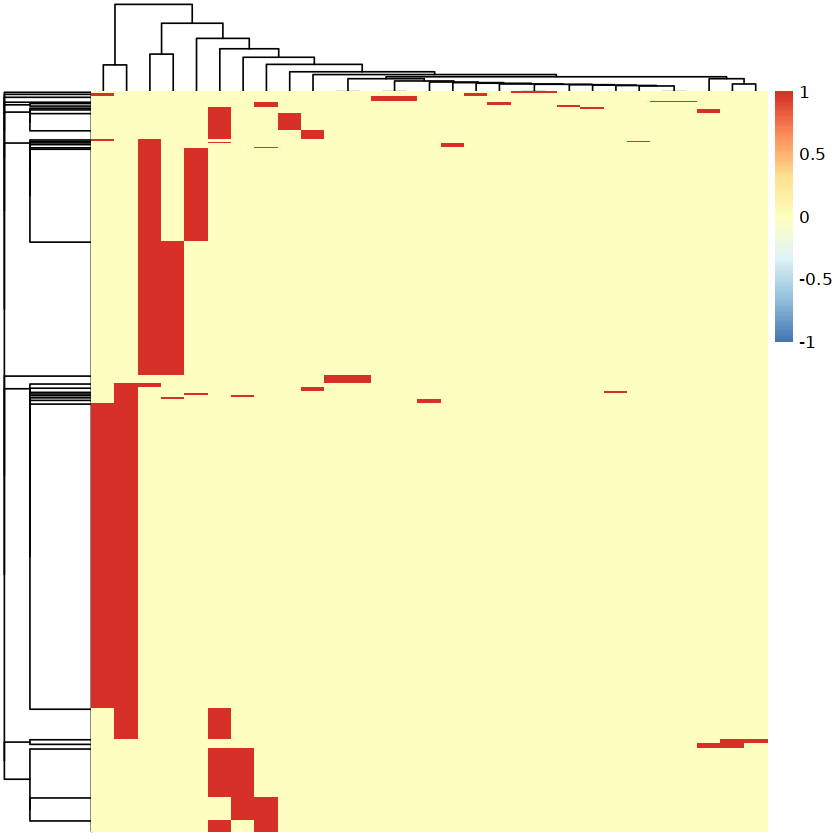

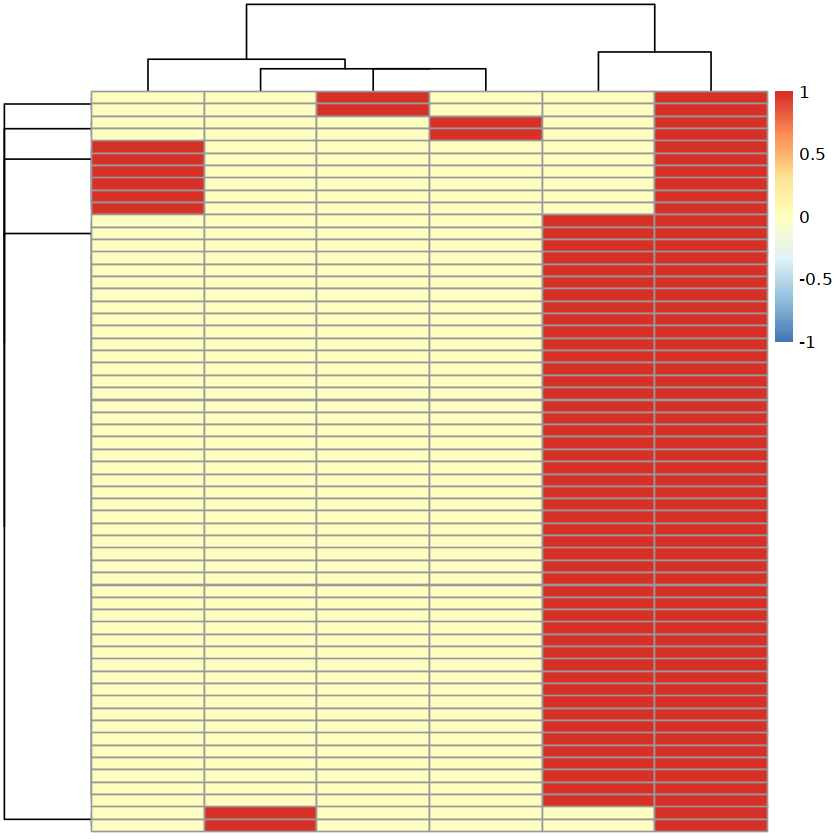

[1] "Adding 9 cells with a single scar to clones."
[1] "Now working on tumour 3 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 218"


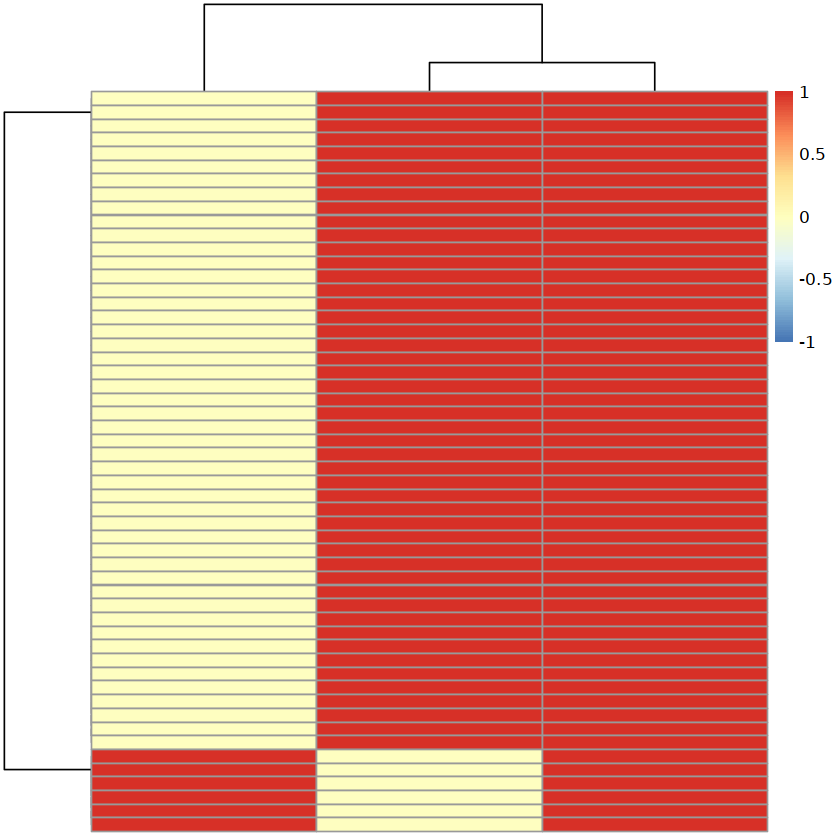

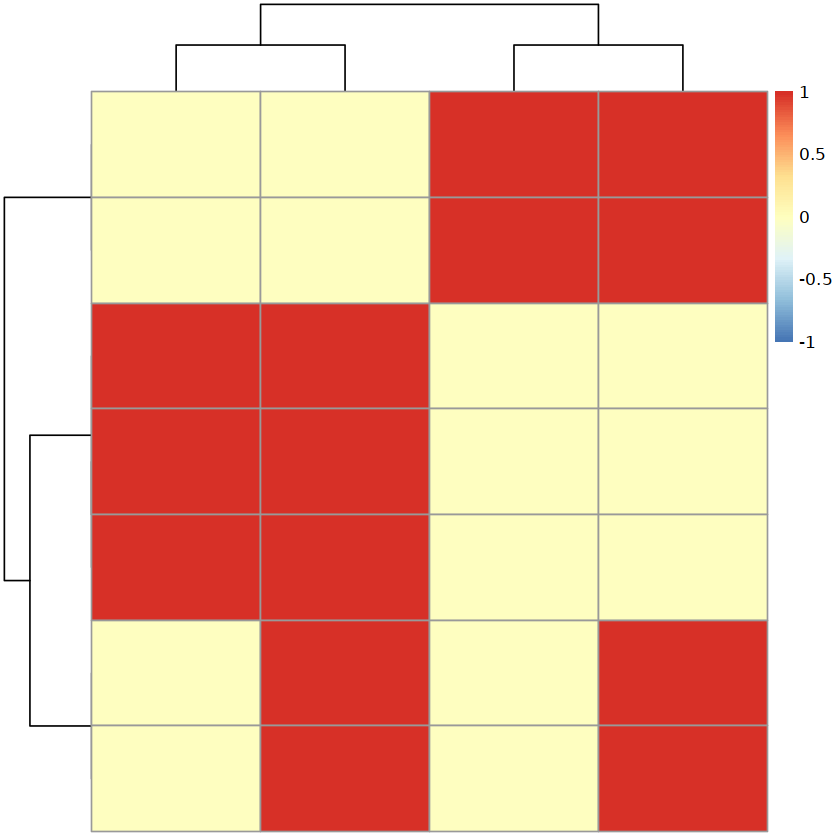

[1] "Now working on tumour 6 and gene actb1."
[1] "entries in scar input object for gene actb1: 953"


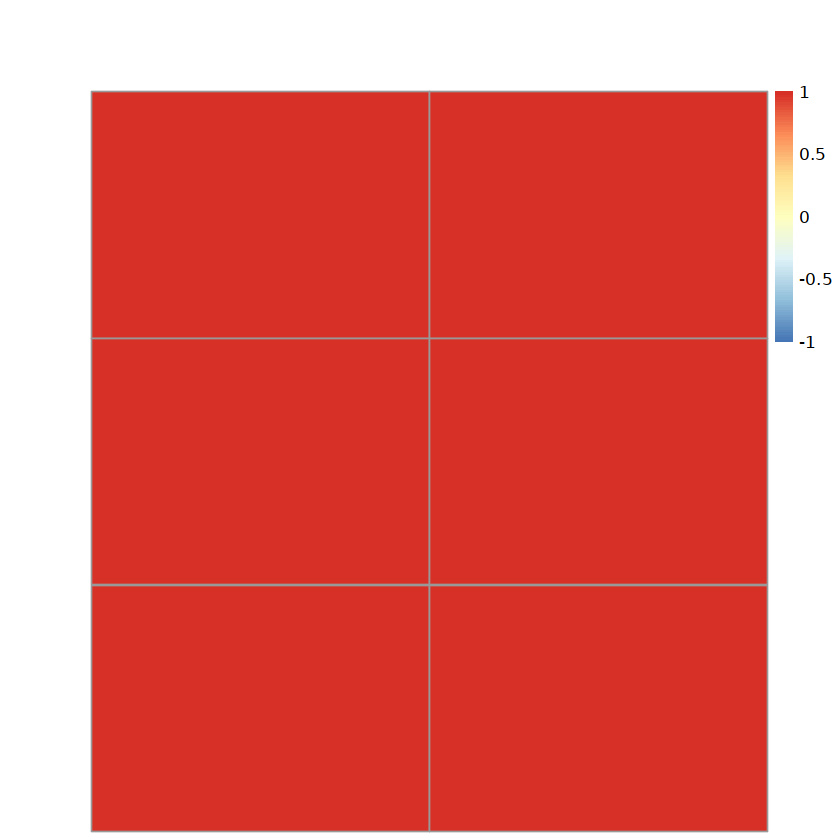

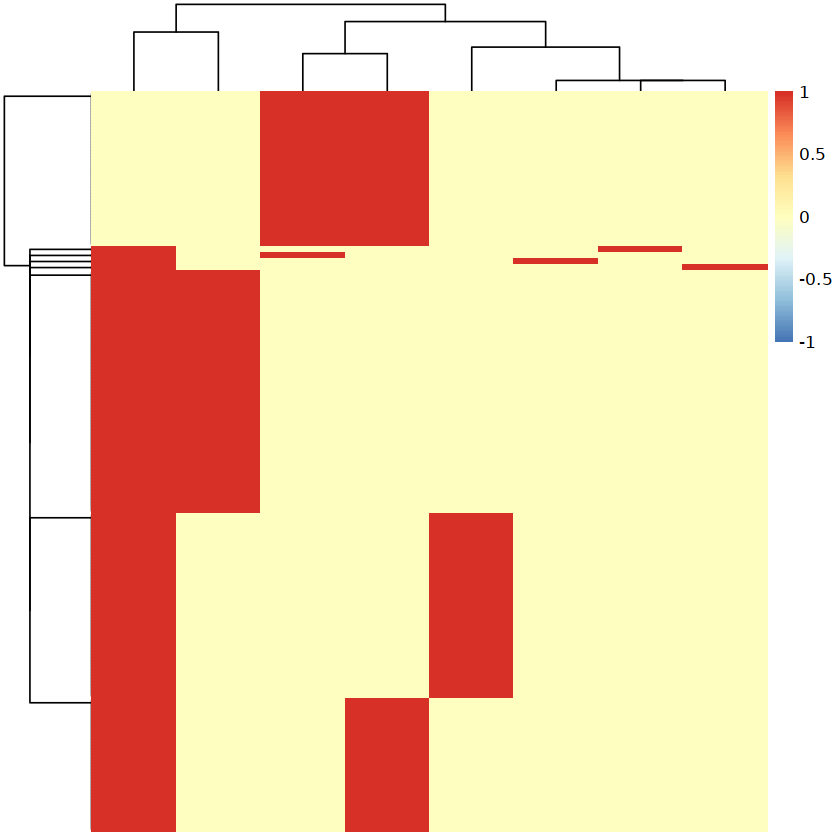

[1] "Adding 17 cells with a single scar to clones."
[1] "Now working on tumour 6 and gene actb2."
[1] "entries in scar input object for gene actb2: 1021"


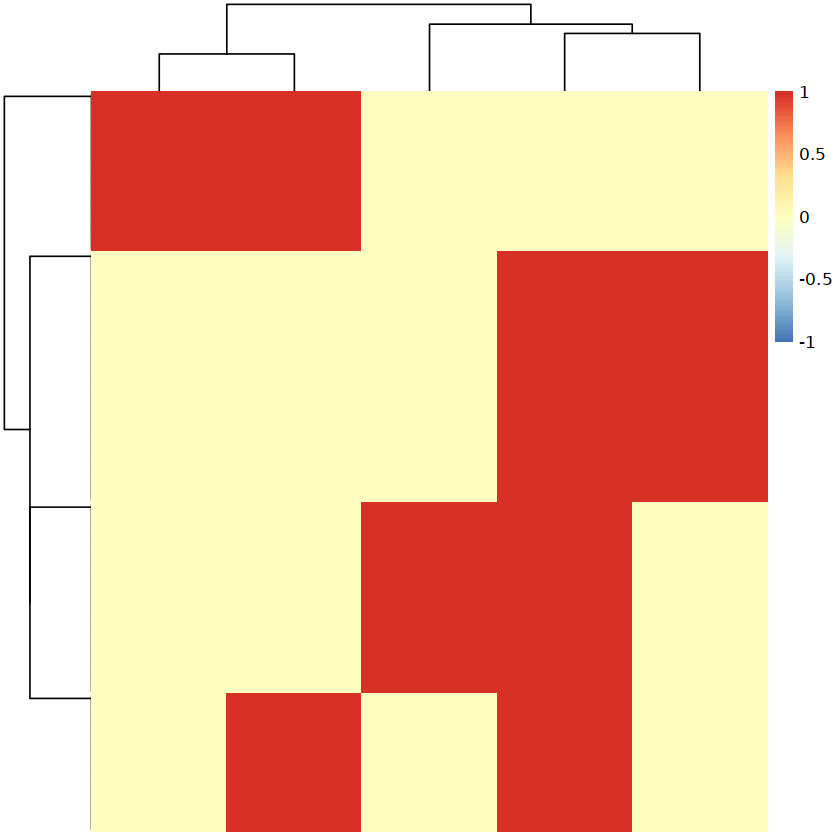

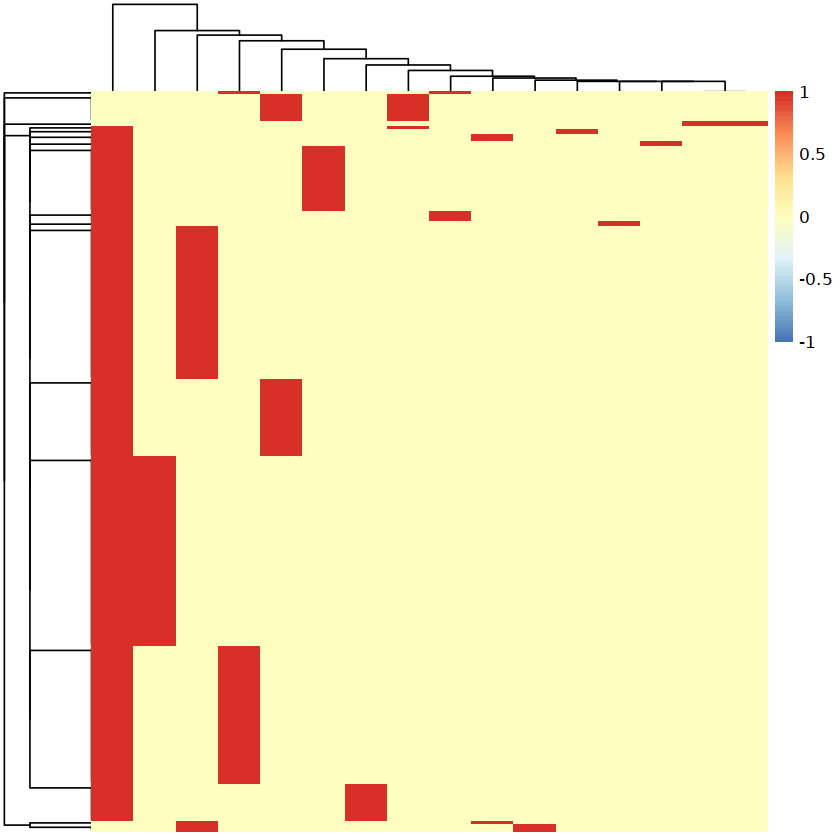

[1] "Adding 46 cells with a single scar to clones."
[1] "Now working on tumour 6 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 1454"


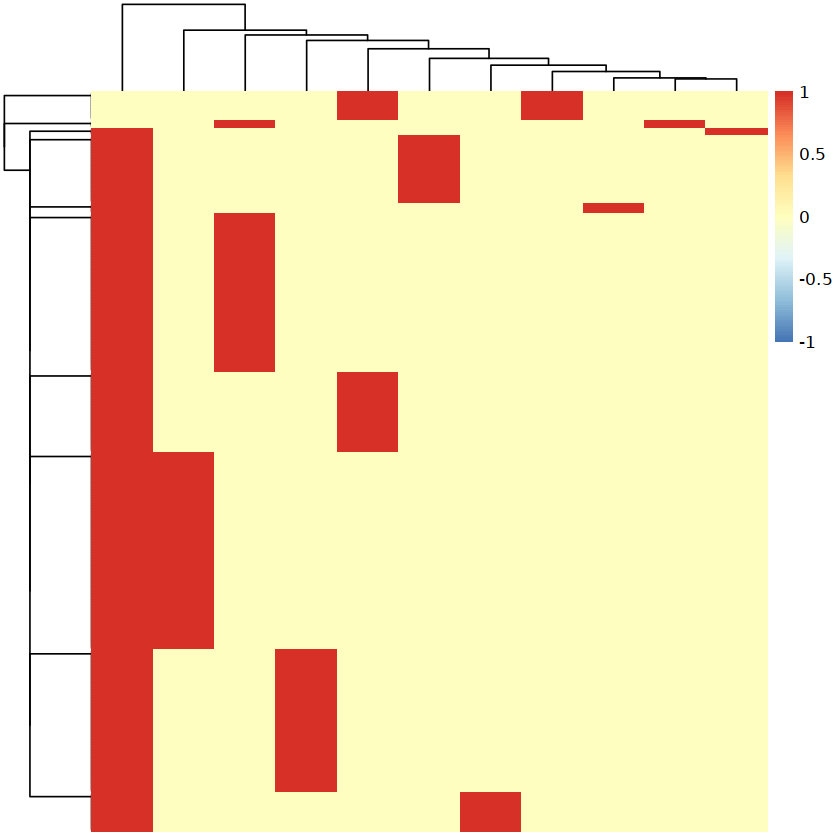

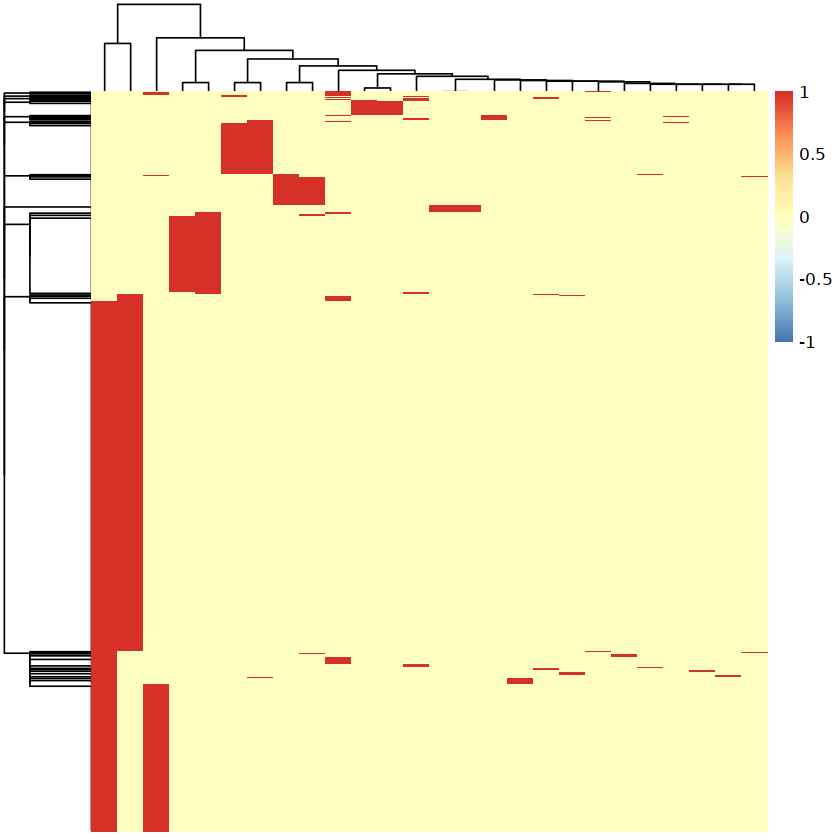

[1] "Adding 9 cells with a single scar to clones."
[1] "Now working on tumour 6 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 639"


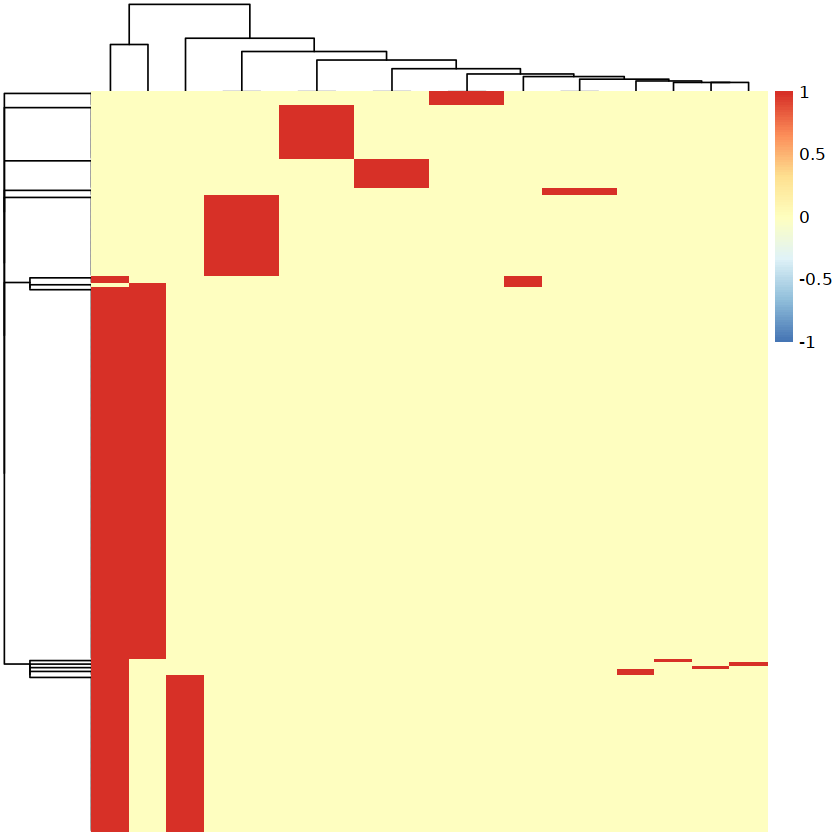

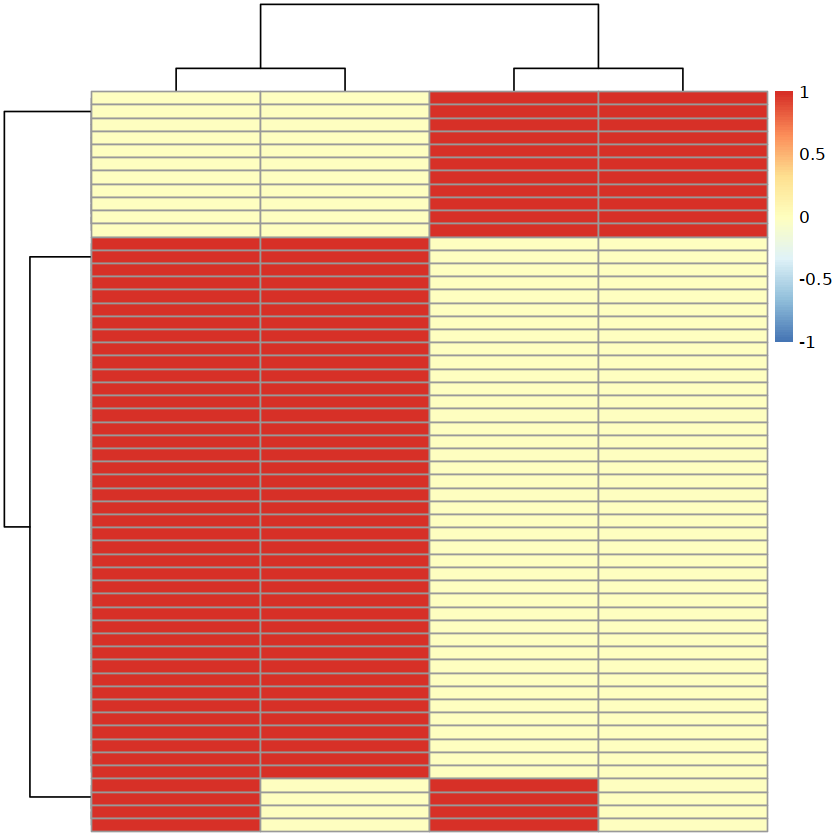

[1] "Adding 7 cells with a single scar to clones."
[1] "Now working on tumour 6 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 30"
[1] "Now working on tumour 4 and gene actb1."
[1] "entries in scar input object for gene actb1: 1306"


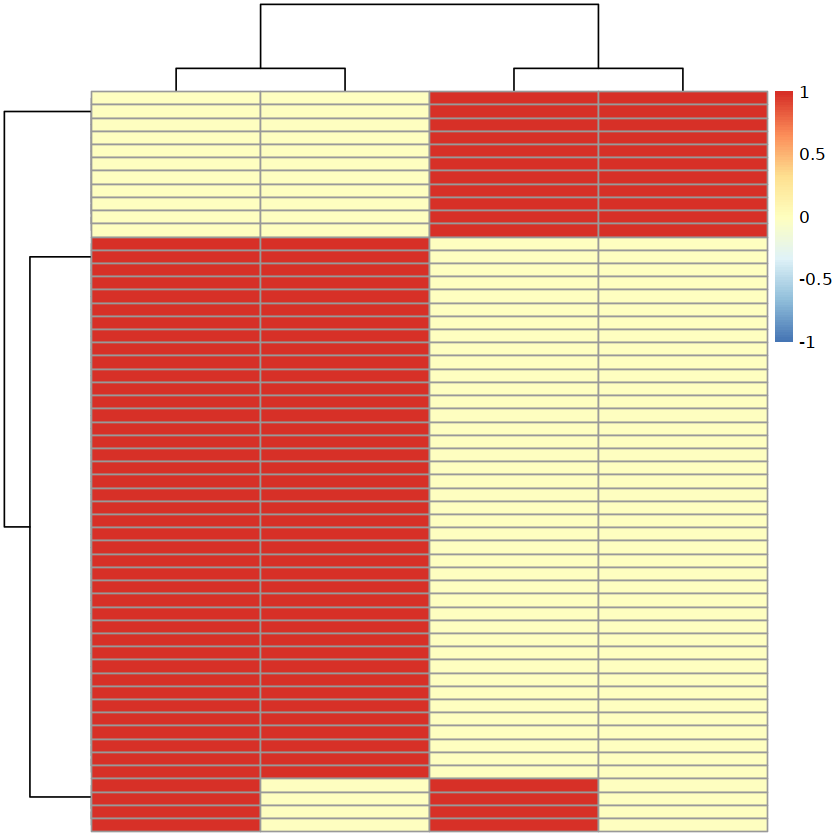

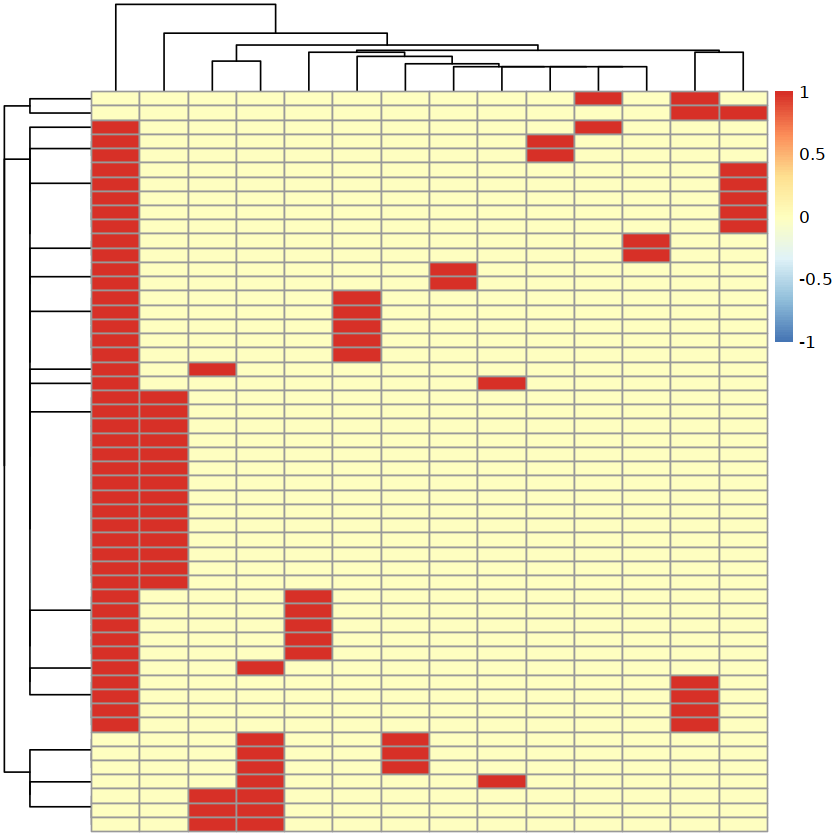

[1] "Adding 2 cells with a single scar to clones."
[1] "Now working on tumour 4 and gene actb2."
[1] "entries in scar input object for gene actb2: 1870"


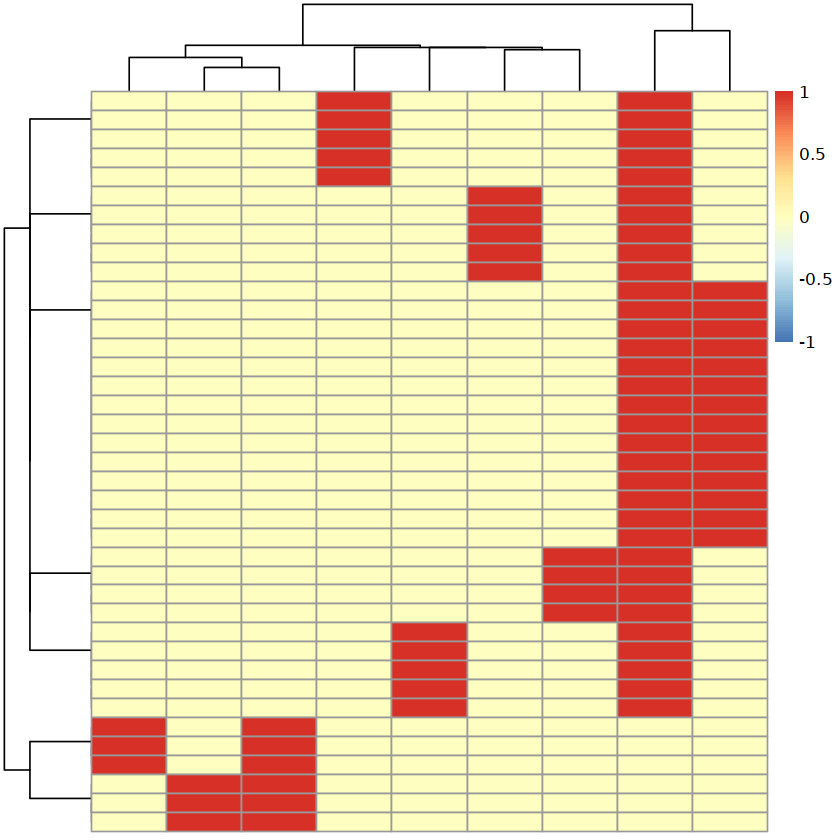

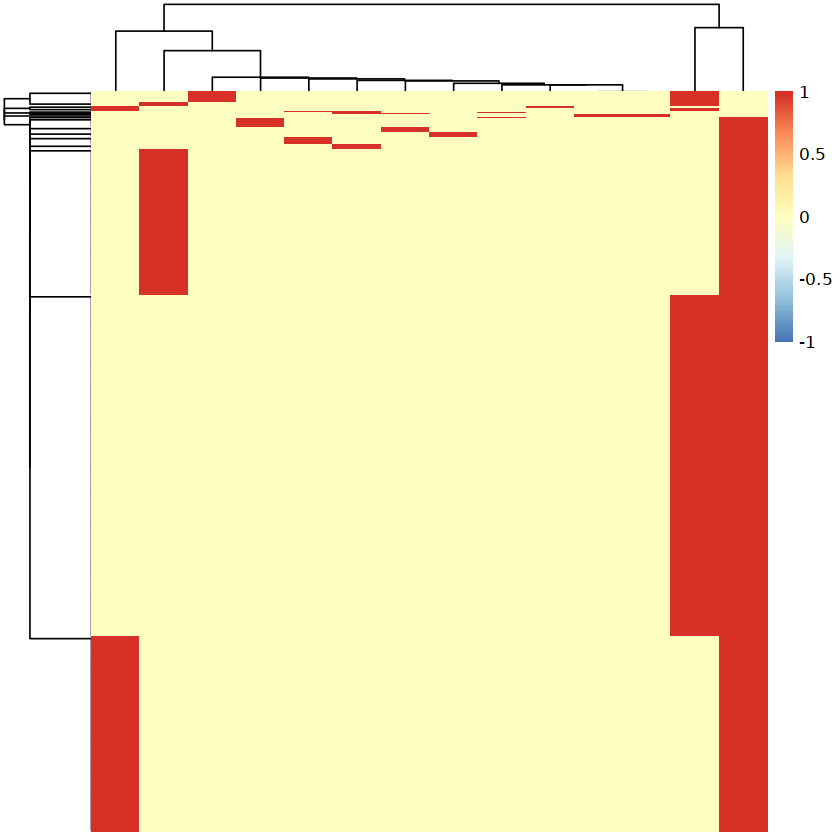

[1] "Adding 34 cells with a single scar to clones."
[1] "Now working on tumour 4 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 2466"


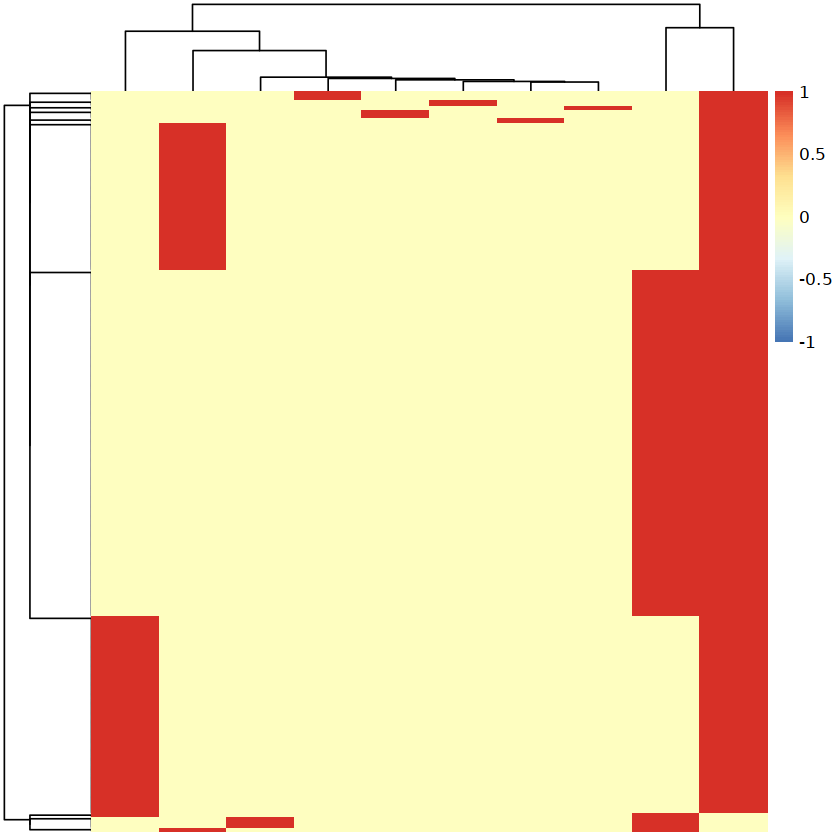

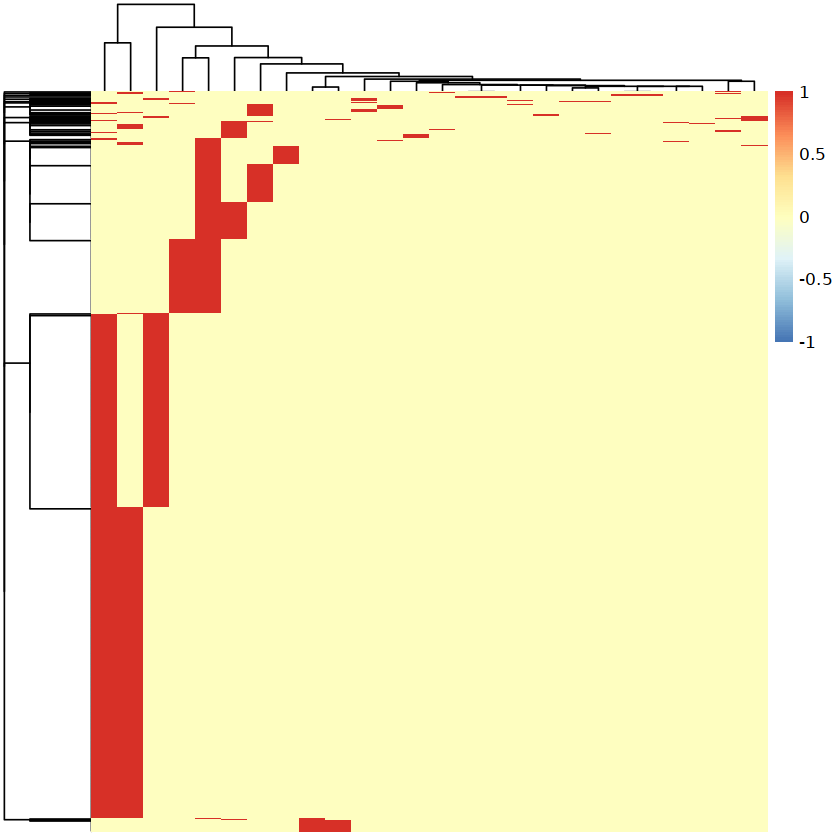

[1] "Adding 36 cells with a single scar to clones."
[1] "Now working on tumour 4 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 912"


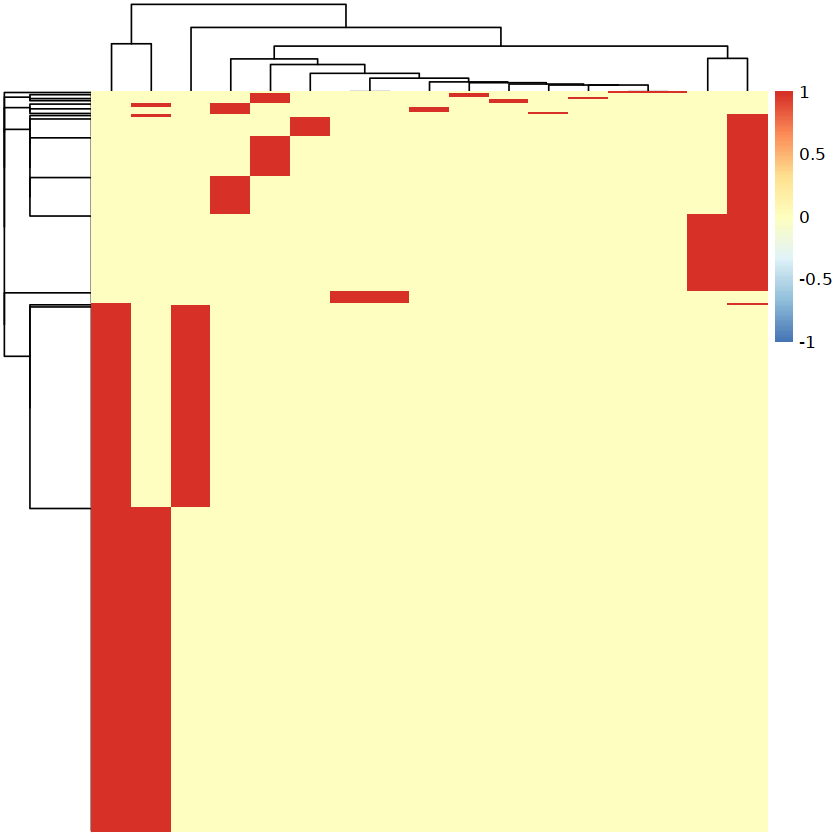

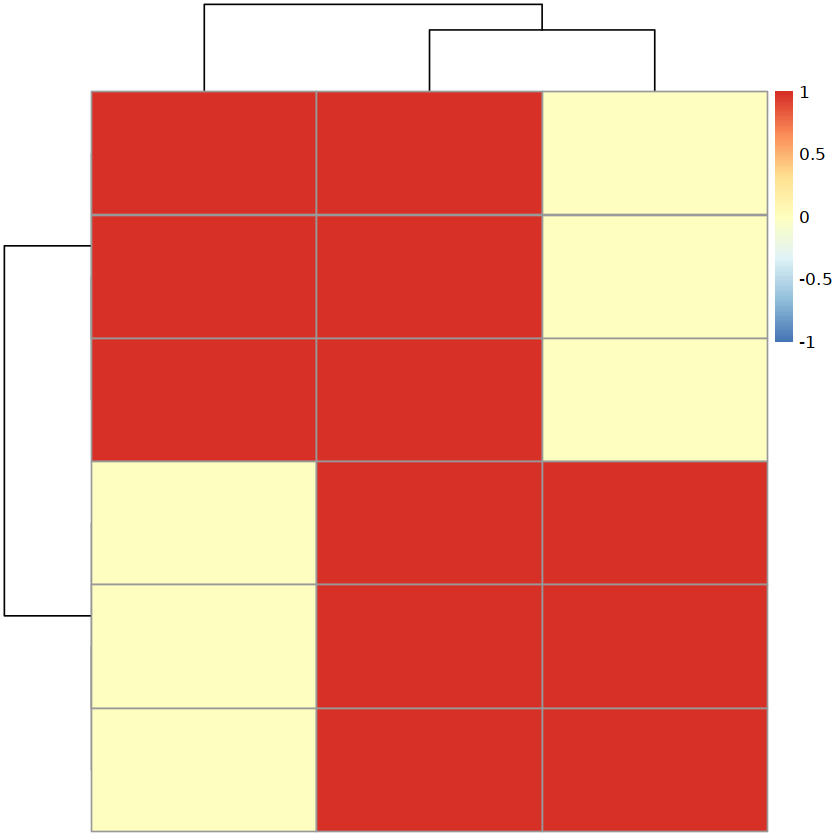

[1] "Adding 2 cells with a single scar to clones."
[1] "Now working on tumour 4 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 131"
[1] "Now working on tumour 2 and gene actb1."
[1] "entries in scar input object for gene actb1: 866"


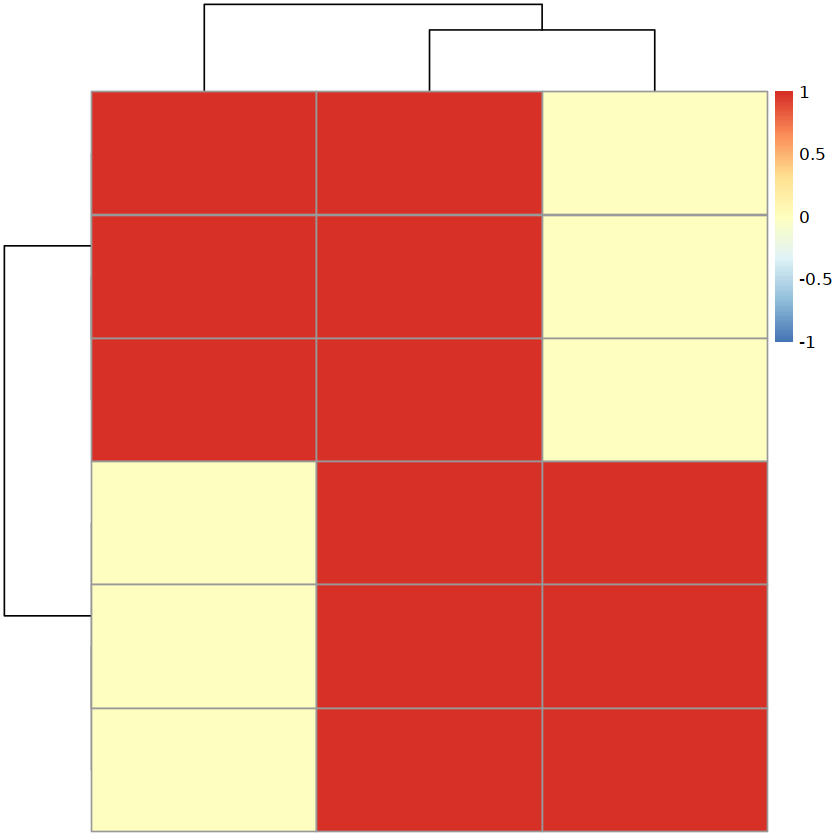

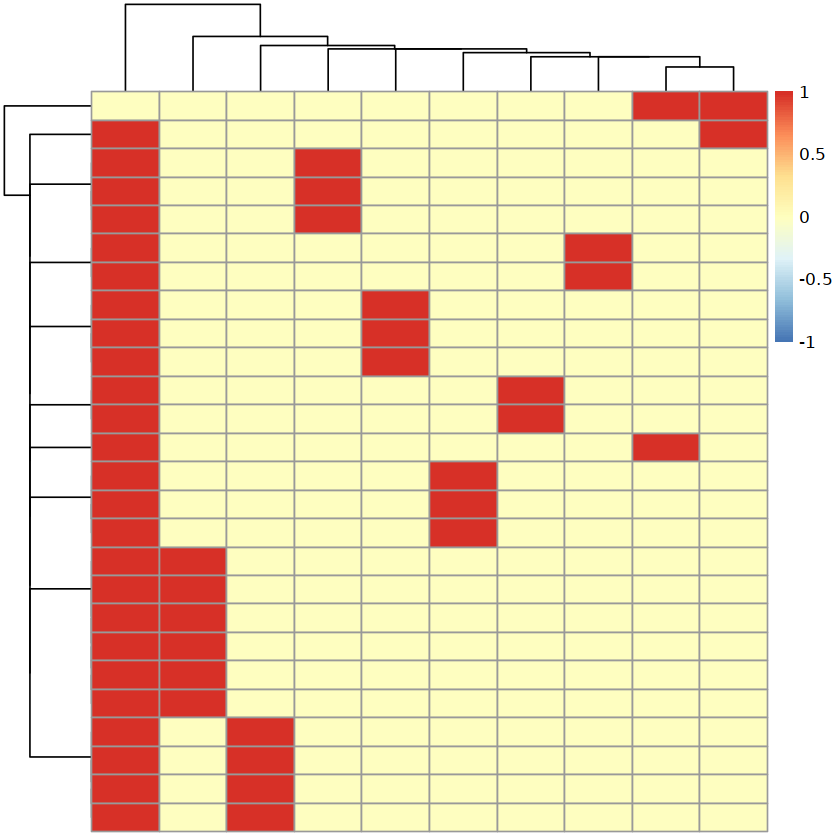

[1] "Adding 1 cells with a single scar to clones."
[1] "Now working on tumour 2 and gene actb2."
[1] "entries in scar input object for gene actb2: 906"


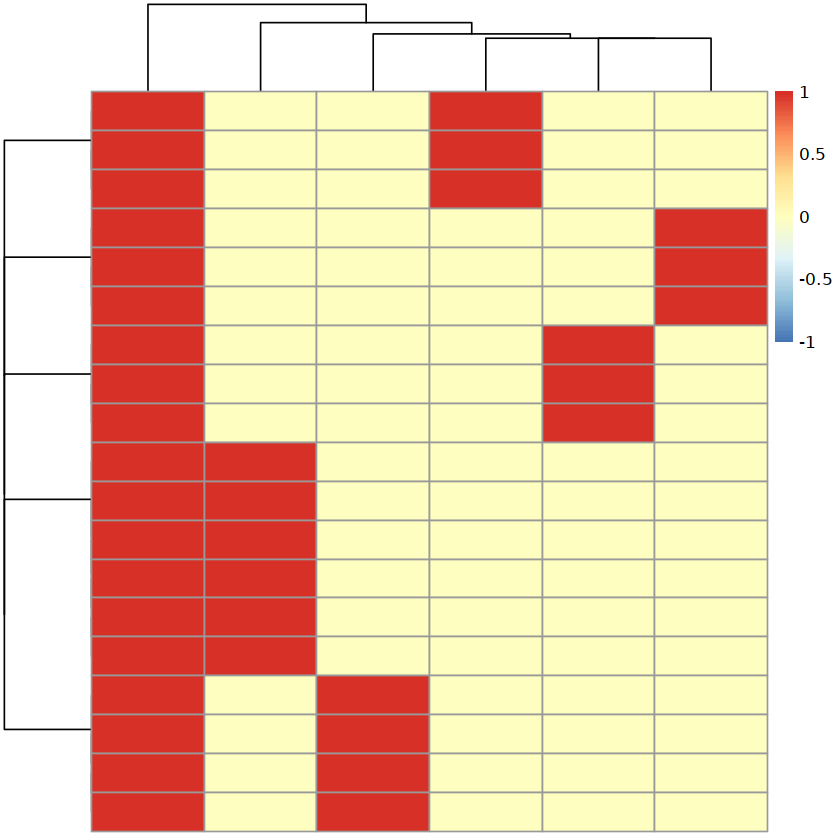

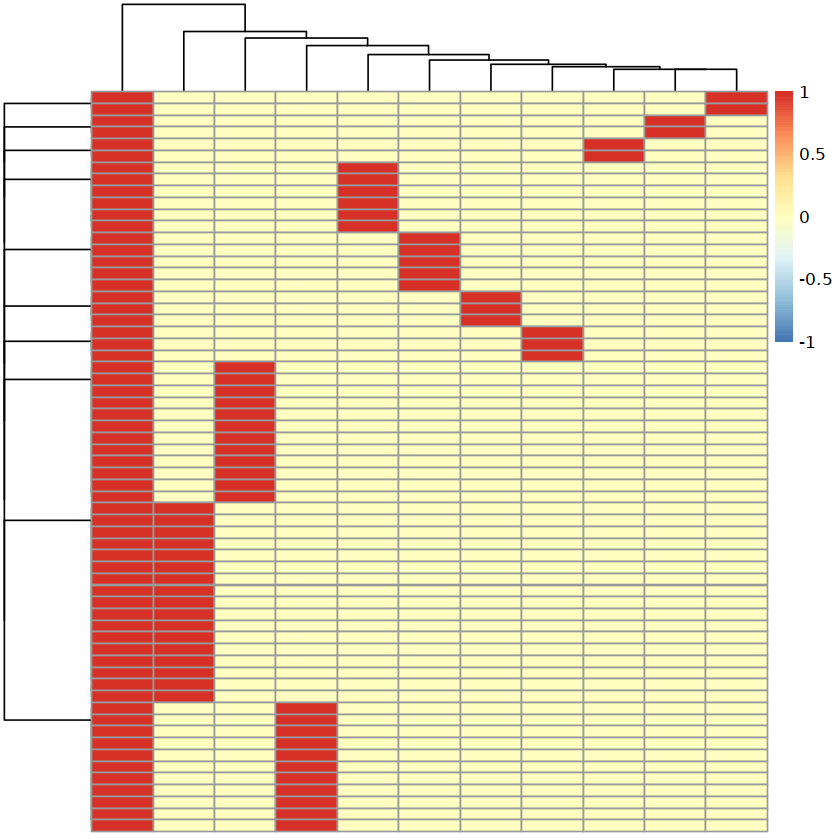

[1] "Now working on tumour 2 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 1751"


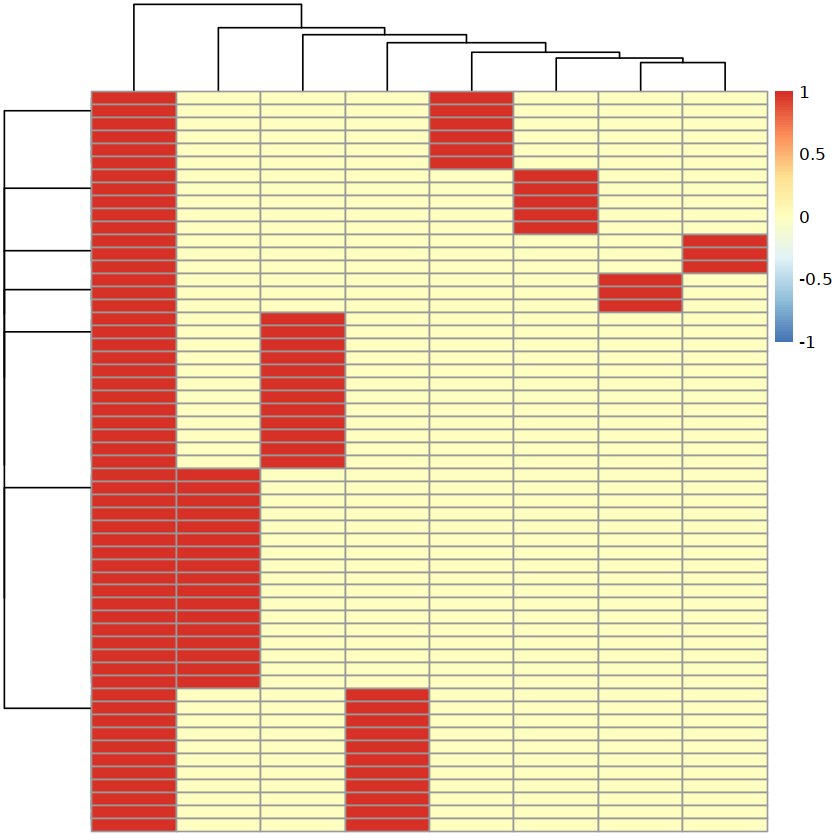

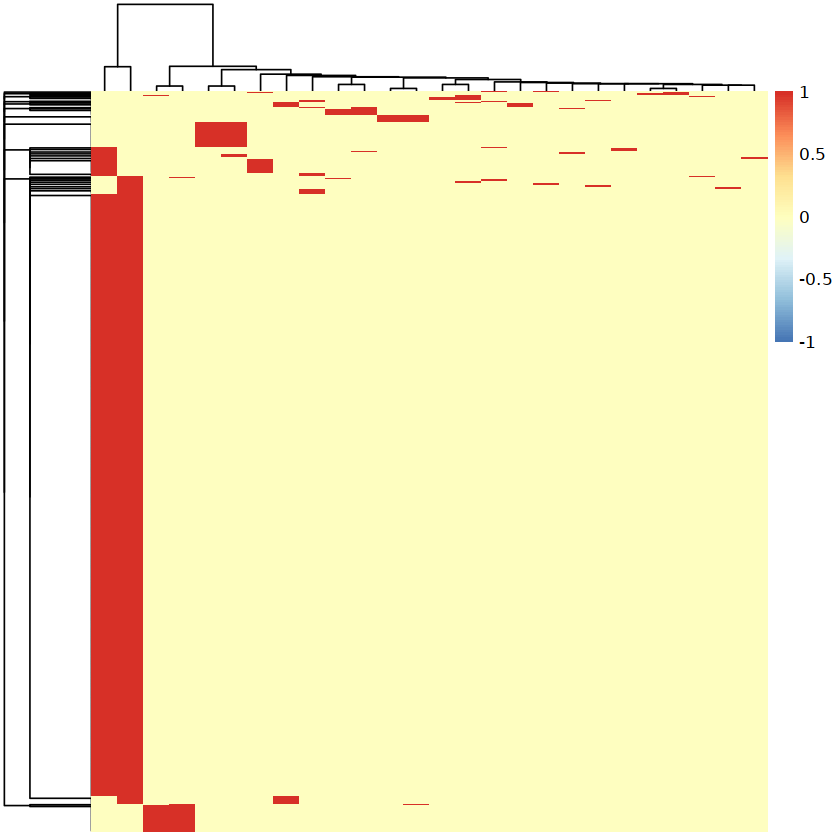

[1] "Now working on tumour 2 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 566"


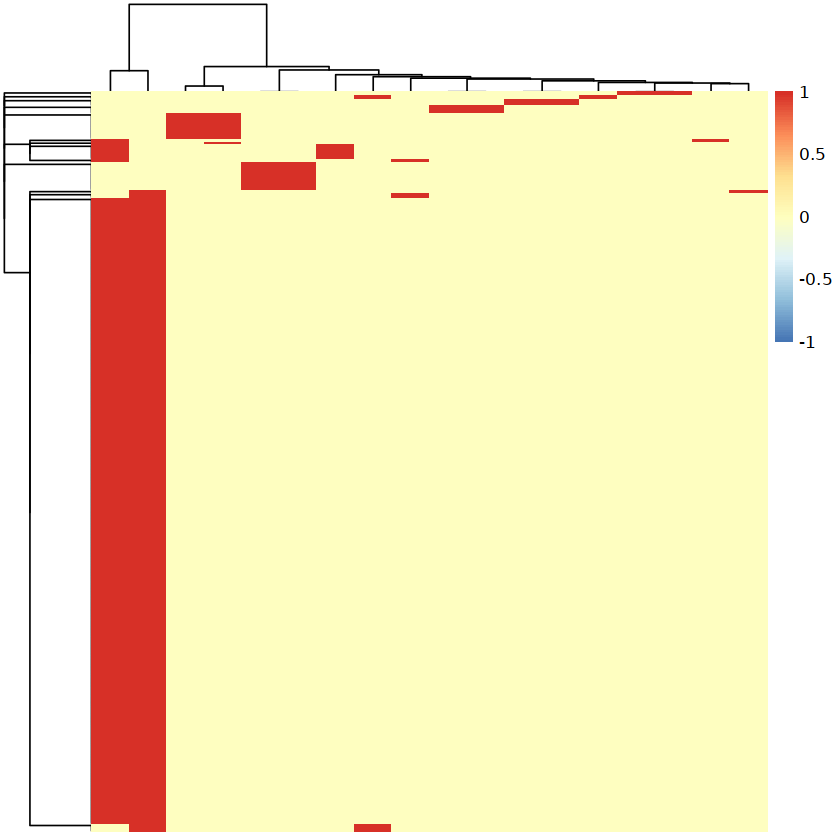

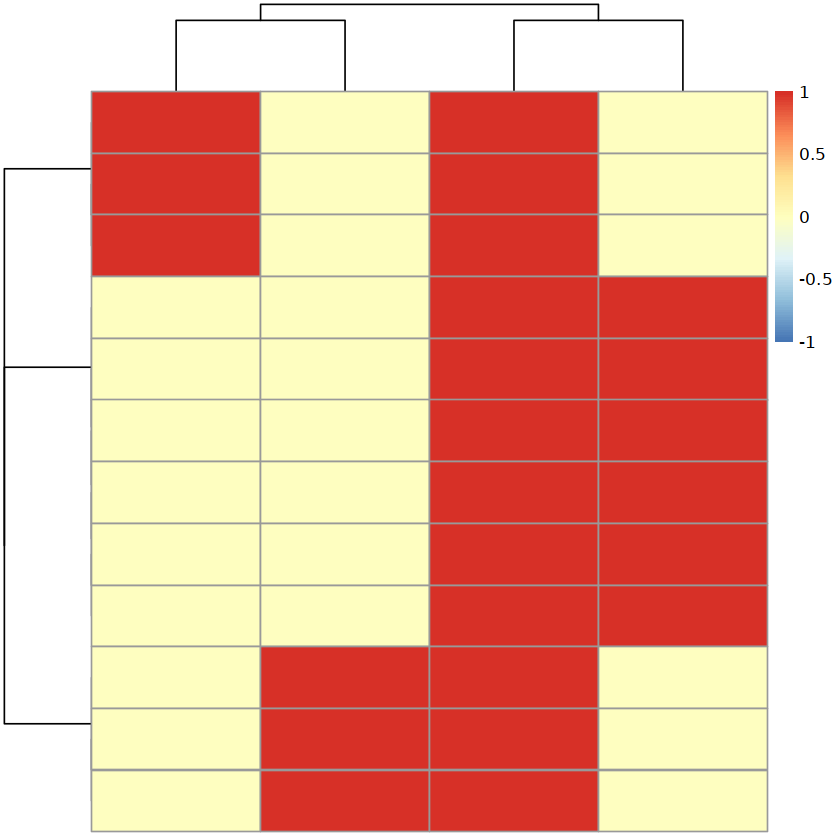

[1] "Now working on tumour 2 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 42"
[1] "Now working on tumour 7 and gene actb1."
[1] "entries in scar input object for gene actb1: 856"


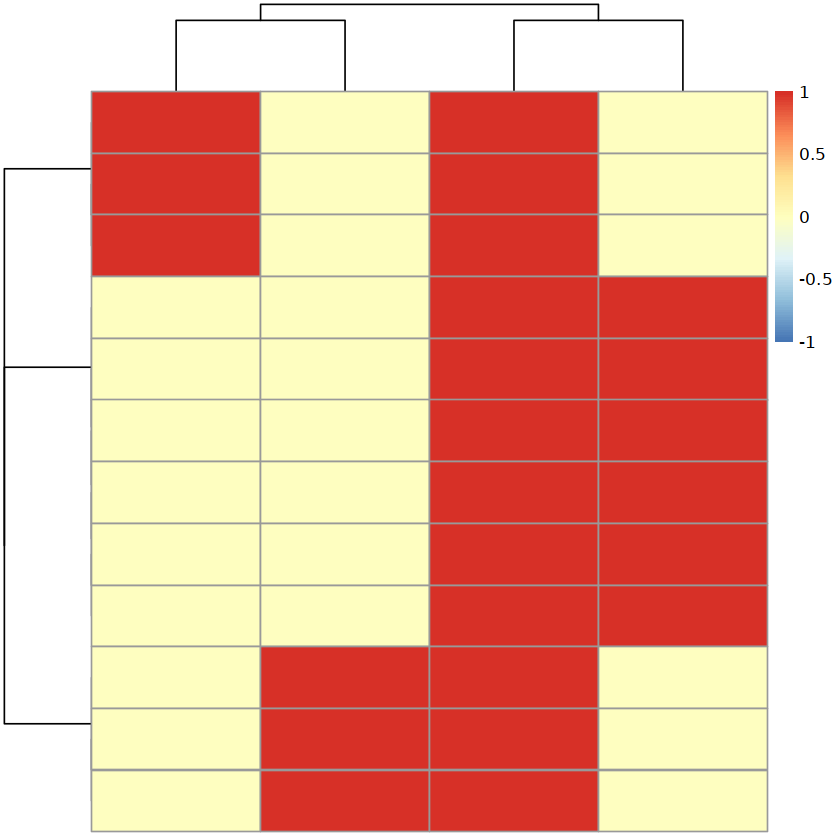

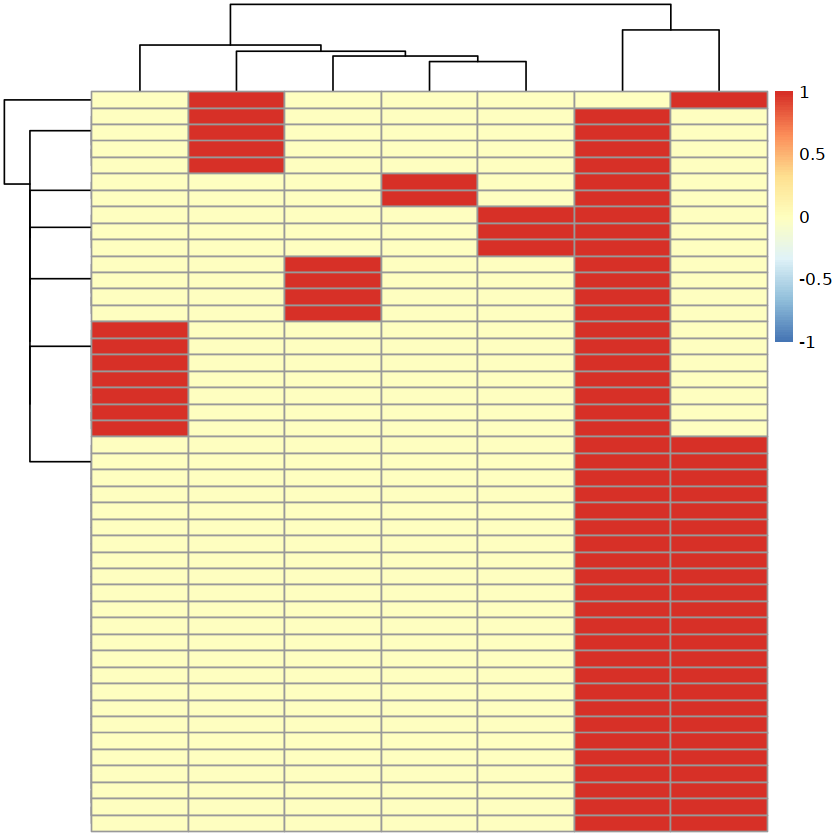

[1] "Adding 145 cells with a single scar to clones."
[1] "Now working on tumour 7 and gene actb2."
[1] "entries in scar input object for gene actb2: 1304"


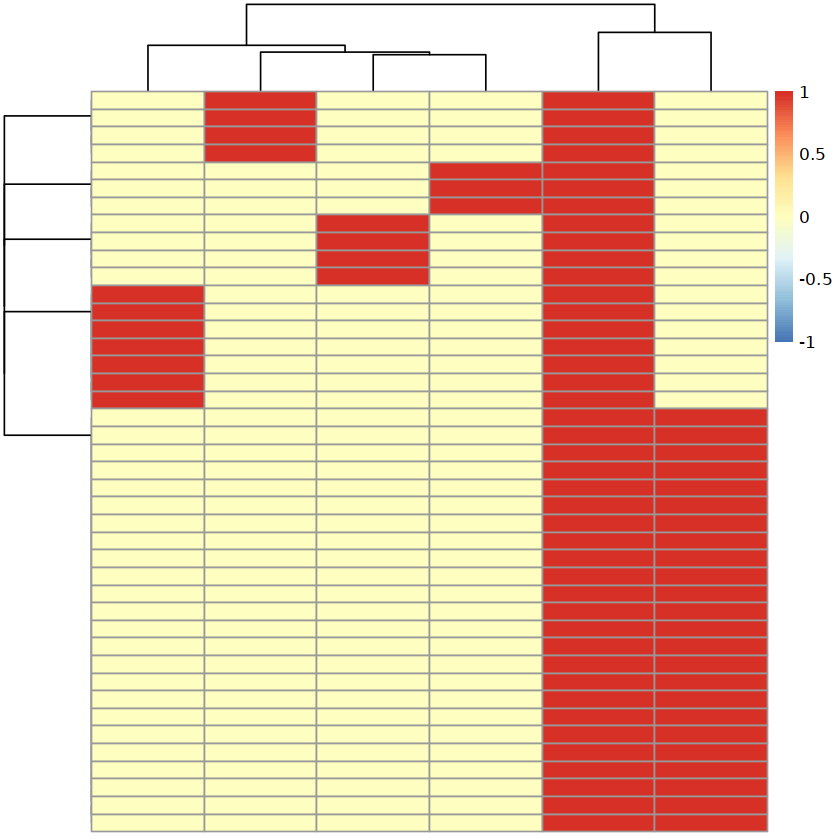

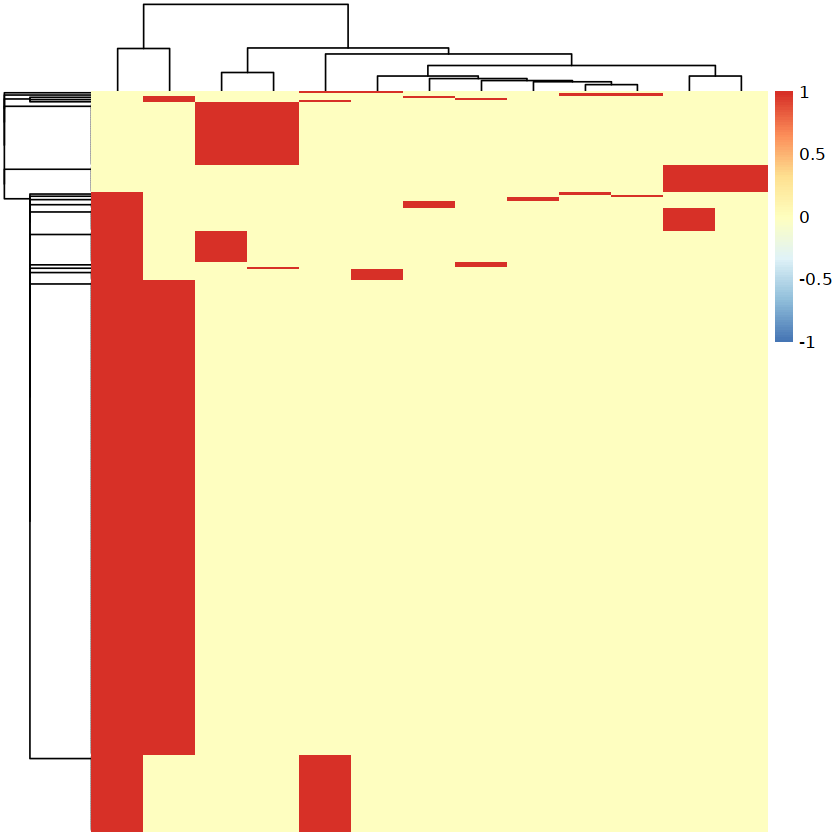

[1] "Adding 46 cells with a single scar to clones."
[1] "Now working on tumour 7 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 2016"


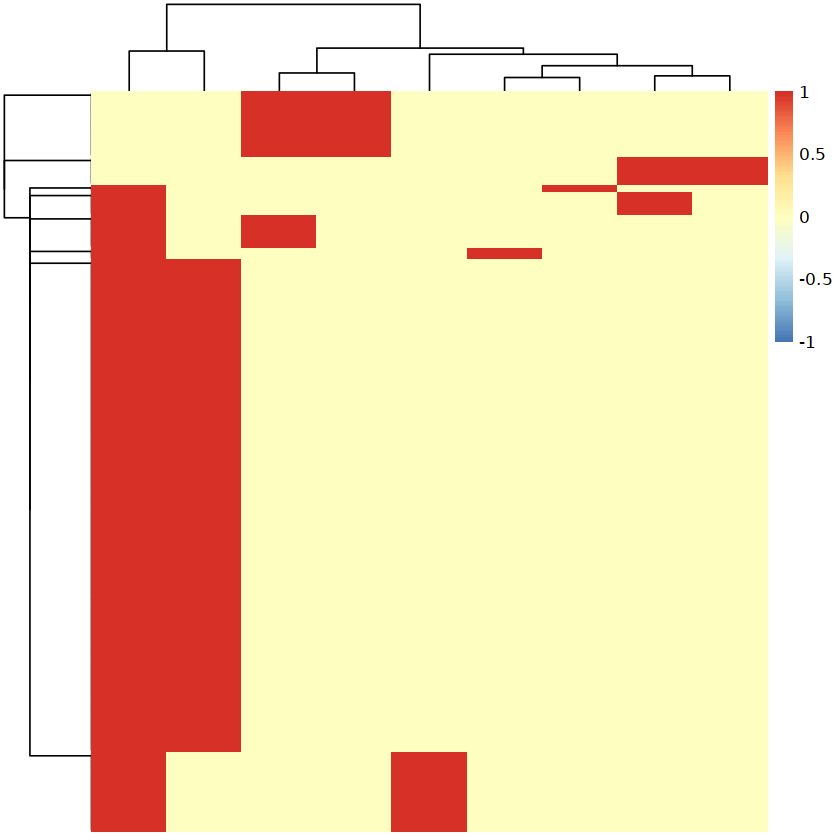

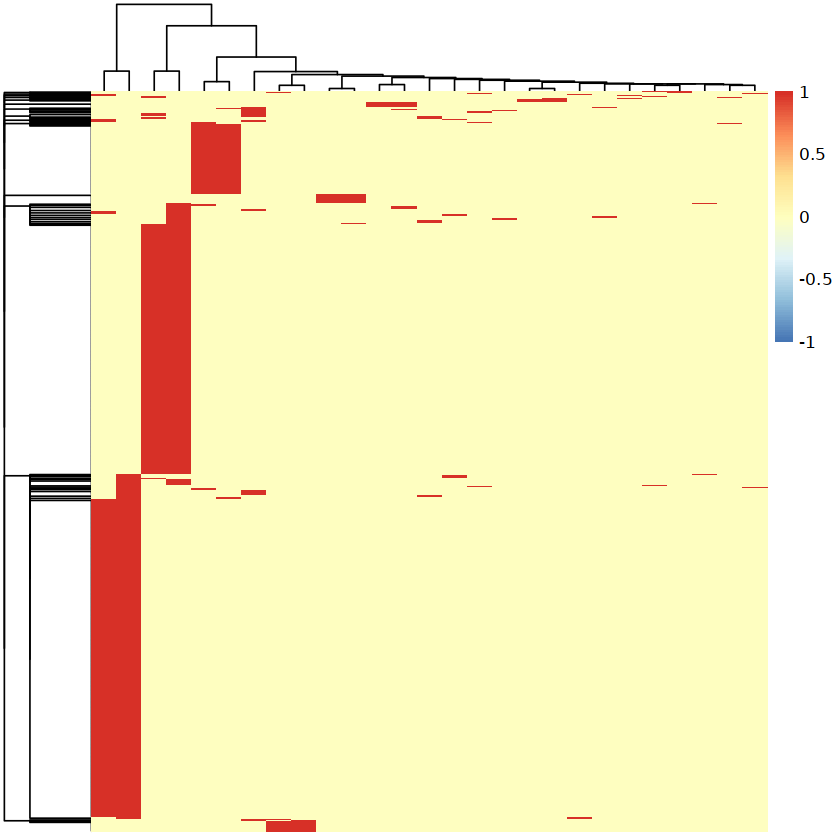

[1] "Adding 9 cells with a single scar to clones."
[1] "Now working on tumour 7 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 664"


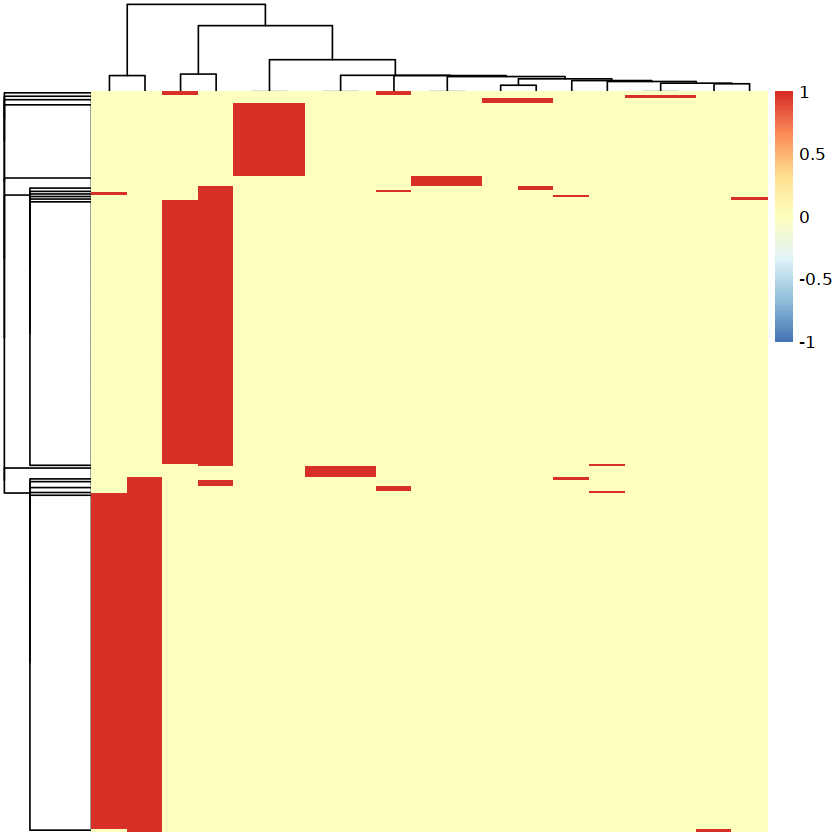

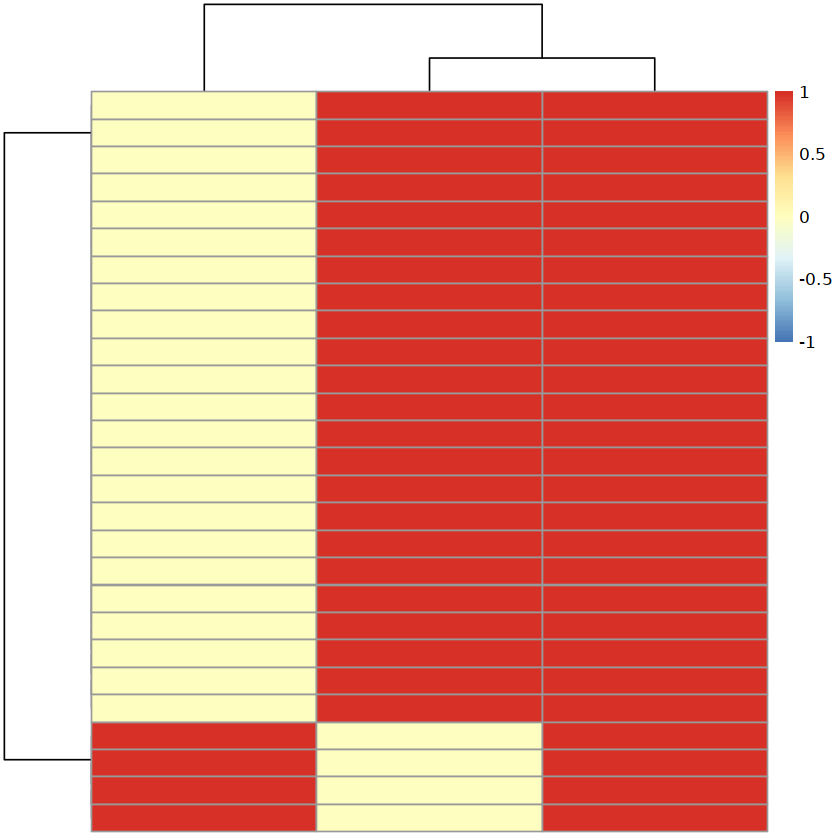

[1] "Adding 9 cells with a single scar to clones."
[1] "Now working on tumour 7 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 69"
[1] "Now working on tumour 5 and gene actb1."
[1] "entries in scar input object for gene actb1: 1242"


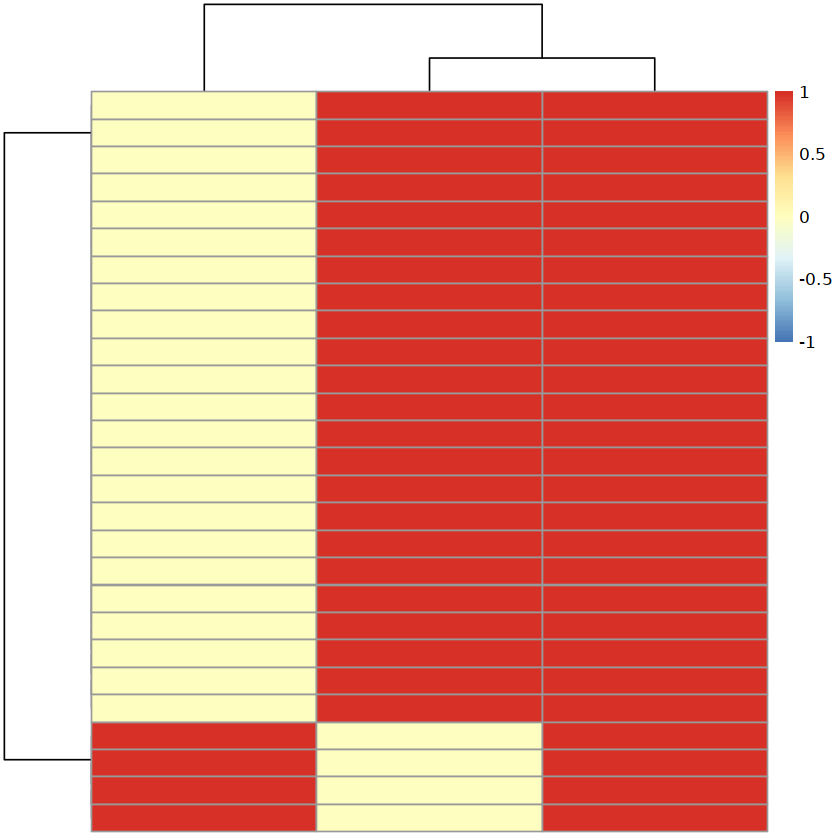

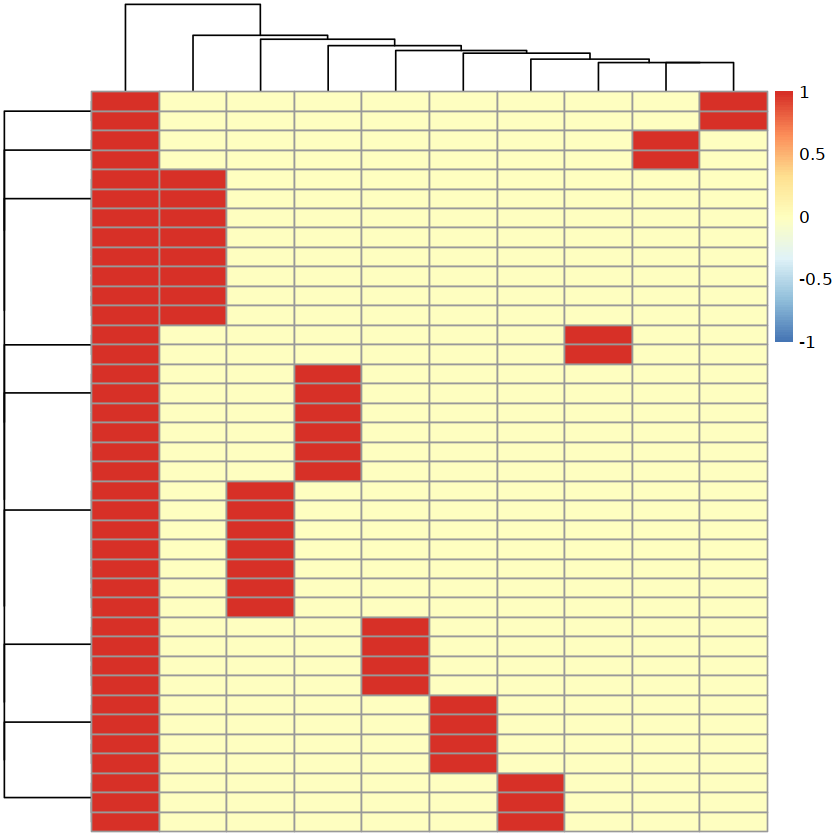

[1] "Adding 1 cells with a single scar to clones."
[1] "Now working on tumour 5 and gene actb2."
[1] "entries in scar input object for gene actb2: 1326"


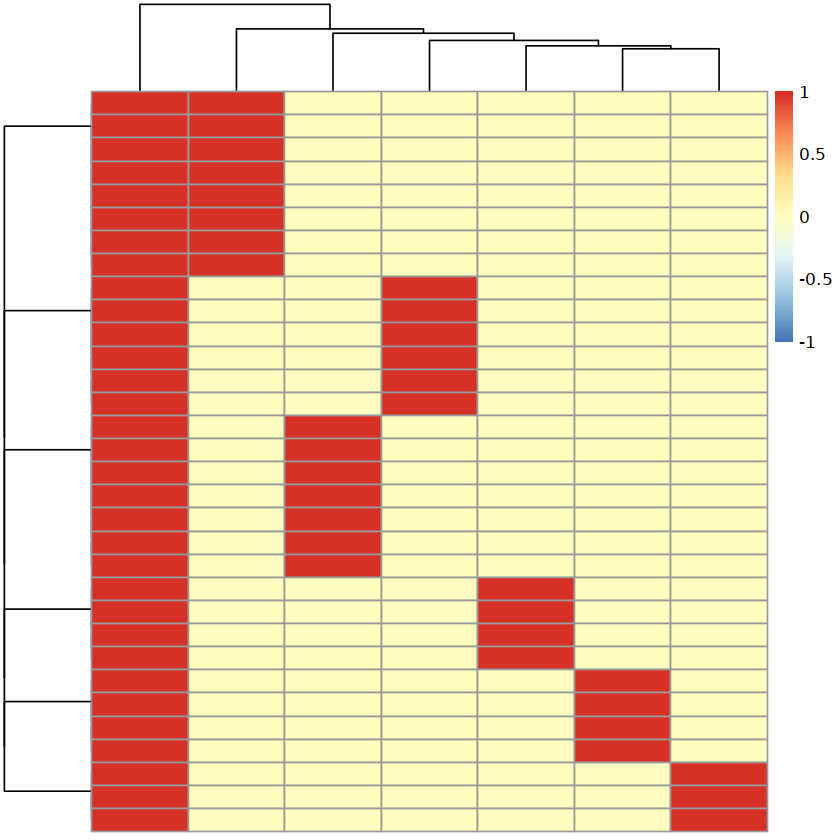

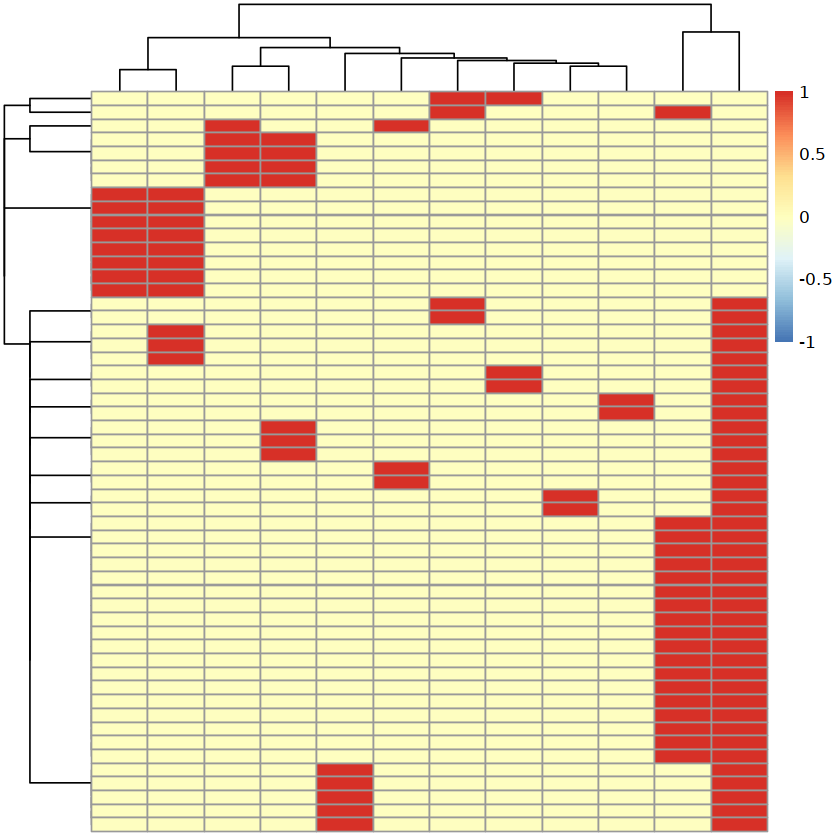

[1] "Adding 3 cells with a single scar to clones."
[1] "Now working on tumour 5 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 1590"


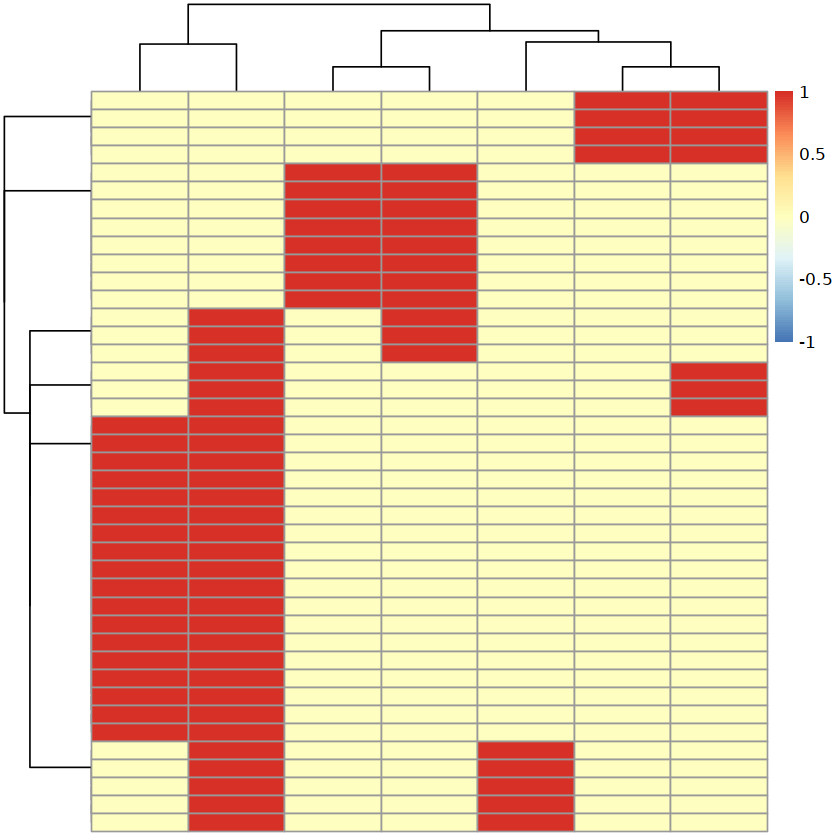

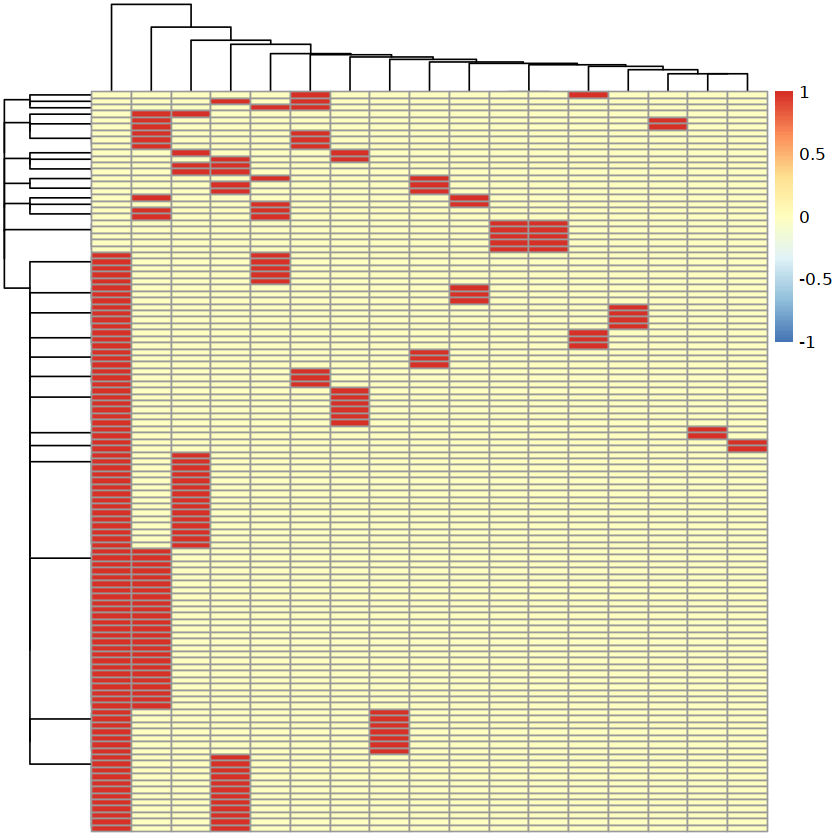

[1] "Adding 3 cells with a single scar to clones."
[1] "Now working on tumour 5 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 1078"
[1] "Now working on tumour 5 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 334"
[1] "Now working on tumour 8 and gene actb1."
[1] "entries in scar input object for gene actb1: 336"


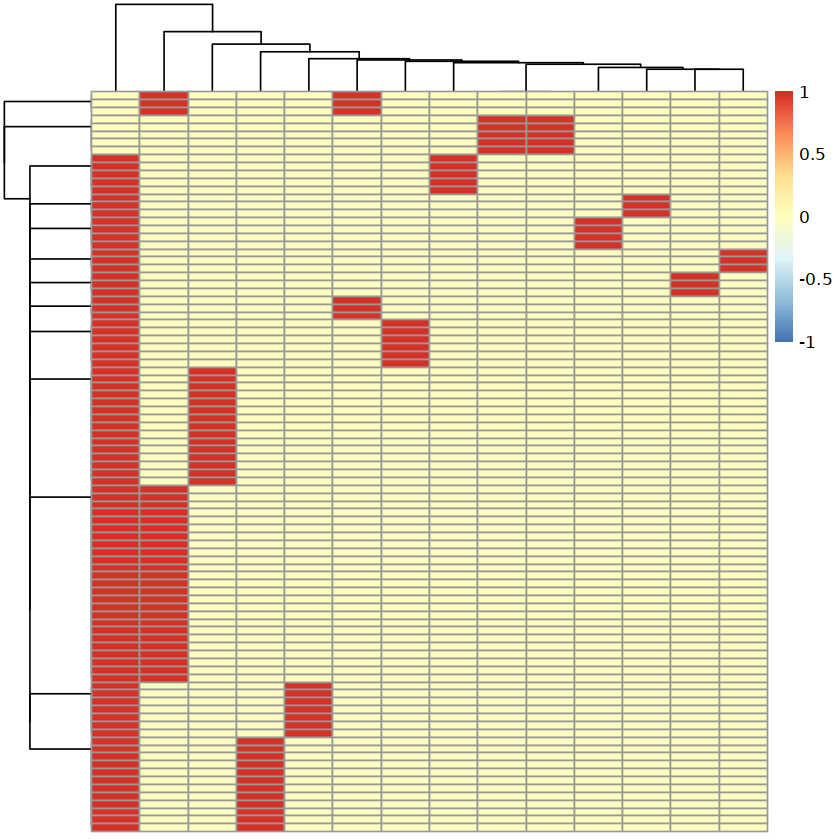

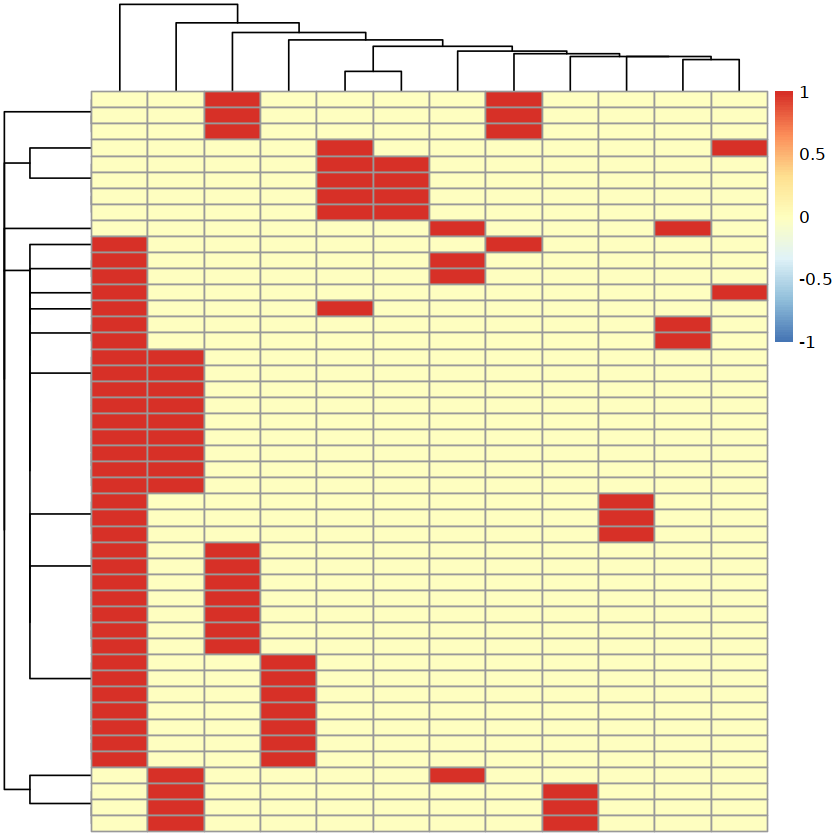

[1] "Now working on tumour 8 and gene actb2."
[1] "entries in scar input object for gene actb2: 442"


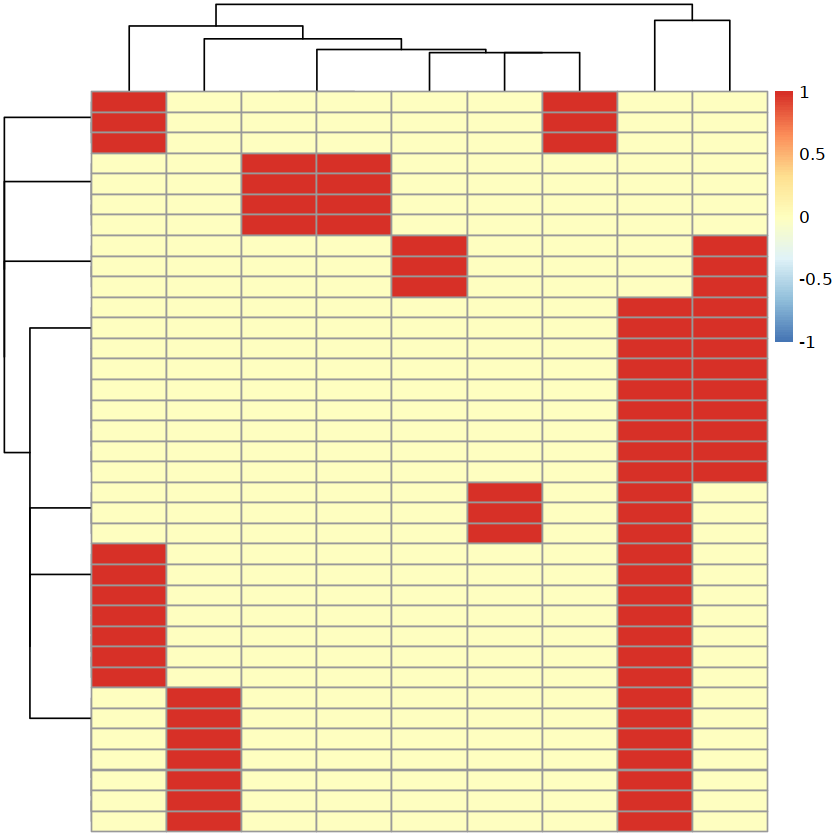

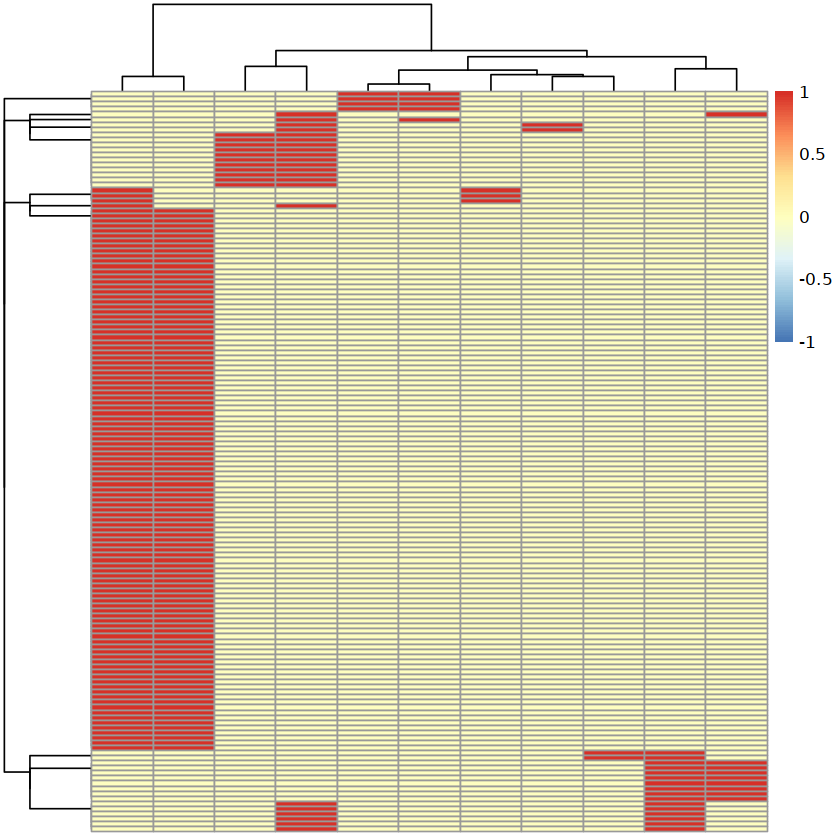

[1] "Adding 12 cells with a single scar to clones."
[1] "Now working on tumour 8 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 619"


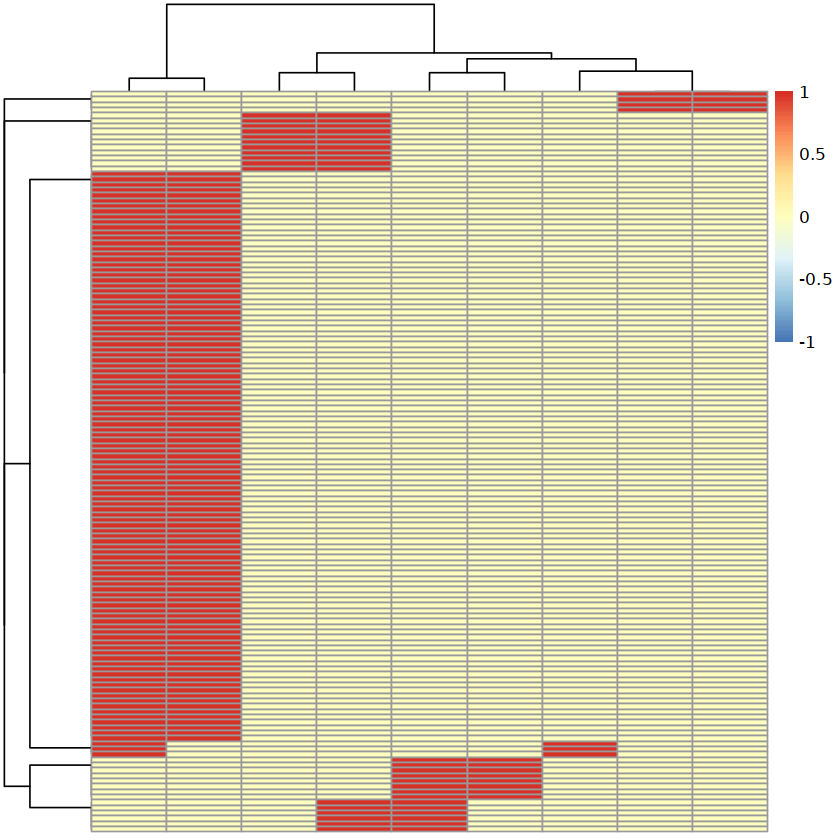

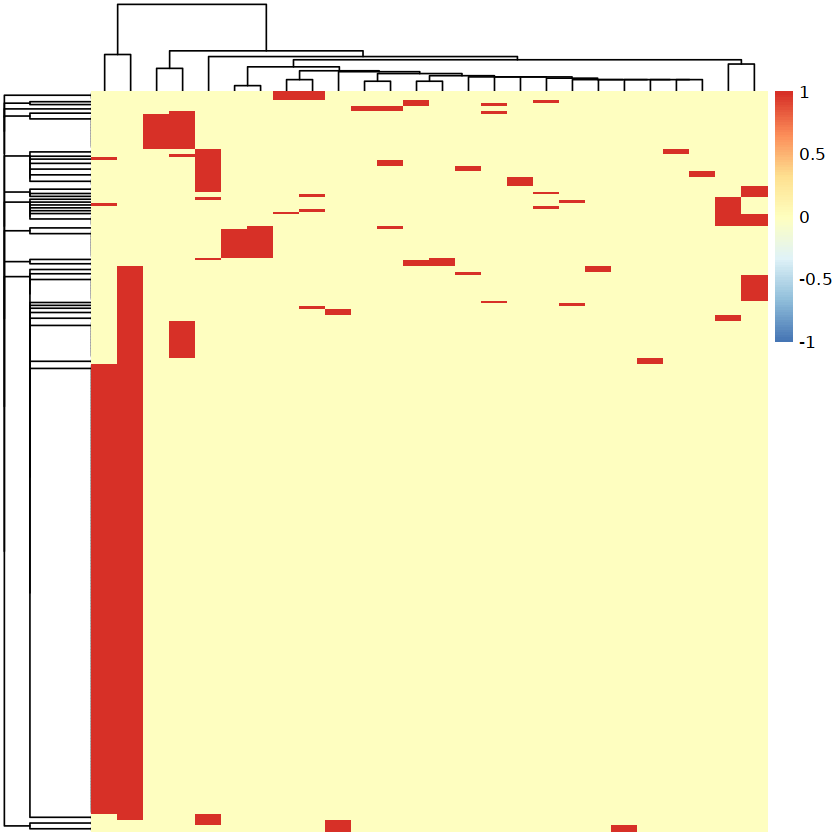

[1] "Adding 4 cells with a single scar to clones."
[1] "Now working on tumour 8 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 211"


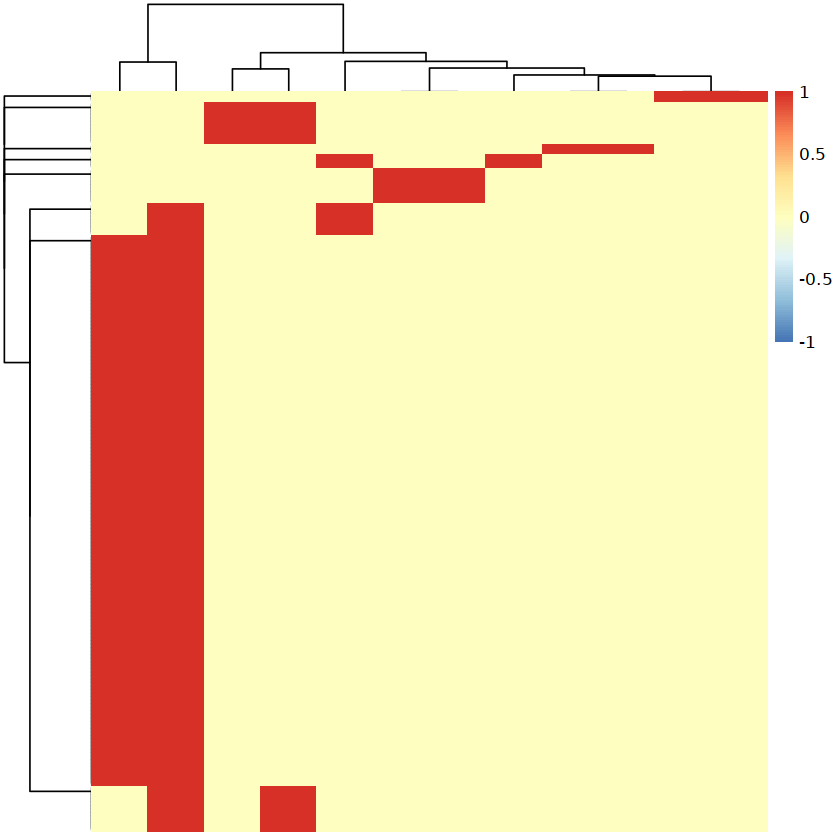

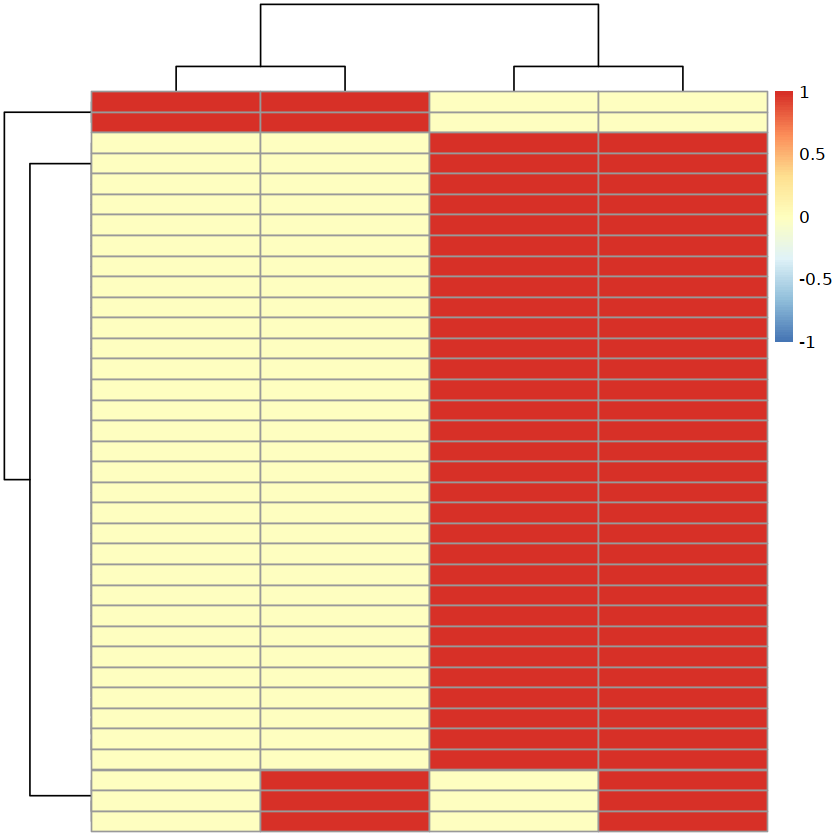

[1] "Adding 1 cells with a single scar to clones."
[1] "Now working on tumour 8 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 56"
[1] "Now working on tumour 1 and gene actb1."
[1] "entries in scar input object for gene actb1: 785"


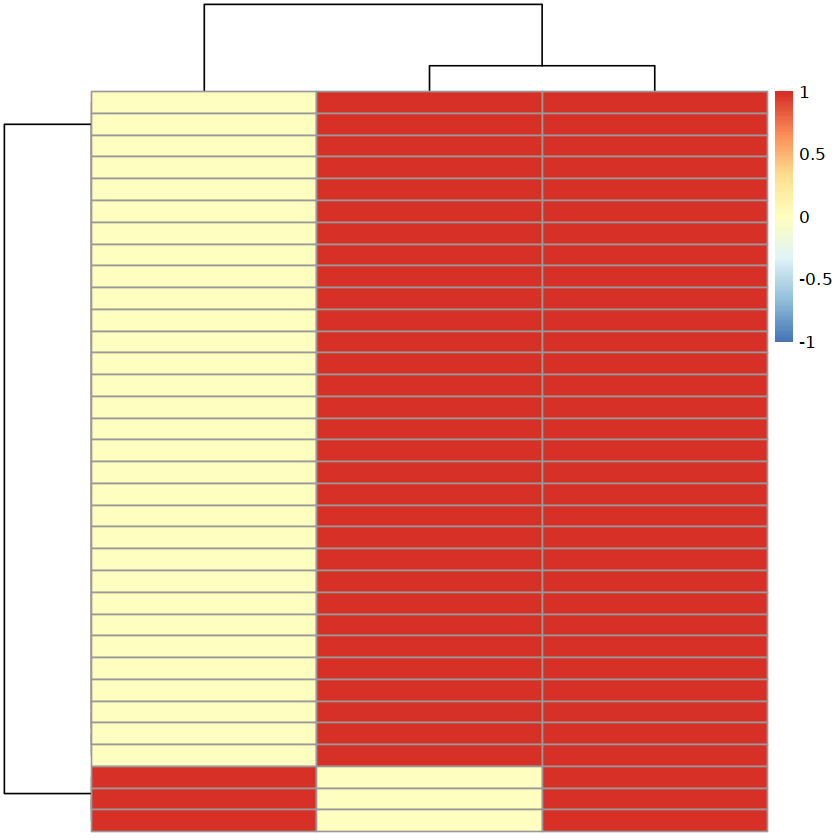

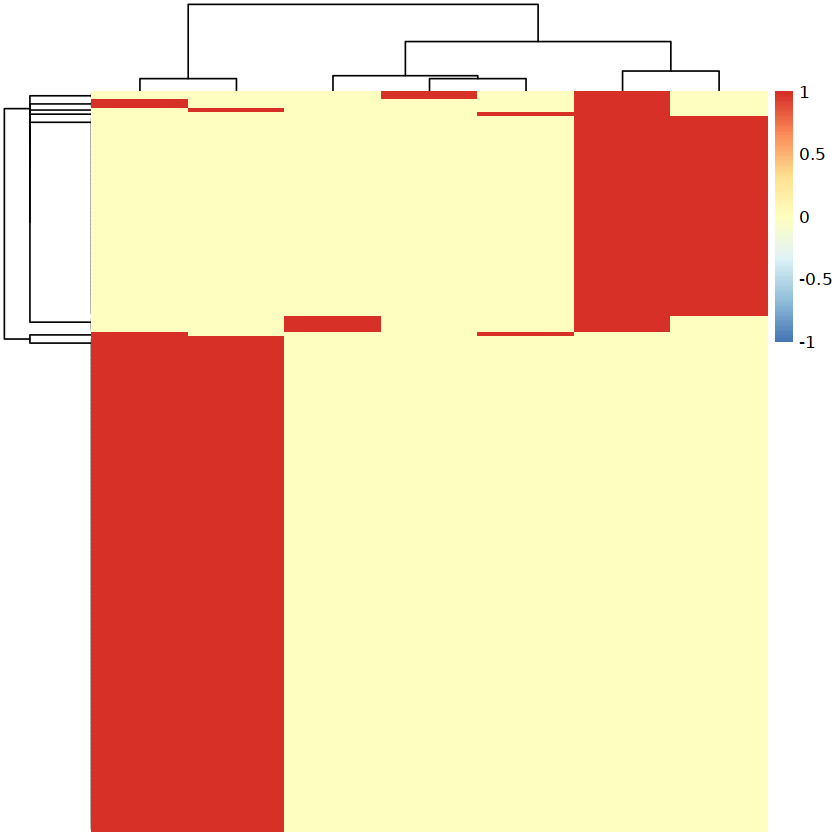

[1] "Adding 4 cells with a single scar to clones."
[1] "Now working on tumour 1 and gene actb2."
[1] "entries in scar input object for gene actb2: 1037"


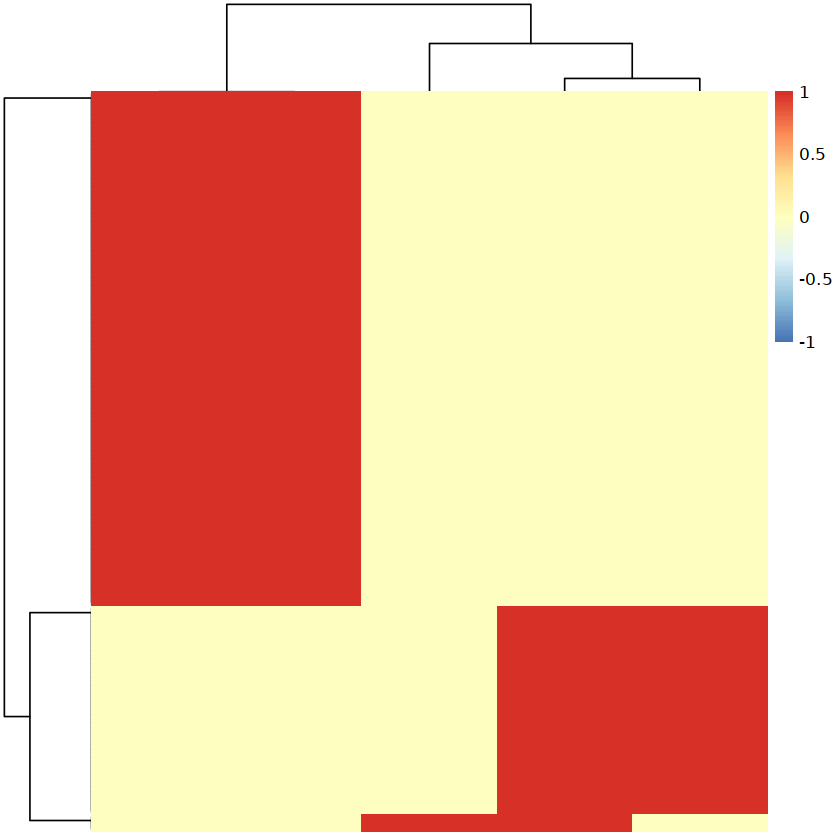

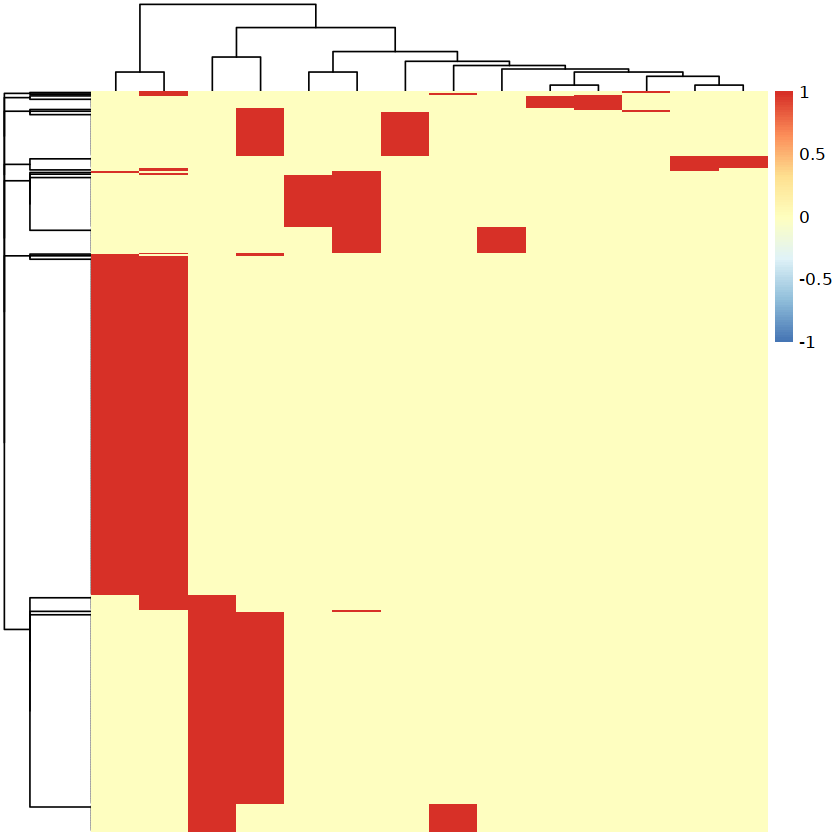

[1] "Adding 11 cells with a single scar to clones."
[1] "Now working on tumour 1 and gene rpl39."
[1] "entries in scar input object for gene rpl39: 837"


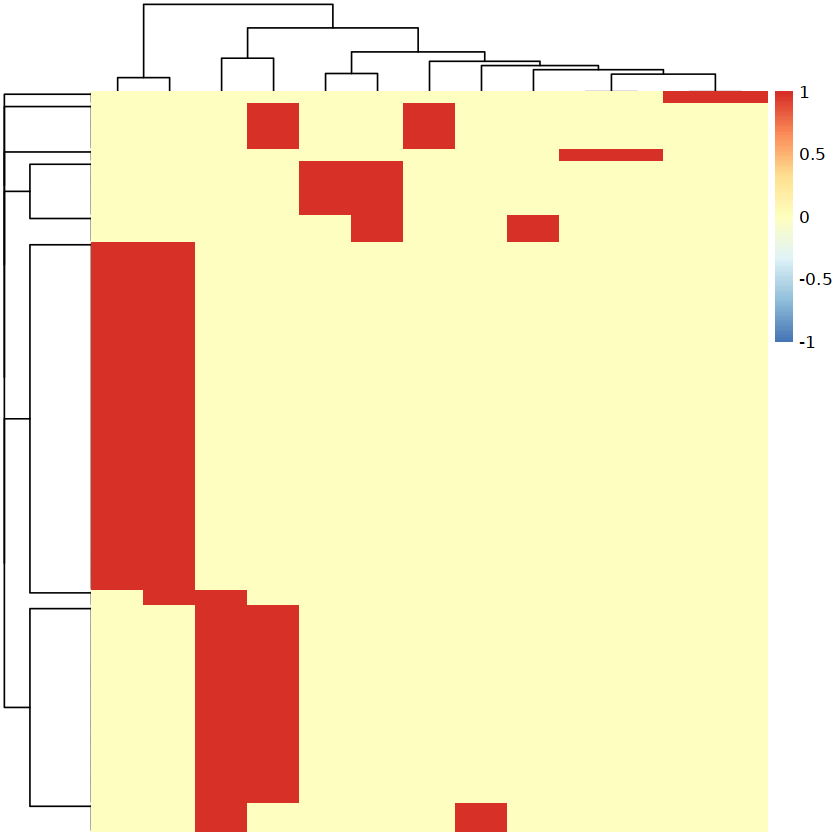

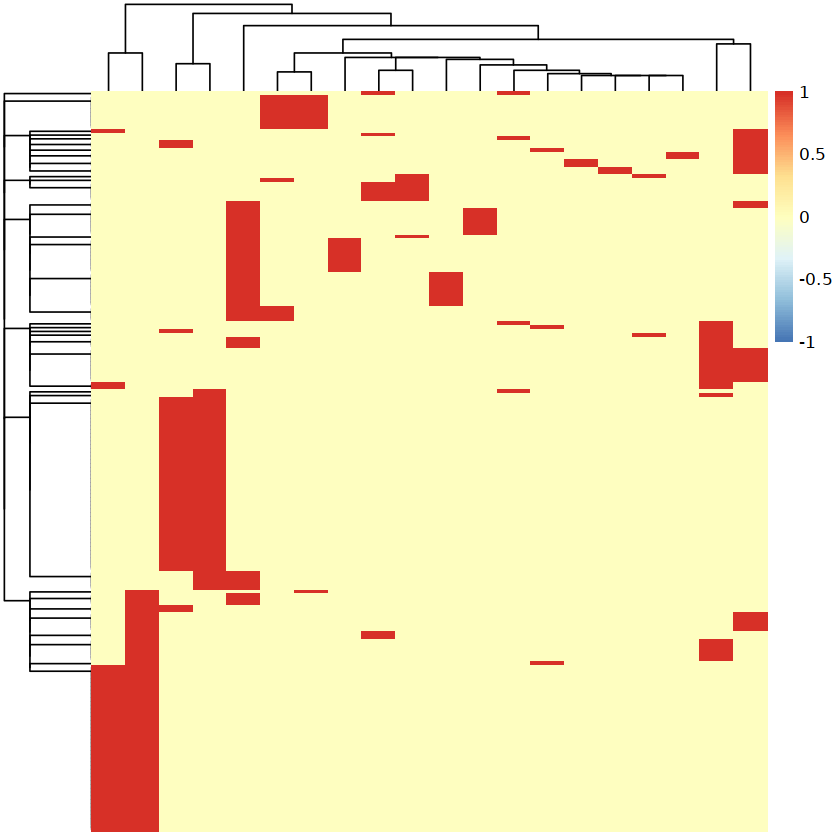

[1] "Adding 3 cells with a single scar to clones."
[1] "Now working on tumour 1 and gene cfl1."
[1] "entries in scar input object for gene cfl1: 521"


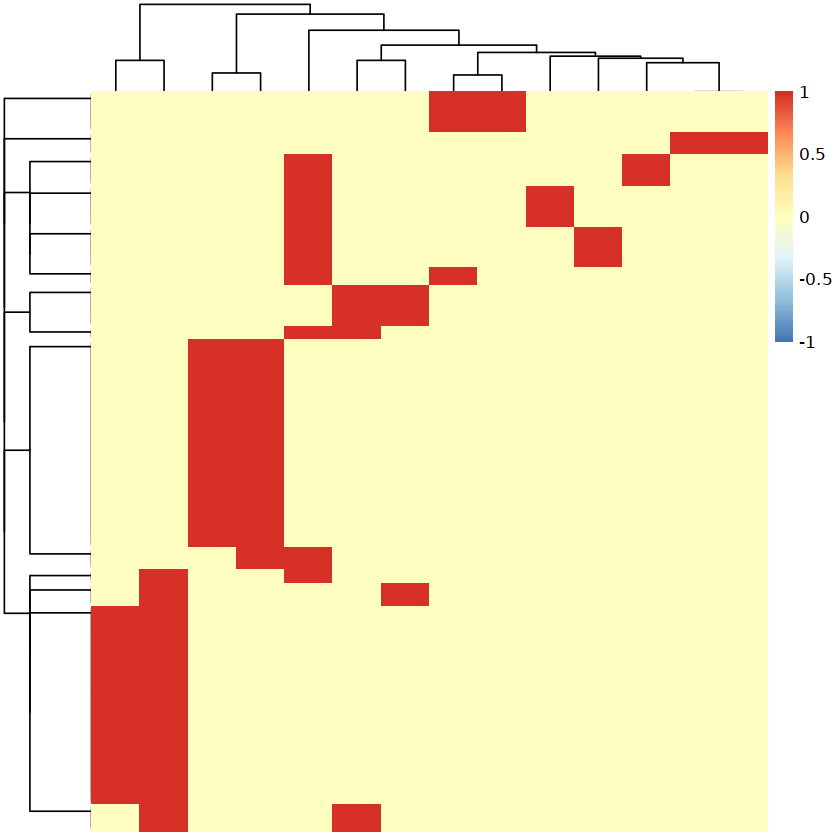

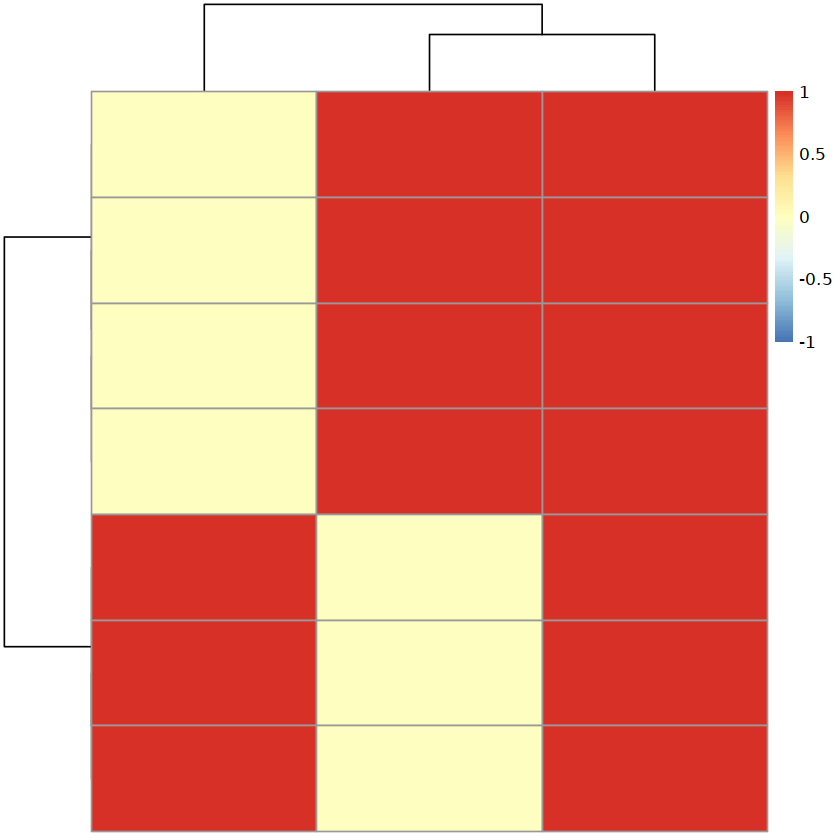

[1] "Adding 1 cells with a single scar to clones."
[1] "Now working on tumour 1 and gene rpl18a."
[1] "entries in scar input object for gene rpl18a: 46"


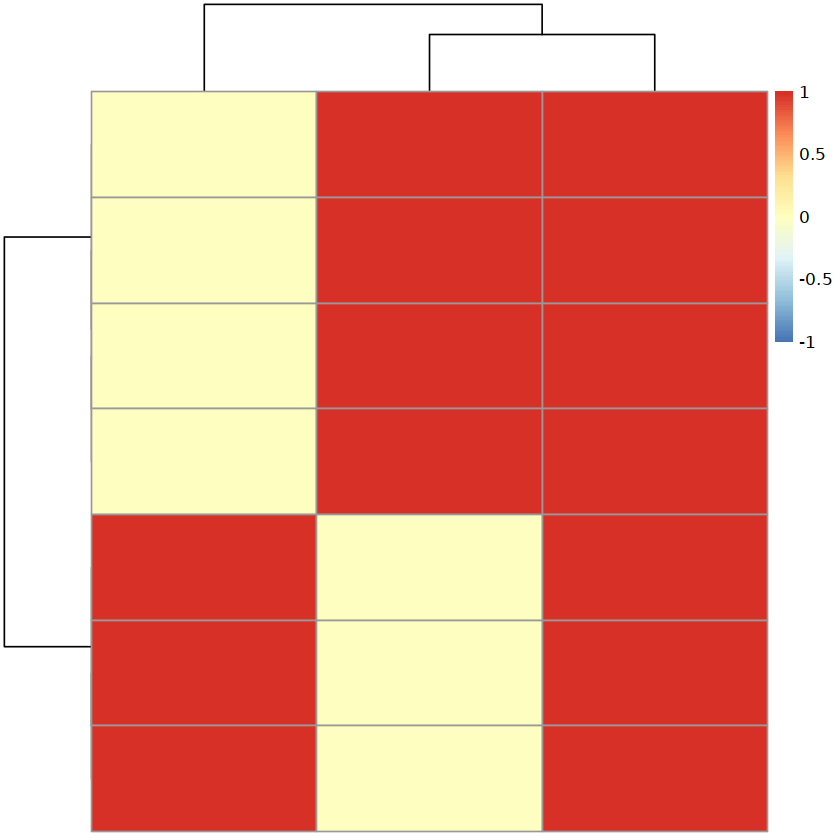

In [20]:
# Run functions. Output will be printed to file:
getclones(dat_wd = dat_wd,
          dat_name = dat_name,
          seq_id_delim = seq_id_delim,
          wt_seq_ids = wt_seq_ids,
          heatmap_after_initial_filt = T,
          heatmap_after_final_filt = T,
          cooc_fraction_cutoff = cooc_fraction_cutoff,
          seur_dat = seur_dat,
          tums_list = tums_list,
          genes_list = genes_list,
          scar_file_name = scar_file_name)

The following steps are optional. The output produced by 'getclones' above is the most robust and is best used for downstream clone calling.  
However, the below steps are useful for quality checks or to use in downstream clone calling, if the lineage data is lower quality / lineage barcode introduction was not efficient.

In [21]:
# Optional: Find cells that likely have two unedited alleles on a given gene and flag them as wildtype.
addwtclones(dat_wd = dat_wd,
            dat_name = dat_name,
            seq_id_delim = seq_id_delim,
            wt_seq_ids = wt_seq_ids,
            cooc_fraction_cutoff = cooc_fraction_cutoff,
            seur_dat = seur_dat,
            tums_list = tums_list,
            genes_list = genes_list)

[1] "all,actb1"
[1] "entries in scar input object for gene actb1: 8507"
[1] "add WT seqs"
[1] "all,actb2"
[1] "entries in scar input object for gene actb2: 10548"
[1] "add WT seqs"
[1] "all,rpl39"
[1] "entries in scar input object for gene rpl39: 14746"
[1] "add WT seqs"
[1] "all,cfl1"
[1] "entries in scar input object for gene cfl1: 6247"
[1] "add WT seqs"
[1] "all,rpl18a"
[1] "entries in scar input object for gene rpl18a: 926"
[1] "add WT seqs"
[1] "3,actb1"
[1] "entries in scar input object for gene actb1: 2163"
[1] "add WT seqs"
[1] "3,actb2"
[1] "entries in scar input object for gene actb2: 2642"
[1] "add WT seqs"
[1] "3,rpl39"
[1] "entries in scar input object for gene rpl39: 4013"
[1] "add WT seqs"
[1] "3,cfl1"
[1] "entries in scar input object for gene cfl1: 1656"
[1] "add WT seqs"
[1] "3,rpl18a"
[1] "entries in scar input object for gene rpl18a: 218"
[1] "add WT seqs"
[1] "6,actb1"
[1] "entries in scar input object for gene actb1: 953"
[1] "add WT seqs"
[1] "6,actb2"
[1] "entr

In [22]:
# Optional: Find cells that likely have only one detectable allele or the same edit on both alleles.
addonescarclones(dat_wd = dat_wd,
                dat_name = dat_name,
                seq_id_delim = seq_id_delim,
                wt_seq_ids = wt_seq_ids,
                cooc_fraction_cutoff = cooc_fraction_cutoff,
                seur_dat = seur_dat,
                tums_list = tums_list,
                genes_list = genes_list)

[1] "entries in scar input object for gene actb1: 8507"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene actb2: 10548"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene rpl39: 14746"
[1] "adding single scar clones for rpl39"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene cfl1: 6247"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene rpl18a: 926"
[1] "adding single scar clones for rpl18a"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene actb1: 2163"
[1] "adding single scar clones for actb1"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene actb2: 2642"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene rpl39: 4013"
[1] "adding single scar clones for rpl39"
[1] "Adding cells with only one scar"
[1] "e

Warning message in colnames(scar.input.1scar) == colnames(scars_1):
“longer object length is not a multiple of shorter object length”


[1] "Previous warning about ncol inequality can be ignored. Since there were no lineage barcode based clones, only the newly found single allele cells will contribute to the output."
[1] "No two-allele based clones were previously found, but there are some single-allele clones"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene actb1: 1306"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene actb2: 1870"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene rpl39: 2466"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene cfl1: 912"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene rpl18a: 131"
[1] "adding single scar clones for rpl18a"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene actb1: 866"
[1] "No additional clone-level single scars w

Warning message in colnames(scar.input.1scar) == colnames(scars_1):
“longer object length is not a multiple of shorter object length”


[1] "Previous warning about ncol inequality can be ignored. Since there were no lineage barcode based clones, only the newly found single allele cells will contribute to the output."
[1] "No two-allele based clones were previously found, but there are some single-allele clones"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene actb1: 856"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene actb2: 1304"
[1] "adding single scar clones for actb2"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene rpl39: 2016"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene cfl1: 664"
[1] "No additional clone-level single scars were found"
[1] "entries in scar input object for gene rpl18a: 69"
[1] "adding single scar clones for rpl18a"
[1] "Adding cells with only one scar"
[1] "entries in scar input object for gene actb1: 1242"
[1] "No additional clo

Warning message in colnames(scar.input.1scar) == colnames(scars_1):
“longer object length is not a multiple of shorter object length”


[1] "Previous warning about ncol inequality can be ignored. Since there were no lineage barcode based clones, only the newly found single allele cells will contribute to the output."
[1] "No two-allele based clones were previously found, but there are some single-allele clones"
[1] "Adding cells with only one scar"


In [23]:
# Optional: Group cells based on a more lenient cut-off regarding ambiguity in seq-ID pairing.
getclones_uncert(dat_wd = dat_wd,
                  dat_name = dat_name,
                  seq_id_delim = seq_id_delim,
                  wt_seq_ids = wt_seq_ids,
                  heatmap_after_initial_filt = F,
                  heatmap_after_final_filt = F,
                  cooc_fraction_cutoff = 0.8, # insert cut-off used for the first steps here
                  cooc_fraction_cutoff_uncert = 0.6, # choose a more lenient cut-off for finding more uncertain clones. Setting a much lower threshold than for getclones is recommended!
                  seur_dat = seur_dat,
                  tums_list = tums_list,
                  genes_list = genes_list)

[1] "Now working on tumour all and gene actb1"
[1] "entries in scar input object for gene actb1: 8507"
[1] "No additional allele-pairs could be found."
[1] "Now working on tumour all and gene actb2"
[1] "entries in scar input object for gene actb2: 10548"
[1] "adding loosely filtered two-scar clones clones for actb2"
[1] "Now working on tumour all and gene rpl39"
[1] "entries in scar input object for gene rpl39: 14746"
[1] "Now working on tumour all and gene cfl1"
[1] "entries in scar input object for gene cfl1: 6247"
[1] "No additional allele-pairs could be found."
[1] "Now working on tumour all and gene rpl18a"
[1] "entries in scar input object for gene rpl18a: 926"
[1] "No additional allele-pairs could be found."
[1] "Now working on tumour 3 and gene actb1"
[1] "entries in scar input object for gene actb1: 2163"
[1] "No additional allele-pairs could be found."
[1] "Now working on tumour 3 and gene actb2"
[1] "entries in scar input object for gene actb2: 2642"
[1] "Now working on tum

## dsRedRecCas (transgene) filtering and pre-processing

In [24]:
# Pre-process scar output files: merge with succesful whole-transcriptome, barcodes, remove missequenced scars per cell, validate outcome by hand.

# Enter name for lineage barcode target gene.
scar_name <- "dsRedRecCas"

# Load lineage barcode data generated during scar extraction.
scars.in <- read.csv("./data/lineage/tums_s1_reccas_scar_filtered_scars.csv", stringsAsFactors = F, sep = "\t")


# Adjust names of the cells to match the cell names in the Seurat object
# Extract cell barcode prefix and suffix
prefix <- if (grepl("_", rownames(cell_anno)[1])) sub("^(.*_).*", "\\1", rownames(cell_anno)[1]) else ""
suffix <- if (grepl("-", rownames(cell_anno)[1])) sub(".*(-.*)$", "\\1", rownames(cell_anno)[1]) else ""
# Add to cells in lineage barcode dataframe
scars.in$Cell <- paste0(prefix,scars.in$Barcode,suffix)
scars.in$Barcode <- paste0(prefix,scars.in$Barcode,suffix)


In [25]:
# Select only cells that exist in the Seurat data data

scars.unfiltered <- inner_join(scars.in, cell_anno[, c("Barcode", "seurat_clusters","fish_all","tumour_all")], by = "Barcode")
scars.unfiltered$Scar.id <- 1:nrow(scars.unfiltered)
scars.unfiltered$Keep <- T
scars.unfiltered$Pair <- "With"
cells <- unique(scars.unfiltered$Cell)
print(paste0('Unfiltered lineage barcode data for ', length(cells), ' cells'))


[1] "Unfiltered lineage barcode data for 5229 cells"


In [26]:
# Load lineage barcode data generated during scar extraction: Read in all >1 read sequences (all UMIs)
all.scars.g1 <- read.table("./data/lineage/tums_s1_reccas_scar_reads_over1.txt",sep = "\t", stringsAsFactors = F)


colnames(all.scars.g1)[-1] <- c("Barcode", "UMI", "Location", "Sequence")
all.scars.g1$V11 <- trimws(all.scars.g1$V1)
all.scars.g1$Reads <- sapply(all.scars.g1$V11,
                             function(x) unlist(strsplit(x, " "))[1])
all.scars.g1$CIGAR <- sapply(all.scars.g1$V11,
                             function(x) unlist(strsplit(x, " "))[2])

                             

# Adjust names of the cells to match the cell names in the Seurat object
# Extract cell barcode prefix and suffix
prefix <- if (grepl("_", rownames(cell_anno)[1])) sub("^(.*_).*", "\\1", rownames(cell_anno)[1]) else ""
suffix <- if (grepl("-", rownames(cell_anno)[1])) sub(".*(-.*)$", "\\1", rownames(cell_anno)[1]) else ""
# Add to cells in lineage barcode dataframe
all.scars.g1$Cell <- paste0(prefix, all.scars.g1$Barcode,suffix)

                      
all.barcode.UMIs <-
  data.frame(table(all.scars.g1$Sequence, all.scars.g1$Cell))
all.barcode.UMIs <- all.barcode.UMIs[all.barcode.UMIs$Freq > 0, ]

colnames(all.barcode.UMIs) <- c("Sequence", "Barcode", "UMIs")

all.barcode.UMIs_sec <-
  data.frame(table(all.scars.g1$Sequence, all.scars.g1$Barcode))
all.barcode.UMIs_sec <- all.barcode.UMIs_sec[all.barcode.UMIs_sec$Freq > 0, ]

colnames(all.barcode.UMIs_sec) <- c("Sequence", "Barcode", "UMIs")

In [27]:
# Run lineage barcode filtering functions for transgenic targets

# Parameters 
log2.cutoff = 3

scars.output <- filter_RFP_scars(unfilt_scar_file_1 = scars.unfiltered,
                                 unfilt_scar_file_2 = all.scars.g1, 
                                 all_barcode_UMIs_file = all.barcode.UMIs,
                                 all_cells = cells
                                )


#### Additional manual filtering

Warning message:
“Removed 8324 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_bar()`).”


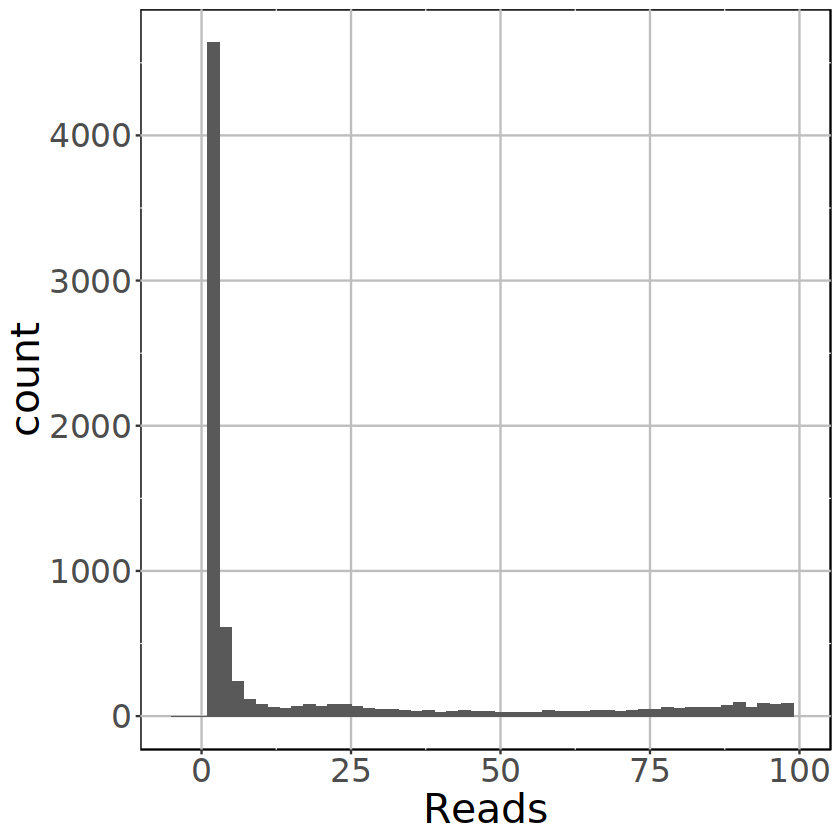

Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_bar()`).”


png 
  2

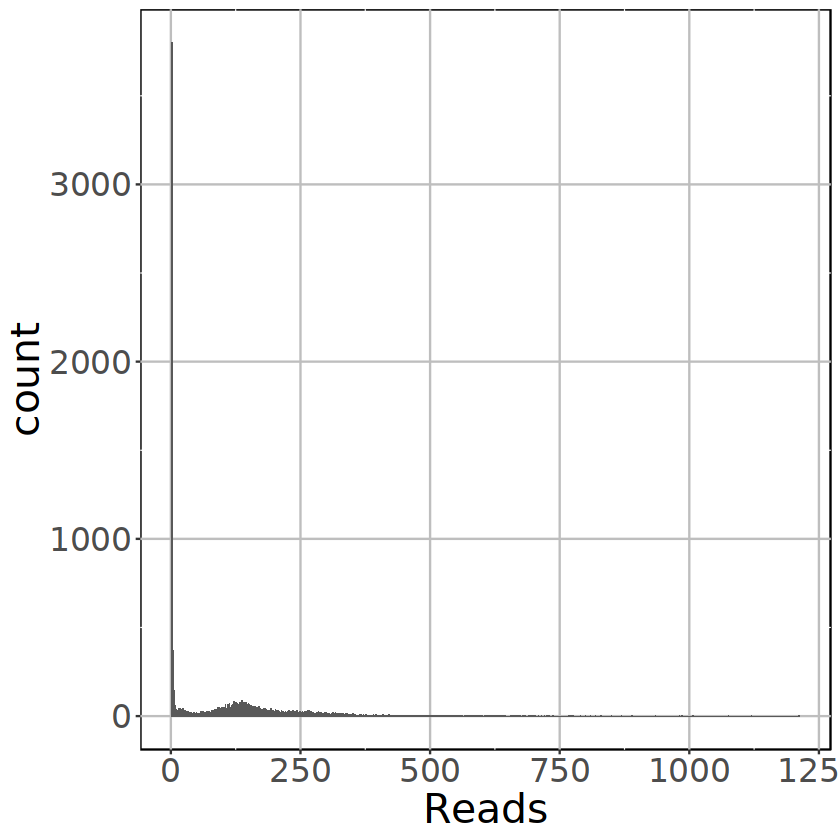

In [28]:
# We use two final filters for the scar data. The first is an undersequencing filter;
# this removes all scars whose read number is under a cutoff. This cutoff is determined based on the histogram of reads per observed scar. 

# Undersequencing filter
scars.output$Reads <- as.numeric(scars.output$Reads)

ggplot(scars.output) +
  geom_histogram(aes(x = Reads), binwidth = 2) +
  scale_x_continuous(limits = c(-5, 100))

ggplot(scars.output) +
  geom_histogram(aes(x = Reads), binwidth = 1) +
  scale_x_continuous()

png(paste0("pics/Scar_ReadNumber_Histogram_",dat_name,'_',scar_name,".png"), width = 5, height = 4, units = 'in', res = 300)
  print(ggplot(scars.output) +
    geom_histogram(aes(x = Reads), binwidth = 1) +
    scale_x_continuous(limits = c(-5, 1000))
    )
dev.off()

In [29]:
# set filtering treshold (min number of reads required to pass filter)
min.scar.reads <- 26
scars.output.2 <- scars.output[scars.output$Reads >= min.scar.reads, ]

# save
write.csv(scars.output.2, paste0("scar_output_2_",dat_name,"_",scar_name,".csv"))

In [30]:
# Add UMI count data to the dataframe

scars.output.2 <- read.csv(paste0('scar_output_2_',dat_name,'_',scar_name,".csv"), stringsAsFactors = F, row.names = 1)
scars.output.2$cell_seqid <- paste0(scars.output.2$Barcode,'_', scars.output.2$Sequence)

all.barcode.UMIs$cell_seqid <- paste0(all.barcode.UMIs$Barcode,'_', all.barcode.UMIs$Sequence)
all.barcode.UMIs <- all.barcode.UMIs[,c('UMIs','cell_seqid')]

table(scars.output.2$cell_seqid %in% all.barcode.UMIs$cell_seqid)
scars.output.umis <- left_join(scars.output.2, all.barcode.UMIs, by = 'cell_seqid')

write.csv(scars.output.umis, paste0("scar_output_2_",dat_name,"_",scar_name,".csv"))


 TRUE 
10097 

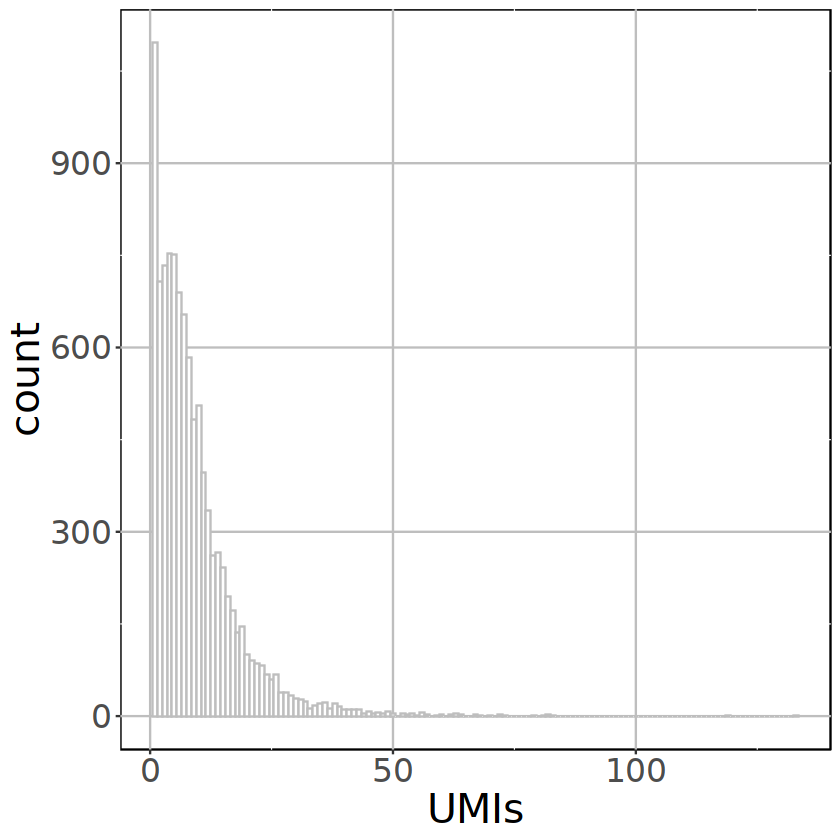

In [31]:
# Plot distribution of number of UMIs observed per cell and lineage barcode
ggplot(scars.output.umis) +
  geom_histogram(aes(x = UMIs), binwidth = 1, fill = 'white',color = 'grey') +
  scale_x_continuous()

### Further filtering on the integration-ID level

In [34]:
# Reload data
scar_name <- "dsRedRecCas"
dat_name <- "multi_seq_09_s1"

scars.output.2 <- read.csv(paste0('scar_output_2_',dat_name,'_',scar_name,".csv"), stringsAsFactors = F, row.names = 1)


#### Extract valid integration ID combinations or integration ID 1 (position 5' of the target sequence)
Across sequencing runs and lineage barcode types, integration ID 1 is the one that is being consistently sequenced.  
Here, we therefore focus on the integration ID 1, so that the pipeline is universally usable across samples and read lengths.
The integration ID is 7 bp long with a G in the middle!

In [35]:
# extract valid integration IDs at 5' end of cassette
scars.output.2$intID_1 <- ''
scars.output.2$intID_1 <- substr(sapply(strsplit(scars.output.2$Sequence, "TTCCTGTAG"), "[", 2),1,7)

# Get combination and assess how frequently we observe each

valid_ids <- as.data.frame(table(scars.output.2$intID_1))
colnames(valid_ids) <- c('intID','Freq')
valid_ids <- valid_ids[order(valid_ids$Freq, decreasing = T),]

head(valid_ids, n = 10)

,intID,Freq
,<fct>,<int>
7,GATGTCA,4252
11,TGTGACG,2005
3,AGCGCGC,1700
15,TTCGTGC,1058
10,TGCGATC,1043
4,CAAGTTC,12
8,GATGTCC,8
9,TAGGAGC,7
2,AGCGCAC,2


Have a look at the frequency of observed sequence IDs and set a cutoff, so that you keep all good-looking integration IDs.  
The cutoff should be sensible regarding the general numbers observed.  
In this case, the first five IDs are valid. They have over 1000 entries, while all others have less than 30.

In [36]:
# Remove all lineage barcode sequences that have one of the invalid integration IDs

# Set cut-off for integration ID selection (based on assessment above)
freq_co <- 500

valid_ids <- valid_ids[order(valid_ids$Freq, decreasing = T),]
valid_ids <- valid_ids[valid_ids$Freq >= freq_co,]

valid_ids <- as.character(valid_ids$intID)


scars_output_filt <- scars.output.2[scars.output.2$intID_1 %in% valid_ids,]

nrow(scars.output.2)
nrow(scars_output_filt)


[1] 10097

[1] 10058

#### Separate integration ID sequence and lineage barcode sequence

In [37]:
# Extract lineage barcode sequences
scars_output_filt$seq_id <- substr(scars_output_filt$Sequence, 34,130)


#### Filter lineage barcodes / cells with multiple lineage barcode sequences in one integration ID
The rationale here is that each integration ID within a cell can only carry one scar sequence. If an integration ID within a single cell has multiple sequences, we need to remove all but one or remove the cell alltogether, if it's unclear which of the scars is the real one.

In [38]:
scars_output_filt$CBC_intid <- paste(scars_output_filt$Barcode, scars_output_filt$intID_1, sep = '_')

scars_output_filt$CBC_intid_seqid <- paste(scars_output_filt$Barcode, scars_output_filt$intID_1, scars_output_filt$Sequence, sep = '_')

# Summarize the dataframe, summing UMIs and picking the first value for all other columns
scars_output_summar <- scars_output_filt %>%
  group_by(CBC_intid_seqid) %>%
  summarise(
    UMIs = sum(UMIs, na.rm = TRUE),
    across(.cols = everything(), .fns = first, .names = "{.col}"),
    .groups = 'drop'
  )


table(duplicated(scars_output_summar$CBC_intid_seqid))

# Calculate cumulative sum and fraction of UMIs per CBC_intid

scars_output_summar <- scars_output_summar[order(scars_output_summar$UMIs, decreasing = T),]
scars_output_summar <- scars_output_summar[order(scars_output_summar$CBC_intid),]


scars_output_summar <- scars_output_summar %>%
  group_by(CBC_intid) %>%
  mutate(umi_frac = UMIs / sum(UMIs),
         umi_cumsum = cumsum(umi_frac)) %>%
  ungroup()


# Save output
write.table(scars_output_summar,paste0("cells_alleles_UMI_stats_dsRedRecCas_",dat_name,".csv"), sep = ",", quote = F)



FALSE 
 9985 

In [39]:
# Reload
all_cell_UMIs <- read.delim(paste0("cells_alleles_UMI_stats_dsRedRecCas_",dat_name,".csv"), stringsAsFactors = F, sep = ',')

table(duplicated(all_cell_UMIs$CBC_intid))
# -> There are some cells that have conflicting information on one transgene integration!
# -> Additional filtering is needed!


FALSE  TRUE 
 8822  1163 

In [40]:
## UMI-filtering -> Here, we require a given sequence on a specific integration ID to contribute at least 60 % of the UMIS of that integration ID in a given cell
## This was adapted from the filtering of scars on endogenous targets, where we specifically look for cells with one or two certain scars, not more. Here, we expect one single scar, i.e. seq_id per cell and per integration ID. 
dim(all_cell_UMIs)
umifrac <- 0.6
      
    subdatf <- all_cell_UMIs
    
    all_cell_UMIs$molid <- paste0(all_cell_UMIs$CBC_intid,all_cell_UMIs$seq_id)
    #####

        # Save cells that only have one scar sequence per integration ID
        cellsonetwo <- as.data.frame(table(all_cell_UMIs$CBC_intid))
        cellsonetwo <- cellsonetwo$Var1[cellsonetwo$Freq == 1]

        cell_UMIs_onetwo <- all_cell_UMIs[all_cell_UMIs$CBC_intid %in% cellsonetwo,]    

        # Get cells that have more than one scar
        cellsmore <- as.data.frame(table(all_cell_UMIs$CBC_intid))
        cellsmore <- cellsmore$Var1[cellsmore$Freq > 1]

        cell_UMIs_more <- all_cell_UMIs[all_cell_UMIs$CBC_intid %in% cellsmore,]

        # Only keep cells that have a scar above the fraction cutoff
        
        cells_cutoff <- cell_UMIs_more[cell_UMIs_more$umi_frac > umifrac,]


        # clean up original UMI-file
        all_cell_UMIs <- all_cell_UMIs[all_cell_UMIs$molid %in% c(cells_cutoff$molid,cell_UMIs_onetwo$molid),]


dim(all_cell_UMIs)

[1] 9985   15

[1] 8679   16

png 
  2

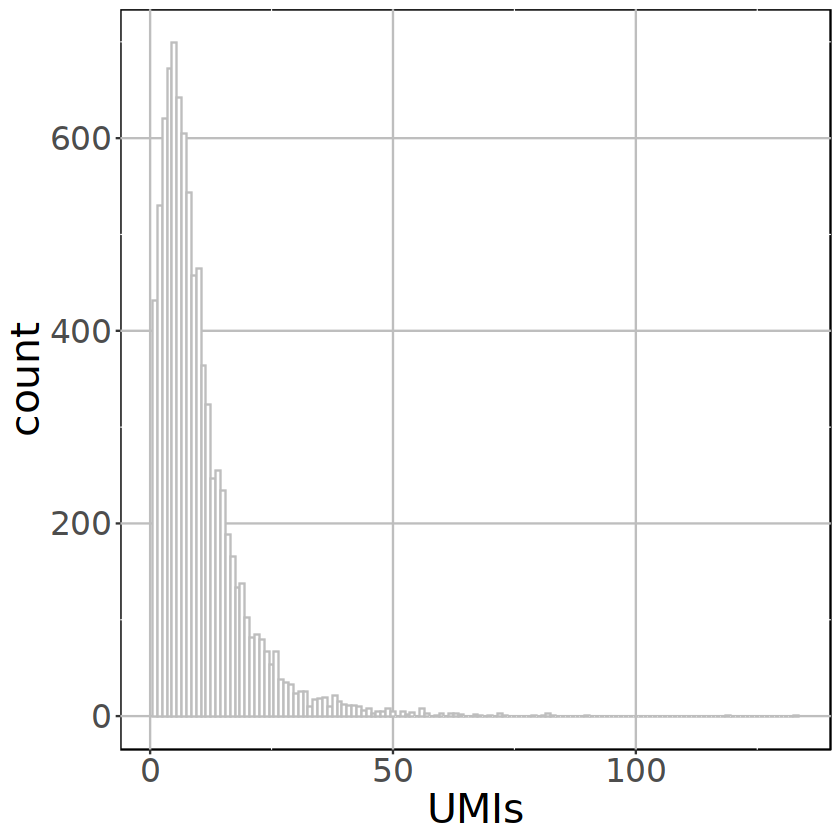

In [41]:
# Remove sequences with very few UMIs. Plot the distribution of UMI-counts per lineage barcode and cell and set a filtering cut-off based on this below.

png(paste0("pics/Scar_UMINumber_Histogram_",dat_name,'_',scar_name,".png"), width = 5, height = 4, units = 'in', res = 300)
  print(
      ggplot(all_cell_UMIs) +
        geom_histogram(aes(x = UMIs), binwidth = 1, fill = 'white',color = 'grey') +
        scale_x_continuous()
    )
dev.off()

ggplot(all_cell_UMIs) +
  geom_histogram(aes(x = UMIs), binwidth = 1, fill = 'white',color = 'grey') +
  scale_x_continuous()


In [42]:
# Set cut-off based on histogram. Filter data
umi_min <- 2

all_cell_UMIs <- all_cell_UMIs[all_cell_UMIs$UMIs >= umi_min,]

print(paste0('Filtered lineage barcode data on dsRedRecCas exists for ', length(unique(all_cell_UMIs$Barcode)), ' cells.'))

[1] "Filtered lineage barcode data on dsRedRecCas exists for 5094 cells."


In [43]:
write.table(all_cell_UMIs,paste0("cells_alleles_UMI_filtered_dsRedRecCas_",dat_name,".csv"), sep = ",", quote = F)


### Plot filtered transgene lineage barcodes

In [44]:
# Reload data
dat_name <- "multi_seq_09_s1"

scars_output_filt <- read.delim(paste0("cells_alleles_UMI_filtered_dsRedRecCas_",dat_name,".csv"), stringsAsFactors = F, sep = ',')

scars_output_filt_sub <- scars_output_filt
scars_output_filt_sub$intid_seq_id <- paste0(scars_output_filt_sub$intID_1,'_', scars_output_filt_sub$seq_id)


In [45]:
# get matrix of cell barcode vs seq_id with integration id
allls_cbs <- as.data.frame.matrix(table(scars_output_filt_sub$Barcode, scars_output_filt_sub$intid_seq_id))
table(rowSums(allls_cbs))
allls_cbs$Barcode <- rownames(allls_cbs)


# Add some metadata info (the column specifications in the left_join will depend on the metadata info that you have and want to use
allls_cbs <- allls_cbs[!duplicated(allls_cbs$Barcode),]
table(duplicated(allls_cbs$Barcode))


cell_info <- left_join(allls_cbs, cell_anno[,c("Barcode","seurat_clusters","sample_inf")], by = "Barcode")

rownames(cell_info) <- cell_info$Barcode

allls_cbs$Barcode <- NULL

scar_info <- scars_output_filt_sub[,c('Barcode', 'intID_1')]



   1    2    3    4    5 
2449 2185  412   47    1 


FALSE 
 5094 

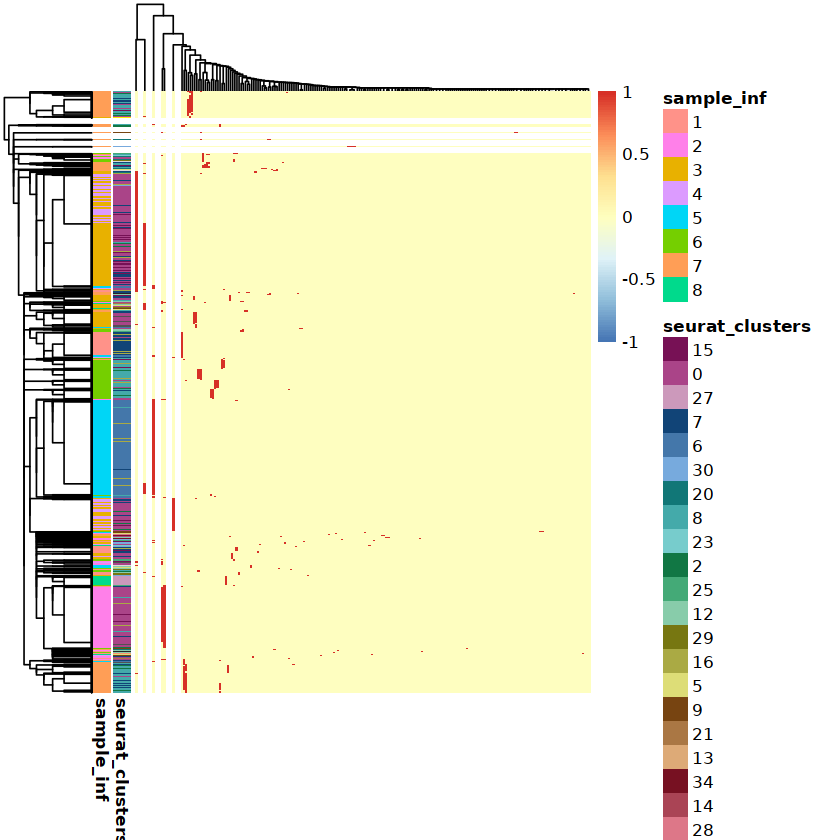

In [46]:
# Plot. Specify colors. Adjust this to the metadata columns that you want to use.

cols_celltype <- tol21rainbow[1:length(unique(cell_info$seurat_clusters))]
names(cols_celltype) <- unique(cell_info$seurat_clusters)

cols_tumour <- tol21rainbow[1:length(unique(cell_info$sample_inf))]
names(cols_tumour) <- unique(cell_info$fish_all)

cols_scar <- tol21rainbow[1:length(unique(scar_info$seq_id))]
names(cols_scar) <- unique(scar_info$seq_id)

ann_colors = list(
    seurat_clusters = cols_celltype,
    fish_all = cols_tumour,
    seq_id = cols_scar
)


ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  breaks = seq(-1, +1, length = 101),
  annotation_row = cell_info[,c("seurat_clusters","sample_inf")],
  #annotation_col = scar_info,
  annotation_colors = ann_colors,
  cutree_cols = 6,
  cutree_rows = 6
)

ggsave(plot = ploto, filename = paste0("pics/dsRedRecCas_CIGARs_",dat_name,"_heatmap.png"), width = 6.5, height = 10, dpi = 300)


#### Remove wildtype sequences and plot again

In [47]:
# Define wildtype sequences
scars_output_filt_sub$wt <- 'no'

scars_output_filt_sub$wt[scars_output_filt_sub$Sequence %like any% c('%TCCGGAGGTGTCCACGTAGTAGTAGCCGGGGTTACAGGAACAGTACGAGCGCTCCGAGGGTTAACCGGACGGCGGCCACTACCTGGTGG%')] <- 'yes'

# Remove wildtype sequences
scars_output_filt_sub <- scars_output_filt_sub[scars_output_filt_sub$wt == 'no',]


In [48]:
# get matrix of cell barcode vs seq_id with integration id
allls_cbs <- as.data.frame.matrix(table(scars_output_filt_sub$Barcode, scars_output_filt_sub$intid_seq_id))
table(rowSums(allls_cbs))
allls_cbs$Barcode <- rownames(allls_cbs)


# Add some metadata info (the column specifications in the left_join will depend on the metadata info that you have and want to use
allls_cbs <- allls_cbs[!duplicated(allls_cbs$Barcode),]
table(duplicated(allls_cbs$Barcode))


cell_info <- left_join(allls_cbs, cell_anno[,c("Barcode","seurat_clusters","sample_inf")], by = "Barcode")

rownames(cell_info) <- cell_info$Barcode

allls_cbs$Barcode <- NULL

scar_info <- scars_output_filt_sub[,c('Barcode', 'intID_1')]



   1    2    3    4 
1994  796  314   35 


FALSE 
 3139 

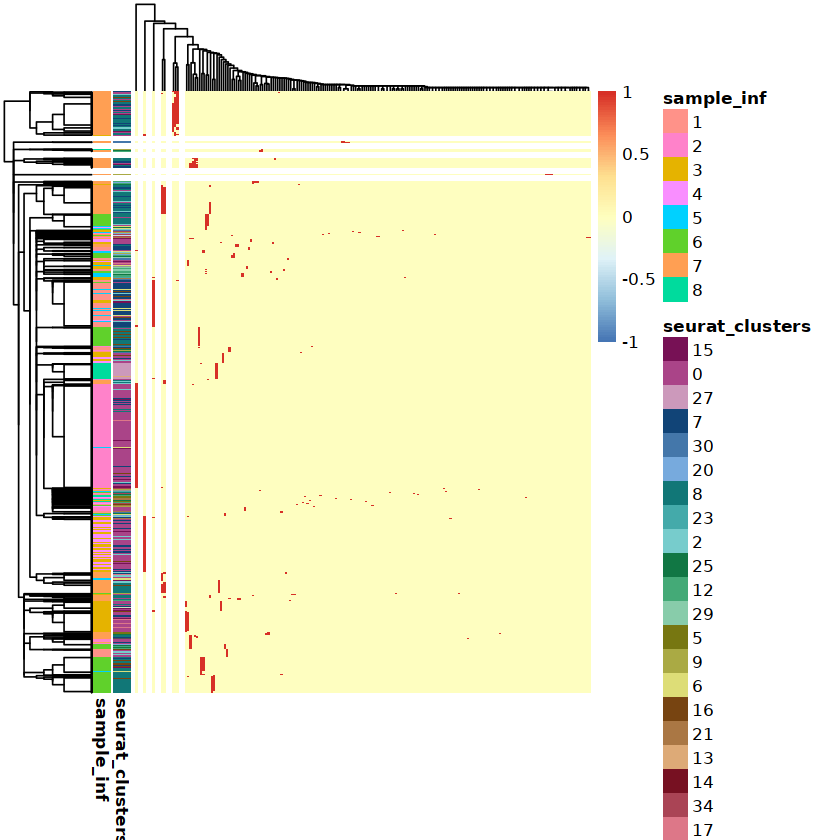

In [49]:
# Specify colors. Again, adjust this to the metadata columns that you want to use.

cols_celltype <- tol21rainbow[1:length(unique(cell_info$seurat_clusters))]
names(cols_celltype) <- unique(cell_info$seurat_clusters)

cols_tumour <- tol21rainbow[1:length(unique(cell_info$sample_inf))]
names(cols_tumour) <- unique(cell_info$fish_all)

cols_scar <- tol21rainbow[1:length(unique(scar_info$seq_id))]
names(cols_scar) <- unique(scar_info$seq_id)


ann_colors = list(
    seurat_clusters = cols_celltype,
    fish_all = cols_tumour,
    seq_id = cols_scar
)


ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  breaks = seq(-1, +1, length = 101),
  annotation_row = cell_info[,c("seurat_clusters","sample_inf")],
  #annotation_col = scar_info,
  annotation_colors = ann_colors,
  cutree_cols = 6,
  cutree_rows = 6

)
ggsave(plot = ploto, filename = paste0("pics/dsRedRecCas_CIGARs_",dat_name,"_wo_wildtype_heatmap.png"), width = 6.5, height = 10, dpi = 300)


## Clone calling based on all target genes

In [50]:
# Set a sample-list.

tums_list <- c('all', unique(cell_anno$fish_all))


In [8]:
tums_list <- c(1,2,3,4)
i <- 1

### Load data for individual genes and merge

In [4]:
# DETERMINE WHETHER YOU WANT TO KEEP WT sequences. FALSE is recommended!
with_wt <- FALSE

# Set other parameters for recovery of endogenous target genes:
dat_name <- 'multi_seq_09_s1'
dat_wd  <- paste0(getwd())
genes_list <- c("actb1","actb2","rpl39","cfl1","rpl18a")

In [52]:
# This is done per sample:

for(i in 1:length(tums_list)){

    tum_it <- tums_list[i]

# Load dsRedRecCas data and cross-reference with Seurat cell metadata

    if(tum_it == 'all'){
        cell_anno_sub <- cell_anno
    }else{
        cell_anno_sub <- cell_anno[cell_anno$fish_all == tum_it,]
    }

    scars_output_filt <- read.delim(paste0('cells_alleles_UMI_filtered_dsRedRecCas_',dat_name,'.csv'), stringsAsFactors = F, sep = ',')

    scars_output_filt_sub <- scars_output_filt[scars_output_filt$Barcode %in% cell_anno_sub$Barcode ,]
    scars_output_filt_sub$comb_seq_id <- paste0(scars_output_filt_sub$intID_1,'_', scars_output_filt_sub$seq_id)

    # Remove wildtype sequences

    scars_output_filt_sub$wt <- 'no'

    scars_output_filt_sub$wt[scars_output_filt_sub$Sequence %like any% c('%TCCGGAGGTGTCCACGTAGTAGTAGCCGGGGTTACAGGAACAGTACGAGCGCTCCGAGGGTTAACCGGACGGCGGCCACTACCTGGTGG%')] <- 'yes'

    if(with_wt == F){
        scars_output_filt_sub <- scars_output_filt_sub[scars_output_filt_sub$wt == 'no',]
    }

    # Remove lineage barcodes that appear in only very few cells

    clone_freqs <- as.data.frame(table(scars_output_filt_sub$comb_seq_id))
    clone_freqs <- clone_freqs$Var1[clone_freqs$Freq >= 5]
    scars_output_filt_sub <- scars_output_filt_sub[scars_output_filt_sub$comb_seq_id %in% clone_freqs,]

# Load endogenous target gene data 
    scar_file_list <- load_single_target_clones(dat_wd = dat_wd,
                                                dat_name = dat_name,
                                                tum_it = tum_it,
                                                genes_list = genes_list,
                                                cooc_fraction_cutoff = 0.8,
                                                use_uncert = F # Recommended to be set to FALSE! Otherwise, low confidence barcodes will be used.
                                                )  
    
    
    # Merge into one big file for all endogenous target genes
    num_targs <- length(scar_file_list)

    if(num_targs == 1){

        all_scars <- scar_file_list[[1]]

    }else if(num_targs == 2){

        all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]])

    }else if(num_targs == 3){

        all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]],scar_file_list[[3]])

    }else if(num_targs == 4){

        all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]],scar_file_list[[3]],scar_file_list[[4]])

    }else if(num_targs == 5){

    all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]],scar_file_list[[3]],scar_file_list[[4]],scar_file_list[[5]])

    }

    all_scars$cloneIDBC <- paste0(all_scars$Barcode, all_scars$cloneID)
    all_scars <- all_scars[duplicated(all_scars$cloneIDBC) == F,]

    # fill in proper combined seq_ids
    # 1. for cells with a single scar that were added to a double-scar-clone

    clone_seq_id <- as.data.frame(table(all_scars$cloneID, all_scars$comb_seq_id))
    clone_seq_id <- clone_seq_id[clone_seq_id$Freq != 0,]
    colnames(clone_seq_id) <- c("cloneID","comb_seq_id_corr","Freq")
    clone_seq_id$Freq <- NULL
    clone_seq_id$cloneID <- as.character(clone_seq_id$cloneID)
    clone_seq_id$comb_seq_id_corr <- as.character(clone_seq_id$comb_seq_id_corr)

    all_scars <- left_join(all_scars, clone_seq_id, by = "cloneID")


    # 2. for cells with a single scar that only had this scar

    table(is.na(all_scars$comb_seq_id_corr[!(all_scars$cloneID %in% clone_seq_id$cloneID) & !(all_scars$cloneID %like any% '%_WT')])) # should all be TRUE

    all_scars$comb_seq_id_corr[!(all_scars$cloneID %in% clone_seq_id$cloneID) & !(all_scars$cloneID %like any% '%_WT')] <- all_scars$seq_id_1[!(all_scars$cloneID %in% clone_seq_id$cloneID) & !(all_scars$cloneID %like any% '%_WT')]

    table(is.na(all_scars$comb_seq_id_corr[!(all_scars$cloneID %in% clone_seq_id$cloneID) & !(all_scars$cloneID %like any% '%_WT')])) # should all be FALSE

    # Save merged endogenous target data
    write.csv(all_scars, paste0("all_endo_scars_",dat_name,"_",tum_it,".csv"), quote = F)

    
    # Remove clones that are very small and potentially artefacts
    clone_freqs <- as.data.frame(table(all_scars$cloneID))
    clone_freqs <- clone_freqs$Var1[clone_freqs$Freq > 5]
    all_scars <- all_scars[all_scars$cloneID %in% clone_freqs,]

    # Remove wildtpye seqs:

    if(with_wt == F){
        all_scars <- all_scars[!(all_scars$cloneID %like any% "%WT"),]
    }
    
# Merge dsRedRecCas and endogenous target data
    all_scars <- all_scars[,c('Barcode','Gene','comb_seq_id_corr','CIGAR')]
    colnames(all_scars) <- c('Barcode','Gene','comb_seq_id','CIGAR')

    if(nrow(scars_output_filt_sub) == 0){
        all_scars_ext <- all_scars

    }else{
        scars_output_filt_sub$Gene <- paste0('dsRedRecCas_', gsub("(.+?)(\\_.*)", "\\1", scars_output_filt_sub$comb_seq_id))

        scars_output_filt_sub <- scars_output_filt_sub[,c('Barcode','Gene','comb_seq_id','CIGAR')]

        all_scars_ext <- rbind(all_scars, scars_output_filt_sub)

    }

    ## Merge with metadata
    all_scars_ext_ann <- left_join(all_scars_ext, cell_anno_sub, by = 'Barcode')


    if(with_wt == T){
        write.csv(all_scars_ext_ann, paste0('all_target_scars_',dat_name,'_tum_',tum_it,'_withWTcells.csv'))
    }else{
        write.csv(all_scars_ext_ann, paste0('all_target_scars_',dat_name,'_tum_',tum_it,'.csv'))
    }
    
    
    
}

[1] "Loaded file pattern for target actb1: _cutoff_0.8_with_wt.txt"
[1] "Loaded clones for gene actb1"
[1] "Loaded file pattern for target actb2: _cutoff_0.8_SingleScarExt.txt"
[1] "Loaded clones for gene actb2"
[1] "Loaded file pattern for target rpl39: _cutoff_0.8_SingleScarExt.txt"
[1] "Loaded clones for gene rpl39"
[1] "Loaded file pattern for target cfl1: _cutoff_0.8_SingleScarExt.txt"
[1] "Loaded clones for gene cfl1"
[1] "Loaded file pattern for target rpl18a: _cutoff_0.8_SingleScarExt.txt"
[1] "Loaded clones for gene rpl18a"
[1] "Highest scar file number: 5"
[1] "Loaded file pattern for target actb1: _cutoff_0.8_SingleScarExt.txt"
[1] "Loaded clones for gene actb1"
[1] "Loaded file pattern for target actb2: _cutoff_0.8_with_wt.txt"
[1] "Loaded clones for gene actb2"
[1] "Loaded file pattern for target rpl39: _cutoff_0.8_SingleScarExt.txt"
[1] "Loaded clones for gene rpl39"
[1] "Loaded file pattern for target cfl1: _cutoff_0.8_with_wt.txt"
[1] "Loaded clones for gene cfl1"
[1] "

### Reload data and call clones

In [72]:
# Get list of samples to consider
tums_list <- c('all',unique(cell_anno$sample_inf))


[1] "Working on sample all"


Warning message in melt(overlap_matrix, na.rm = TRUE):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(overlap_matrix). In the next version, this warning will become an error.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Barcode'. You can override using the `.groups` argument.


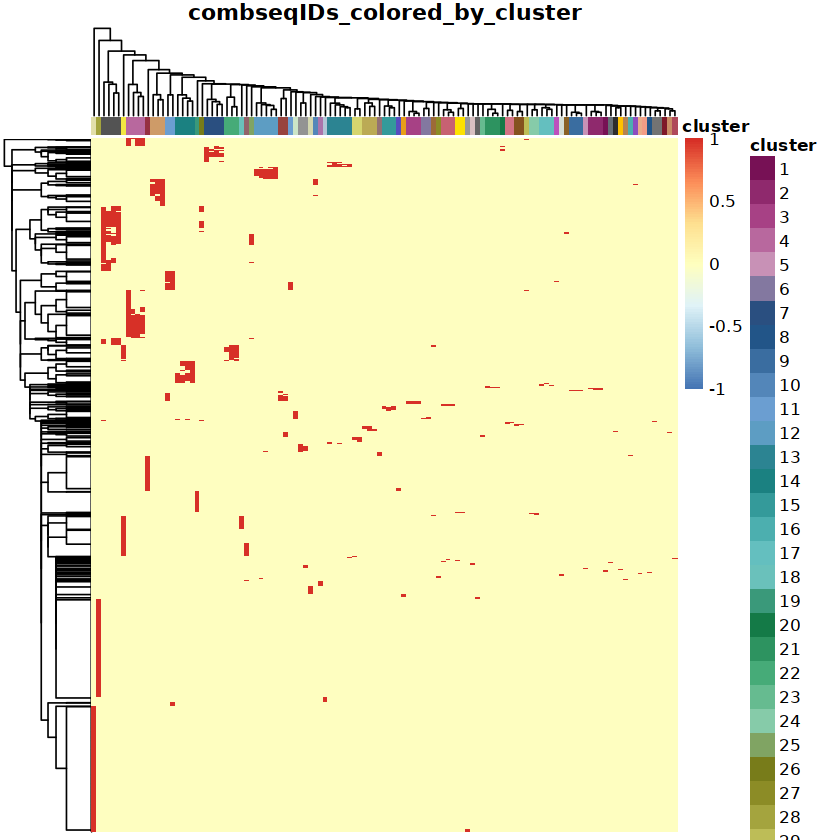

[1] "Now plotting final clones for sample all"


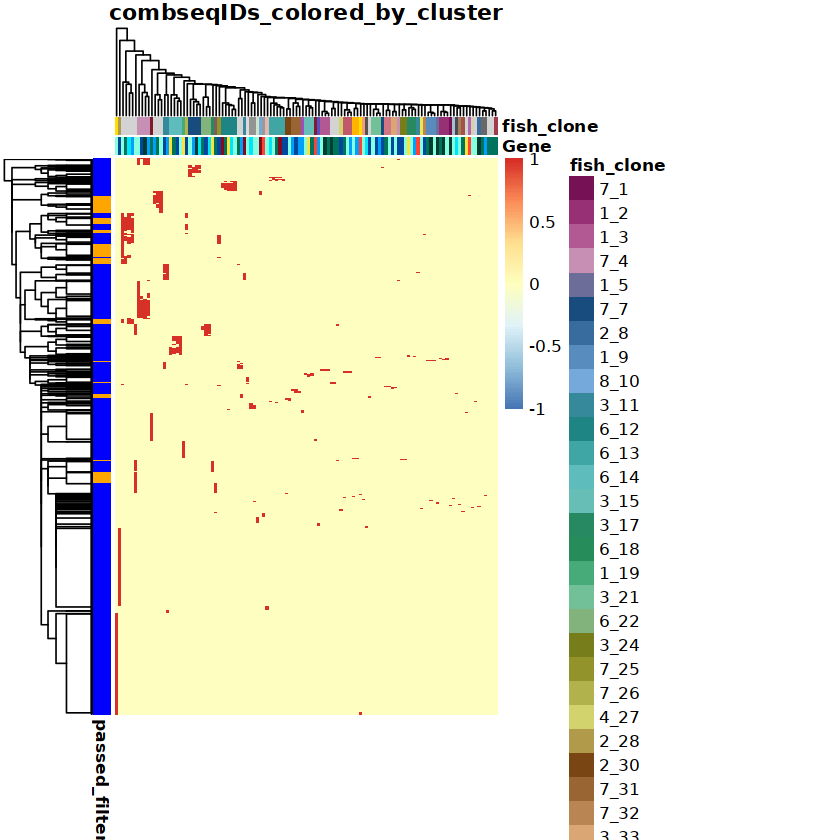

[1] "Working on sample 3"


Warning message in melt(overlap_matrix, na.rm = TRUE):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(overlap_matrix). In the next version, this warning will become an error.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Barcode'. You can override using the `.groups` argument.


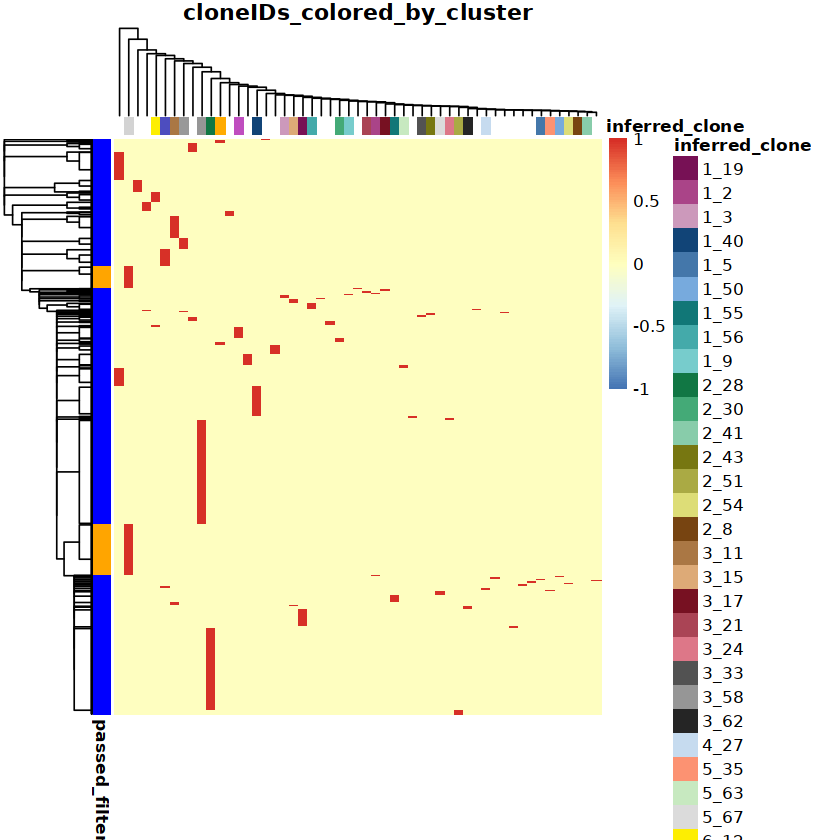

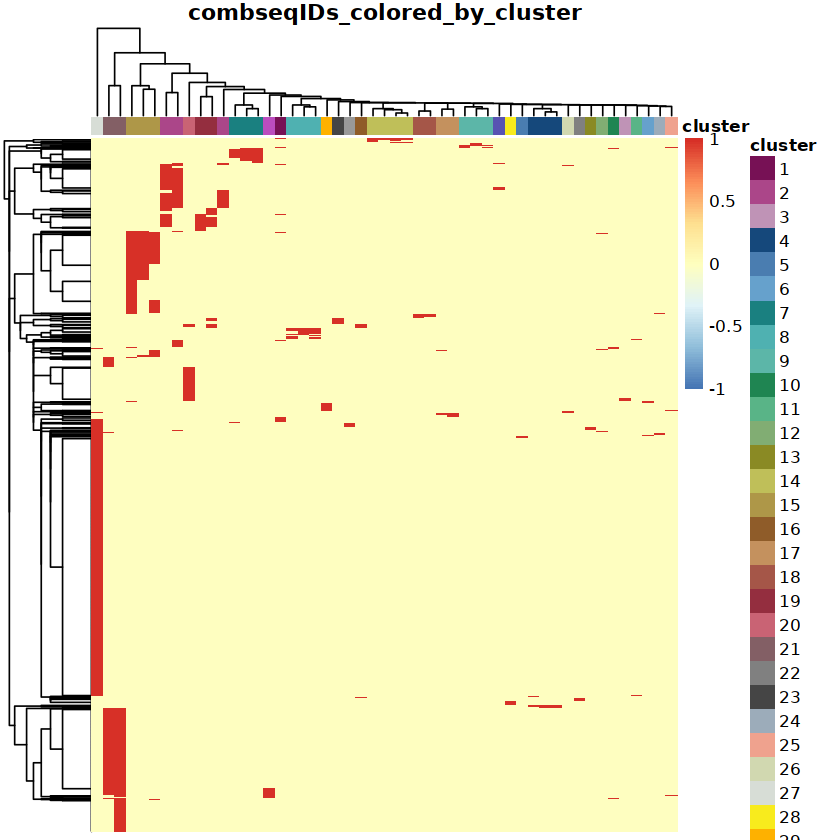

[1] "Now plotting final clones for sample 3"


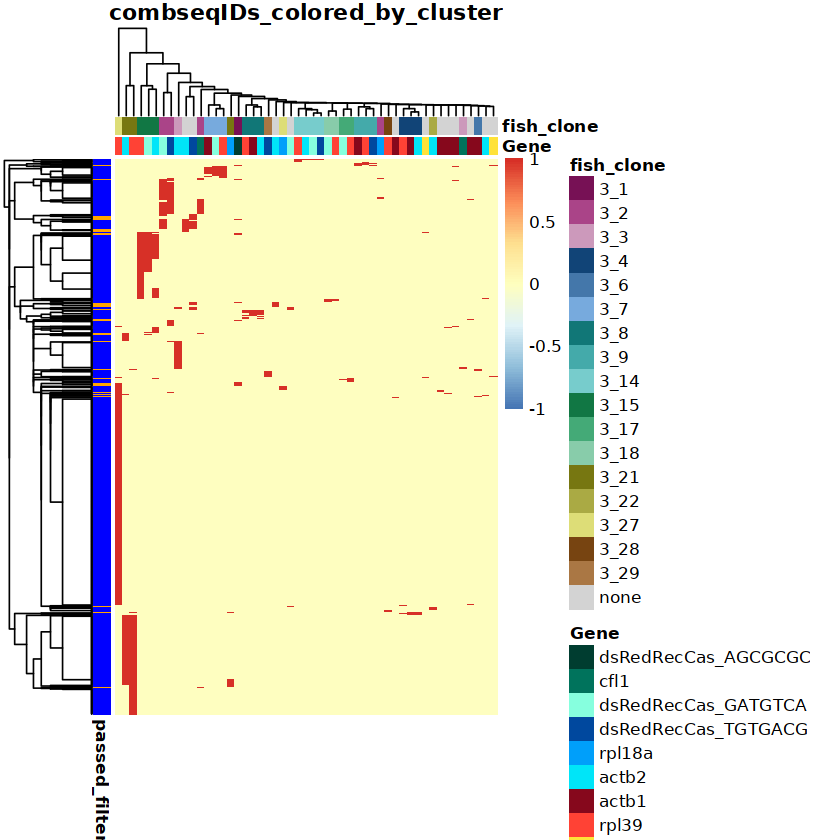

[1] "Working on sample 5"


Warning message in melt(overlap_matrix, na.rm = TRUE):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(overlap_matrix). In the next version, this warning will become an error.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Barcode'. You can override using the `.groups` argument.


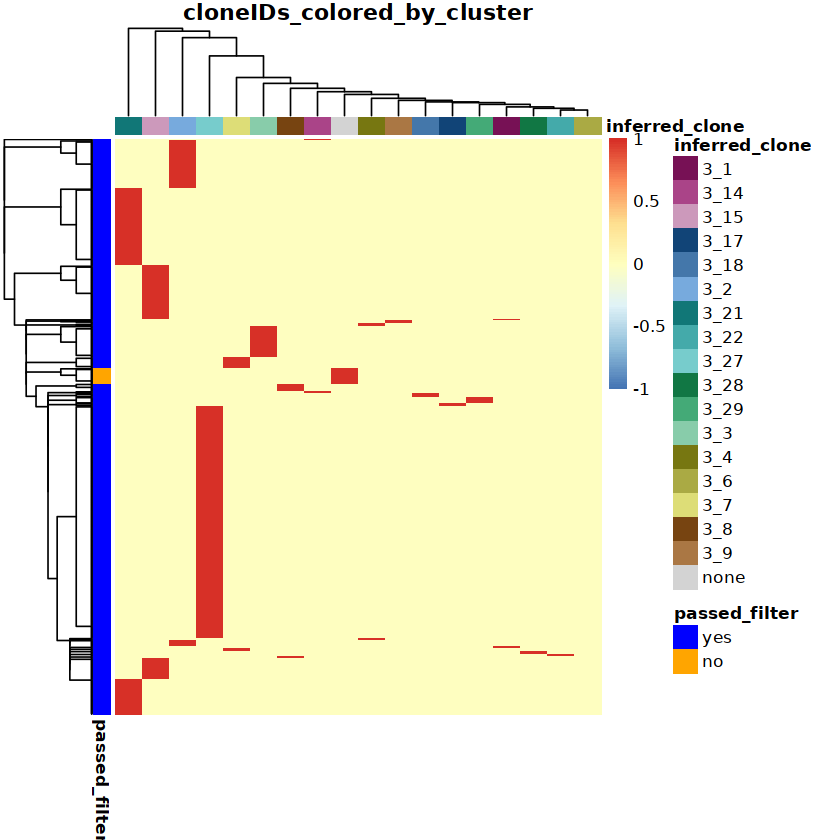

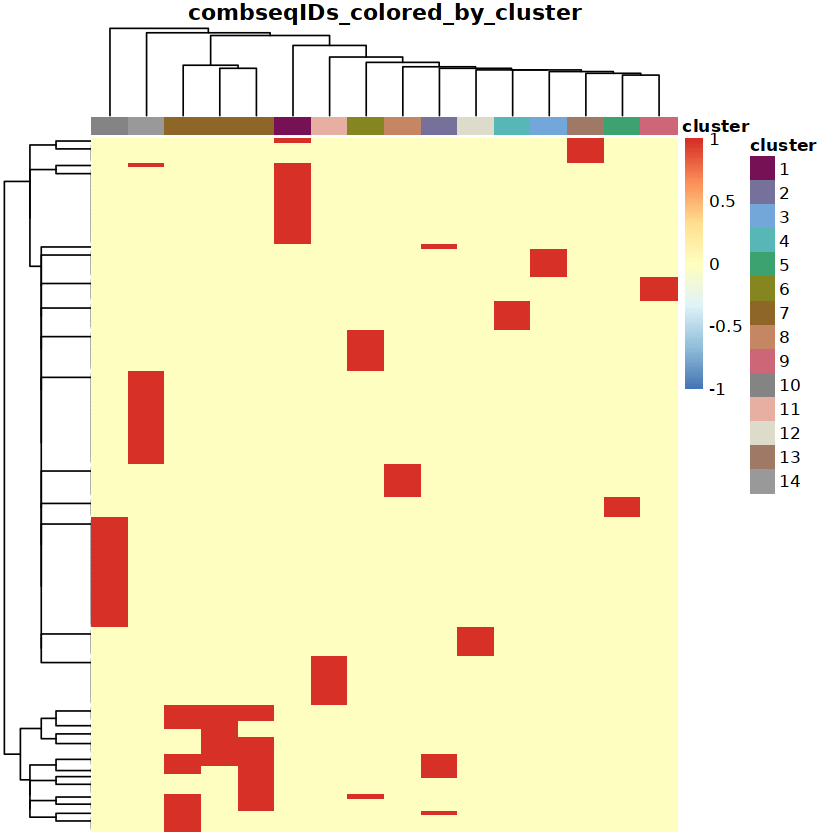

[1] "Now plotting final clones for sample 5"


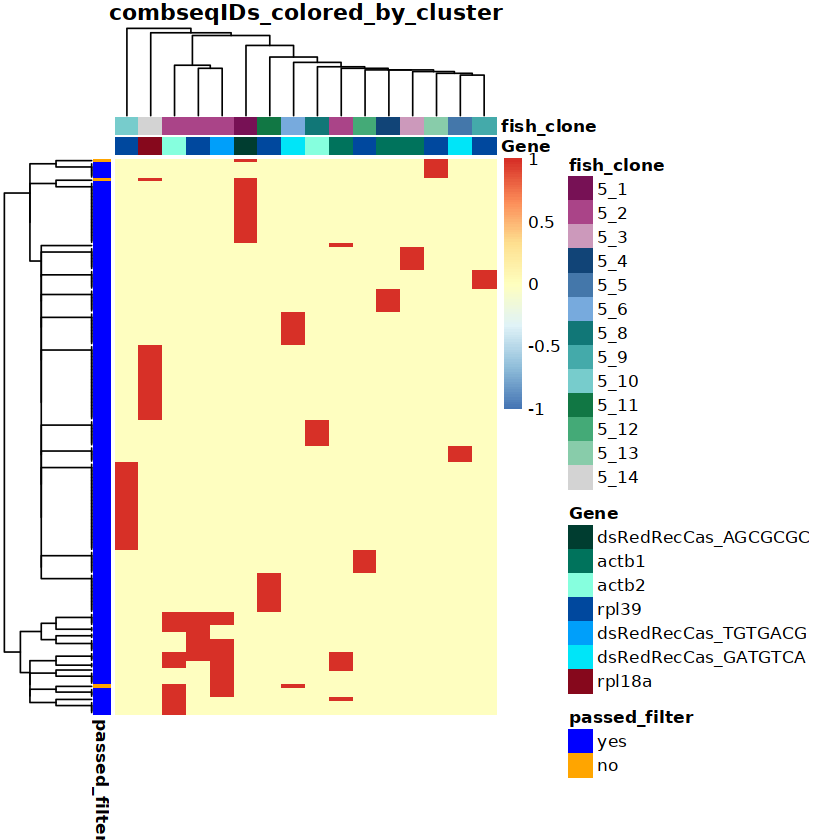

[1] "Working on sample 1"


Warning message in melt(overlap_matrix, na.rm = TRUE):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(overlap_matrix). In the next version, this warning will become an error.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Barcode'. You can override using the `.groups` argument.


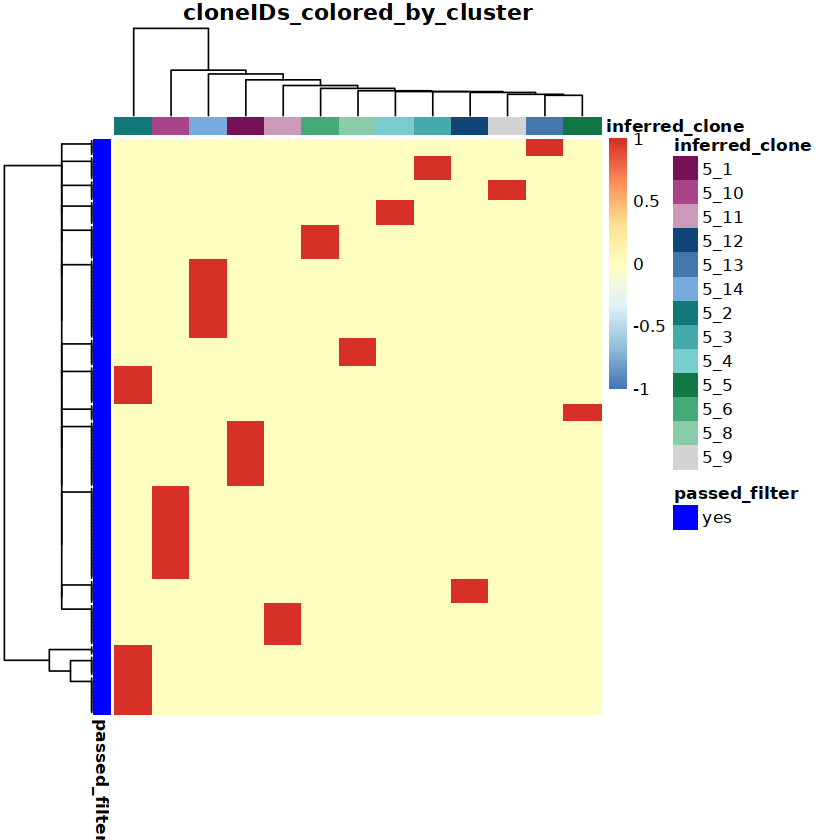

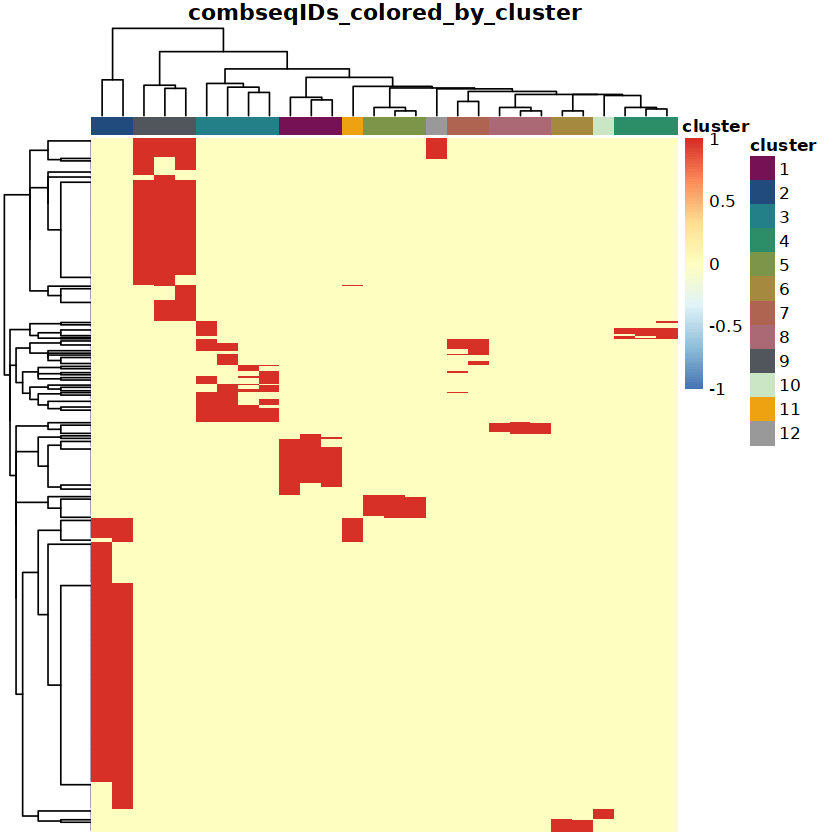

[1] "Now plotting final clones for sample 1"


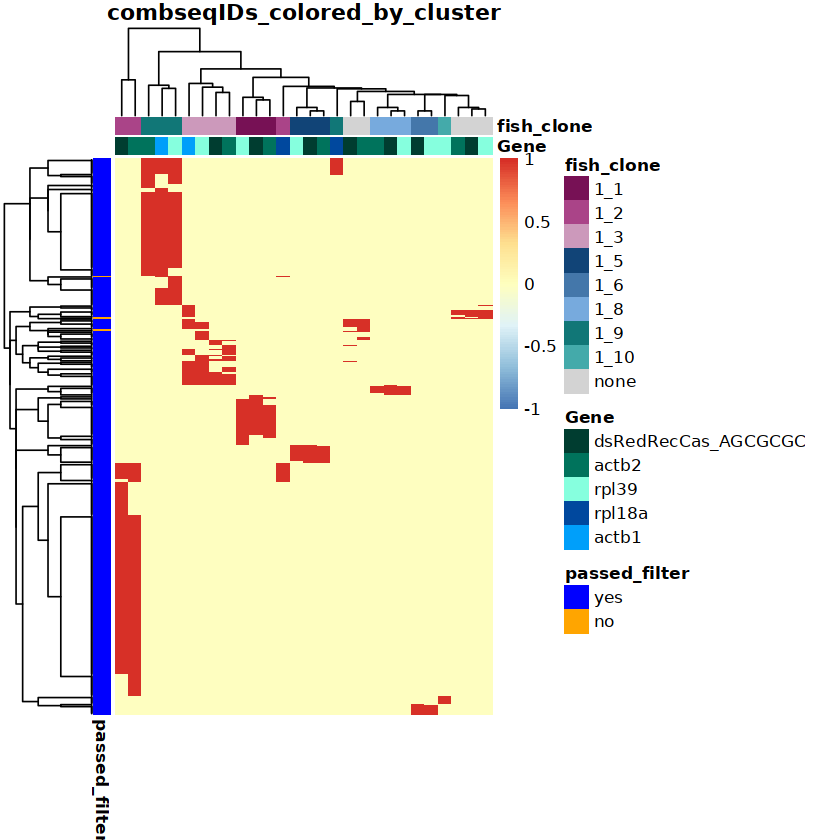

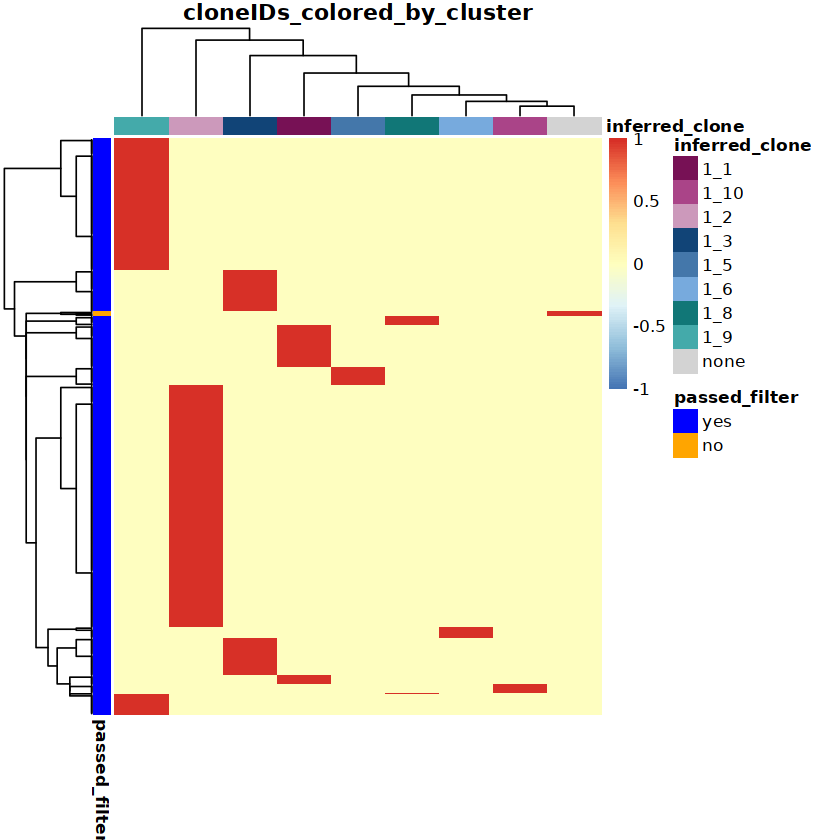

In [74]:
# This is done per sample:

for(i in 1:length(tums_list)){

    tum_it <- tums_list[i]
    
    cell_clone_object_file_name = 'all_target_scars_'

    cell_clone_object <- read.delim(paste0(dat_wd, '/', cell_clone_object_file_name,dat_name,'_tum_',tum_it,'.csv'), stringsAsFactors = F, sep = ',', row.names = 1)

    cell_clone_object$sample_inf <- cell_clone_object$fish_all

    # Run automatic clone classification

    clone_def(dat_wd = paste0(getwd()),
              dat_name = 'multi_seq_09_s1',
              tums_list = tum_it,
              cell_clone_object_file_name = 'all_target_scars_',
              tum_def_only = T,
              create_intermediate_plots = T,
              merger_frac = 0.85,
              overlap_threshold = 0.8,
              secondary_overlap_threshold = 0.5,
              ambiguous_cutoff = 0.3,
              allow_large_parent_IDs <- FALSE, # Important setting to tune 'resolution' of clone grouping! FALSE will result in high resolution groupings!
              child_to_parent_fraction_cutoff <- 0.25
             )
    
}

## Plot final clones

Do this manually per tumour sample.
Here we will look at fish ID 1 as an example.

In [75]:
tum_it <- '1'

In [76]:
# Reload data for high resolution clones for fish ID 1
clone_df <- read.delim(paste0('filtered_scar_data_with_clone_defs_final_',dat_name,'_',tum_it,'_highResolutionClones_resCutoff_0.csv'), sep = ',', stringsAsFactors = F, row.names = 1)

clone_df <- clone_df[!is.na(clone_df$fish_clone),]
clone_df$fish_clone <- as.character(clone_df$fish_clone)


In [77]:
# Merge with cell metadata
clone_df_inf <- clone_df[!duplicated(clone_df$Barcode),]


In [78]:
# get matrix of cell barcode vs seq_id with integration id
allls_cbs <- as.data.frame.matrix(table(clone_df_inf$Barcode, clone_df_inf$fish_clone))
table(rowSums(allls_cbs))
allls_cbs$Barcode <- rownames(allls_cbs)

# Add some metadata info (the column specifications in the left_join will depend on the metadata info that you have and want to use
allls_cbs <- allls_cbs[!duplicated(allls_cbs$Barcode),]
table(duplicated(allls_cbs$Barcode))

# Choose metadata columns to keep for plotting
cell_info <- left_join(allls_cbs, clone_df_inf[,c("Barcode","tumour_all","fish_all","celltype")], by = "Barcode")
cell_info$fish_all <- as.character(cell_info$fish_all)

rownames(cell_info) <- cell_info$Barcode

allls_cbs$Barcode <- NULL


# Prepare summarized metadata tables for plotting
scar_info <- clone_df_inf[!duplicated(clone_df_inf$fish_clone),]
rownames(scar_info) <- scar_info$fish_clone

scar_info <- scar_info[order(scar_info$fish_clone, decreasing = F),]

# Order main data to get the proper order of scars in the heatmap column
allls_cbs <-  allls_cbs[,order(match(colnames(allls_cbs),rownames(scar_info)))]



  1 
548 


FALSE 
  548 

In [79]:
cell_info$celltype[cell_info$celltype == 'Endothelial'] <- 'Endothelial_cells'
cell_info$celltype[cell_info$celltype == 'Epithelial'] <- 'Endothelial_cells'
cell_info$celltype[cell_info$celltype == 'HSCs_thrombocytes'] <- 'HSPCs'
cell_info$celltype[cell_info$celltype == 'Fibroblasts_smoothMuscle'] <- 'Fibroblasts'
cell_info$celltype[cell_info$celltype == 'Glial_cells'] <- 'Glial_sox10'

names(allmerged_final_ct_cols)[names(allmerged_final_ct_cols) == 'Blood_progenitors'] <- 'Proliferating_cells'

In [80]:
# Define colours for heatmap annotation

# Create one dataframe for the actual cloneIDs
scar_info_clust <- as.data.frame(scar_info$fish_clone)
rownames(scar_info_clust) <- rownames(scar_info)
colnames(scar_info_clust)[1] <- "fish_clone"


# Create one dataframe for celltypes only
cell_info_clust <- as.data.frame(cell_info$celltype)
rownames(cell_info_clust) <- rownames(cell_info)
colnames(cell_info_clust)[1] <- "celltype"


cols_celltype <- allmerged_final_ct_cols
cols_celltype <- cols_celltype[names(cols_celltype) %in% cell_info$celltype]

cols_tumour <- tol21rainbow[1:length(unique(cell_info$tumour_all))]
names(cols_tumour) <- unique(cell_info$tumour_all)

cols_fish <- tol21rainbow[1:length(unique(cell_info$fish_all))]
names(cols_fish) <- unique(cell_info$fish_all)

cols_scar <- tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(scar_info_clust$fish_clone))]
names(cols_scar) <- unique(scar_info_clust$fish_clone)


ann_colors = list(
    tumour_all = cols_tumour,
    fish_all = cols_fish,
    celltype = cols_celltype,
    fish_clone = cols_scar
)


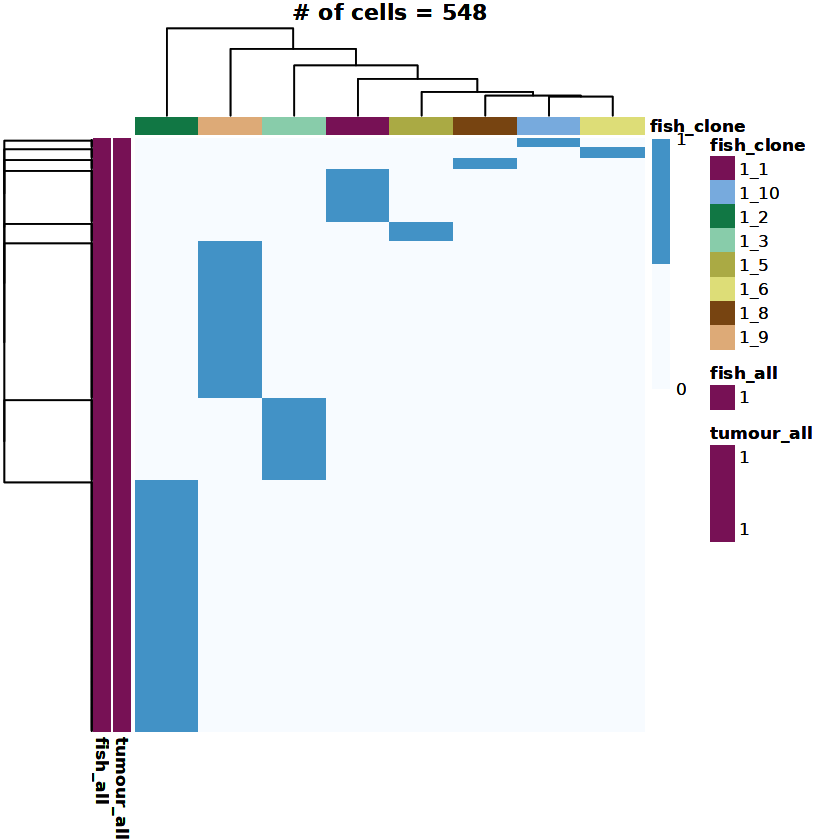

In [81]:
ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  annotation_row = cell_info[,c("tumour_all","fish_all")],
  color = colorRampPalette(c("#F7FBFF", "#4292C6"))(2),
  legend_breaks = seq(0,1) ,
  annotation_col = scar_info_clust,
  annotation_colors = ann_colors,
  cluster_cols = T,
  main = paste0('# of cells = ',length(unique(clone_df_inf$Barcode))),
)
ploto

ggsave(plot = ploto, filename = paste0("pics/allTargs_",dat_name,"_CommonClusters_exclusive_heatmap_tum_",tum_it,"_FishAndTum.png"), width = 6.5, height = 10, dpi = 300)


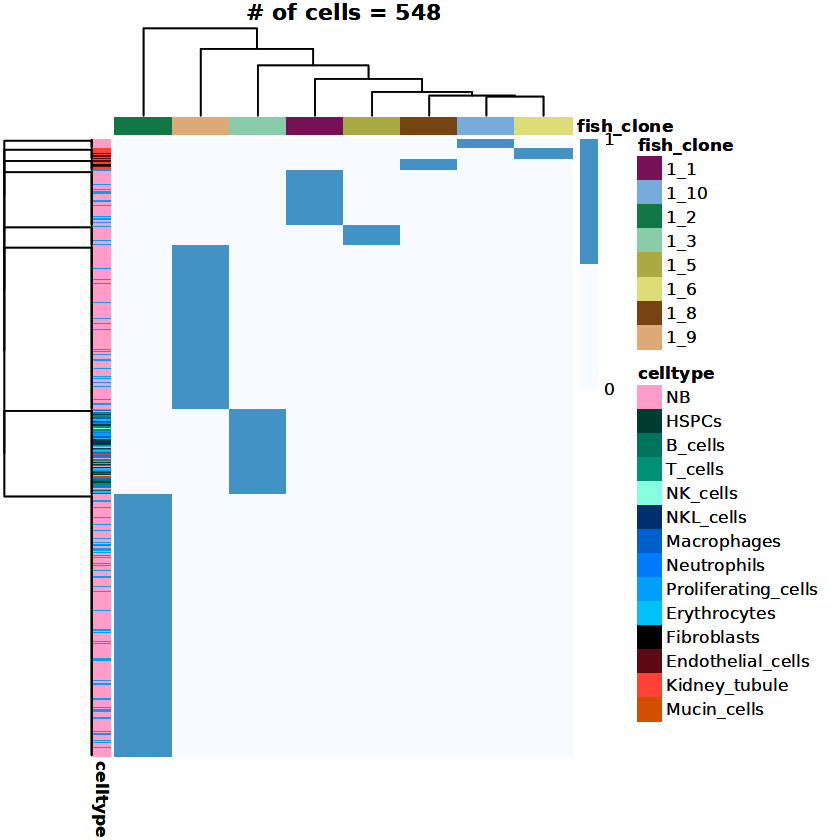

In [82]:
ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  color = colorRampPalette(c("#F7FBFF", "#4292C6"))(2),
  legend_breaks = seq(0,1) ,
  annotation_row = cell_info_clust,
  annotation_col = scar_info_clust,
  annotation_colors = ann_colors,
  cluster_cols = T,
  main = paste0('# of cells = ',length(unique(clone_df_inf$Barcode))),
  #cutree_cols = 14,
  #cutree_rows = 6

)
ploto
ggsave(plot = ploto, filename = paste0("pics/allTargs_",dat_name,"_CommonClusters_exclusive_heatmap_tum_",tum_it,"_CelltypeAndTum_withCloneIDs.png"), width = 6, height = 9, dpi = 500)
